In [1]:
# Function to read graph from json file
import json
from networkx.readwrite import json_graph

def read_graph_from_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return json_graph.adjacency_graph(data) 

In [2]:
# Read the county-level graph
filepath = 'C:\\districting-data-2020\\'
filename = 'MT_county.json'

k = 2        # number of districts
G = read_graph_from_json( filepath + filename )

for i in G.nodes:
    G.nodes[i]['TOTPOP'] = int( G.nodes[i]['P0010001'] )

In [3]:
import math

# Calculate lower and upper population limits
ideal_population = sum( G.nodes[i]['TOTPOP'] for i in G.nodes ) / k
L = math.floor( ideal_population )
U = math.ceil( ideal_population )
        
print("Using k =",k,"districts")
print("Lower population limit L =",L)
print("Upper population limit U =",U)

Using k = 2 districts
Lower population limit L = 542112
Upper population limit U = 542113


In [4]:
# Break symmetry by requiring that Missoula County be in the first district
for i in G.nodes:
    if G.nodes[i]['NAME20'] == 'Missoula':
        root = i
        
print("Use Missoula County to root the first district. In our graph, this is vertex #",root)

Use Missoula County to root the first district. In our graph, this is vertex # 35


In [5]:
import networkx as nx

# Finds a minimal vertex subset that separates component from vertex b in digraph DG.
#
# This is algorithm 1 from Fischetti, Matteo, et al. 
#   "Thinning out Steiner trees: a node-based model for uniform edge costs." 
#   Mathematical Programming Computation 9.2 (2017): 203-229.
#
def find_minimal_separator(DG, component, b):
    neighbors_component = { i : False for i in DG.nodes }
    for i in nx.node_boundary(DG, component, None):
        neighbors_component[i] = True
    
    visited = { i : False for i in DG.nodes }
    child = [b]
    visited[b] = True
    
    while child:
        parent = child
        child = list()
        for i in parent:
            if not neighbors_component[i]:
                for j in DG.neighbors(i):
                    if not visited[j]:
                        child.append(j)
                        visited[j] = True
    
    C = [ i for i in DG.nodes if neighbors_component[i] and visited[i] ]
    return C

In [6]:
# Gurobi callback function, 
#   used to find/store the discovered districting plans 
#   or cut off infeasible (disconnected) solutions
def callback_function(m, where):

    # check if LP relaxation at this branch-and-bound node has an integer solution
    if where != GRB.Callback.MIPSOL: 
        return
        
    # retrieve the LP solution
    xval = m.cbGetSolution(m._x)
    DG = m._DG
    root = m._root
    
    # if second district is connected, then we have a feasible solution. 
    # save it, and then cut if off so the solver finds the other solutions.
    second_district = [ i for i in DG.nodes if xval[i,1] > 0.5 ]
    if len(second_district)==1 or nx.is_strongly_connected( DG.subgraph(second_district) ):
        
        first_district = [ i for i in DG.nodes if xval[i,0] > 0.5 ]
        m._plans.append( [first_district, second_district] )
        m._number_of_plans += 1
        print("found plan #", m._number_of_plans)#, " with districts =", first_district, "and", second_district)
        
        # hack to exit when enumeration_limit has been reached
        if m._number_of_plans == m._enumeration_limit:
            print("Enumeration limit has been reached. Exiting search.")
            m.cbLazy( m._x[root,1] >= 1 )
        
        # force at least one vertex from second_district must move to first_district. 
        # (this is generally not valid, but with 1-person deviation it will only cut off 
        #   this particular solution as all counties have nontrivial population)
        m.cbLazy( gp.quicksum( m._x[i,0] for i in second_district ) >= 1 )

    # if second district is disconnected, then add a violated a,b-separator inequality
    else:
        
        # find a maximum population component
        b = None
        max_component_population = -1
        for component in nx.strongly_connected_components( DG.subgraph(second_district) ):
            component_population = sum( DG.nodes[i]['TOTPOP'] for i in component )
            if component_population > max_component_population:

                # find a maximum population vertex 'b' from this component
                max_component_population = component_population
                max_vertex_population = max( DG.nodes[i]['TOTPOP'] for i in component )
                max_population_vertices = [ i for i in component if DG.nodes[i]['TOTPOP'] == max_vertex_population ]
                b = max_population_vertices[0]

        # each other component (besides b's), find some vertex 'a' and add cut.
        for component in nx.strongly_connected_components( DG.subgraph(second_district) ):
            if b in component:
                continue

            # find a maximum population vertex 'a' from this component
            max_vertex_population = max( DG.nodes[i]['TOTPOP'] for i in component )
            max_population_vertices = [ i for i in component if DG.nodes[i]['TOTPOP'] == max_vertex_population ]
            a = max_population_vertices[0]

            # add a,b-separator inequality
            C = find_minimal_separator(DG, component, b)
            m.cbLazy( m._x[a,1] + m._x[b,1] <= 1 + gp.quicksum( m._x[c,1] for c in C ) )

In [7]:
# Need a gurobi license to solve this model
import gurobipy as gp
from gurobipy import GRB

# build model
m = gp.Model()

# x[i,j]=1 if vertex i is assigned to district j
x = m.addVars(G.nodes, k, vtype=GRB.BINARY)

# each vertex is assigned to one district
m.addConstrs( x[i,0] + x[i,1] == 1 for i in G.nodes )

# add population balance constraints for first and second district
for j in range(2):
    m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L )
    m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U )

# symmetry breaking: fix root to be in first district
x[root,0].LB = 1

M = G.number_of_nodes() - 1
DG = nx.DiGraph(G)

# add flow-based contiguity constraints (Shirabe) for first district
f = m.addVars(DG.edges)
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) == x[i,0] for i in G.nodes if i != root )
m.addConstrs( gp.quicksum( f[j,i] for j in G.neighbors(i) ) <= M * x[i,0] for i in G.nodes if i != root )
m.addConstr( gp.quicksum( f[j,root] for j in G.neighbors(root) ) == 0 )

# add compactness objective (to guide the search): a transportation objective for first district
dist = nx.shortest_path_length(G, source=root)
m.setObjective( gp.quicksum( dist[i] * dist[i] * math.ceil(G.nodes[i]['TOTPOP']/1000) * x[i,0] for i in G.nodes ), GRB.MINIMIZE )

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-11


In [8]:
# add cut-based contiguity constraints for second district (whose root we do not know a priori)
m.Params.LazyConstraints = 1
m._callback = callback_function

# additional bookkeeping 
m._x = x                    # assignment variables
m._DG = DG                  # directed graph
m._root = root              # root of first district
m._enumeration_limit = 5001 # terminate the search after this many solutions have been found
m._plans = list()           # store plans here
m._number_of_plans = 0      # count the plans

# MIP tolerances
m.Params.IntFeasTol = 1e-7
m.Params.FeasibilityTol = 1e-7

# solve
m.optimize( m._callback )

Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-4790 CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 171 rows, 388 columns and 1260 nonzeros
Model fingerprint: 0x9c6e796a
Variable types: 276 continuous, 112 integer (112 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+00, 6e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+05]
Presolve removed 59 rows and 64 columns
Presolve time: 0.01s
Presolved: 112 rows, 324 columns, 1019 nonzeros
Variable types: 269 continuous, 55 integer (55 binary)

Root relaxation: objective 1.444366e+03, 16 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  

found plan # 118
found plan # 119
found plan # 120
found plan # 121
 1877881 712473 infeasible   34               - 2077.88416      -   7.9  185s
found plan # 122
found plan # 123
found plan # 124
 1914476 723860 2496.38755   29    7          - 2083.17202      -   7.9  190s
found plan # 125
 1951274 734946 8179.41518   37    4          - 2088.39221      -   7.9  195s
found plan # 126
found plan # 127
found plan # 128
found plan # 129
 1988214 746301 infeasible   44               - 2093.31823      -   7.9  200s
found plan # 130
found plan # 131
found plan # 132
found plan # 133
found plan # 134
 2022976 756663 infeasible   34               - 2098.05970      -   8.0  205s
found plan # 135
found plan # 136
found plan # 137
found plan # 138
found plan # 139
found plan # 140
 2057678 766876 infeasible   42               - 2102.94200      -   8.0  210s
found plan # 141
found plan # 142
found plan # 143
found plan # 144
found plan # 145
found plan # 146
found plan # 147
 2092077 776937 infeas

 3721397 993016 infeasible   49               - 2206.48050      -   8.2  515s
found plan # 304
found plan # 305
found plan # 306
found plan # 307
found plan # 308
found plan # 309
found plan # 310
 3744029 991267 4198.05137   52    4          - 2206.48050      -   8.2  520s
found plan # 311
 3766690 989488 2358.48968   50    1          - 2206.48050      -   8.2  525s
found plan # 312
 3790391 987663 2206.48050   49    1          - 2206.48050      -   8.2  530s
found plan # 313
found plan # 314
 3814946 985763 infeasible   56               - 2206.48050      -   8.2  535s
found plan # 315
found plan # 316
found plan # 317
found plan # 318
 3838880 984111 3425.71043   48    3          - 2206.48050      -   8.2  540s
found plan # 319
 3863672 981847 4434.05652   44    7          - 2206.48050      -   8.2  545s
found plan # 320
found plan # 321
found plan # 322
found plan # 323
 3887549 979934 7967.45671   45    6          - 2206.48050      -   8.2  550s
found plan # 324
found plan # 325
 3

found plan # 516
 4889539 859918 infeasible   50               - 2278.27944      -   8.4  810s
found plan # 517
found plan # 518
found plan # 519
found plan # 520
found plan # 521
 4905573 857510 2419.40583   45    1          - 2281.32694      -   8.4  815s
found plan # 522
found plan # 523
found plan # 524
 4921034 855240 2769.71409   45    1          - 2284.17312      -   8.4  820s
found plan # 525
found plan # 526
 4935288 853166 2802.74973   48    2          - 2286.61046      -   8.4  825s
found plan # 527
found plan # 528
found plan # 529
found plan # 530
found plan # 531
found plan # 532
found plan # 533
 4951085 850789 infeasible   51               - 2289.33303      -   8.4  830s
found plan # 534
found plan # 535
found plan # 536
found plan # 537
found plan # 538
 4966225 848464 3947.12545   46    5          - 2292.07371      -   8.4  835s
found plan # 539
found plan # 540
found plan # 541
found plan # 542
found plan # 543
found plan # 544
found plan # 545
found plan # 546
 4981

found plan # 734
found plan # 735
 5593961 755319 3618.70898   51    1          - 2387.56409      -   8.4 1100s
found plan # 736
found plan # 737
found plan # 738
found plan # 739
found plan # 740
found plan # 741
found plan # 742
 5603086 753815 2391.81460   36    7          - 2388.97521      -   8.4 1105s
found plan # 743
found plan # 744
 5613121 752132 infeasible   46               - 2390.54881      -   8.4 1110s
found plan # 745
found plan # 746
found plan # 747
found plan # 748
found plan # 749
found plan # 750
 5622542 750493 2432.04476   45    1          - 2391.99284      -   8.4 1115s
found plan # 751
found plan # 752
found plan # 753
 5632967 748727 infeasible   54               - 2393.73247      -   8.4 1120s
found plan # 754
found plan # 755
 5643684 746847 infeasible   45               - 2395.40403      -   8.4 1125s
found plan # 756
found plan # 757
found plan # 758
 5653772 745119 8379.87939   51    2          - 2397.00213      -   8.4 1130s
found plan # 759
found plan #

found plan # 927
found plan # 928
found plan # 929
 6183937 733820 infeasible   42               - 2476.50329      -   8.4 1415s
found plan # 930
found plan # 931
found plan # 932
 6192005 734933 2509.65978   49    2          - 2477.67502      -   8.4 1420s
found plan # 933
found plan # 934
 6201008 736335 7954.81791   50    1          - 2478.90968      -   8.4 1425s
found plan # 935
 6208479 737340 infeasible   60               - 2480.08940      -   8.4 1430s
found plan # 936
found plan # 937
 6217147 738660 2734.63104   45    2          - 2481.37751      -   8.4 1435s
found plan # 938
found plan # 939
found plan # 940
 6225214 739502 infeasible   53               - 2482.51728      -   8.4 1440s
found plan # 941
found plan # 942
 6233361 740658 4067.42954   48    5          - 2483.64951      -   8.4 1445s
found plan # 943
found plan # 944
found plan # 945
 6242382 741947 infeasible   53               - 2485.08748      -   8.4 1450s
found plan # 946
found plan # 947
found plan # 948
 6

 6698185 806765 7941.11188   44    4          - 2550.91779      -   8.4 1750s
found plan # 1096
found plan # 1097
found plan # 1098
 6704918 807557 infeasible   52               - 2551.80460      -   8.4 1755s
found plan # 1099
 6712158 808516 2888.76273   53    1          - 2552.92742      -   8.4 1760s
found plan # 1100
found plan # 1101
 6719332 809505 infeasible   50               - 2553.95034      -   8.4 1765s
found plan # 1102
 6726423 810710 5451.66793   53    5          - 2554.93428      -   8.4 1770s
found plan # 1103
found plan # 1104
 6733437 811661 2720.66948   51    1          - 2555.93628      -   8.4 1775s
found plan # 1105
found plan # 1106
found plan # 1107
found plan # 1108
found plan # 1109
found plan # 1110
found plan # 1111
 6740443 812576 6431.64812   48    9          - 2556.93568      -   8.4 1780s
found plan # 1112
found plan # 1113
found plan # 1114
 6746204 813347 infeasible   55               - 2557.79732      -   8.4 1785s
found plan # 1115
 6753346 814300 

found plan # 1257
found plan # 1258
 7142887 865986 3177.76773   46    4          - 2612.07294      -   8.4 2090s
found plan # 1259
found plan # 1260
 7149572 866831 4270.38843   57    1          - 2612.99047      -   8.4 2095s
found plan # 1261
found plan # 1262
found plan # 1263
 7155848 867708 infeasible   53               - 2613.75703      -   8.4 2100s
found plan # 1264
found plan # 1265
found plan # 1266
 7161071 868337 infeasible   49               - 2614.46281      -   8.4 2105s
found plan # 1267
found plan # 1268
found plan # 1269
 7167763 869285 7643.25013   55    2          - 2615.27614      -   8.4 2110s
found plan # 1270
found plan # 1271
found plan # 1272
found plan # 1273
 7173170 870070 3733.76712   48    9          - 2615.96555      -   8.4 2115s
found plan # 1274
found plan # 1275
 7179200 870813 infeasible   48               - 2616.79339      -   8.4 2120s
found plan # 1276
found plan # 1277
found plan # 1278
found plan # 1279
found plan # 1280
 7184665 871378 2691.9

found plan # 1415
 7536300 915528 infeasible   60               - 2663.42532      -   8.4 2435s
found plan # 1416
found plan # 1417
found plan # 1418
found plan # 1419
 7541936 916346 2698.99491   55    1          - 2664.07114      -   8.4 2440s
found plan # 1420
 7547396 916946 infeasible   56               - 2664.78644      -   8.4 2445s
found plan # 1421
found plan # 1422
found plan # 1423
found plan # 1424
 7552673 917499 3734.03988   54    2          - 2665.51306      -   8.4 2450s
found plan # 1425
 7557965 917941 3721.13234   56    1          - 2666.22783      -   8.4 2455s
found plan # 1426
found plan # 1427
found plan # 1428
 7562967 918573 2734.45288   46   10          - 2666.97032      -   8.4 2460s
found plan # 1429
found plan # 1430
found plan # 1431
found plan # 1432
found plan # 1433
 7568524 919267 4283.27919   48    1          - 2667.61366      -   8.4 2465s
found plan # 1434
found plan # 1435
 7574314 919887 infeasible   49               - 2668.42338      -   8.4 2470

found plan # 1561
found plan # 1562
 7919531 960012 2741.53427   48    1          - 2711.48453      -   8.4 2795s
found plan # 1563
found plan # 1564
found plan # 1565
 7924461 960525 infeasible   57               - 2712.09329      -   8.4 2800s
found plan # 1566
found plan # 1567
found plan # 1568
 7929033 961209 infeasible   50               - 2712.69665      -   8.4 2805s
found plan # 1569
found plan # 1570
found plan # 1571
 7933794 961919 2763.97781   54    1          - 2713.20716      -   8.4 2810s
 7938577 962566 4200.93592   53    4          - 2713.77718      -   8.4 2815s
found plan # 1572
found plan # 1573
 7943497 963101 2727.45090   49    2          - 2714.39463      -   8.4 2820s
found plan # 1574
found plan # 1575
 7948262 963790 3175.36715   51    7          - 2714.95096      -   8.4 2825s
found plan # 1576
found plan # 1577
 7953483 964253 infeasible   55               - 2715.54545      -   8.4 2830s
found plan # 1578
found plan # 1579
found plan # 1580
found plan # 158

 8247732 1000776 2766.11215   46    4          - 2750.62287      -   8.3 3140s
found plan # 1721
 8251746 1001328 2819.95500   44   12          - 2751.08725      -   8.3 3145s
found plan # 1722
 8256160 1001924 2784.97430   47    1          - 2751.53502      -   8.3 3150s
found plan # 1723
 8260935 1002571 3713.64964   54    3          - 2752.00000      -   8.3 3155s
found plan # 1724
 8265371 1003084 2858.59644   42    5          - 2752.58907      -   8.3 3160s
found plan # 1725
found plan # 1726
 8269354 1003501 2839.01667   50    1          - 2753.05182      -   8.3 3165s
found plan # 1727
found plan # 1728
found plan # 1729
 8274153 1004184 infeasible   53               - 2753.54035      -   8.3 3170s
 8278345 1004644 infeasible   44               - 2754.06083      -   8.3 3175s
found plan # 1730
 8282248 1005161 2766.87651   48    1          - 2754.58560      -   8.3 3180s
 8286940 1005817 infeasible   59               - 2755.00000      -   8.3 3185s
found plan # 1731
 8291845 100

 8567112 1039881 infeasible   52               - 2786.52917      -   8.3 3510s
found plan # 1852
found plan # 1853
found plan # 1854
found plan # 1855
 8571074 1040376 3410.78739   52    1          - 2786.89653      -   8.3 3515s
found plan # 1856
found plan # 1857
found plan # 1858
 8575048 1040904 3443.60395   50    1          - 2787.33651      -   8.3 3520s
found plan # 1859
 8578844 1041427 infeasible   54               - 2787.76860      -   8.3 3525s
found plan # 1860
found plan # 1861
found plan # 1862
found plan # 1863
 8582788 1041911 5352.01401   57    1          - 2788.19095      -   8.3 3530s
found plan # 1864
found plan # 1865
 8586998 1042393 2919.39561   55    5          - 2788.67347      -   8.3 3535s
 8591094 1042806 infeasible   54               - 2789.15153      -   8.3 3540s
found plan # 1866
 8595216 1043420 8610.85518   47    1          - 2789.59006      -   8.3 3545s
 8599136 1043851 3119.46992   49    1          - 2790.00300      -   8.3 3550s
found plan # 1867
f

found plan # 1974
 8863841 1075368 3532.06444   54    3          - 2818.65640      -   8.3 3890s
found plan # 1975
 8867352 1075790 3143.72647   45    7          - 2819.00000      -   8.3 3895s
found plan # 1976
 8871187 1076338 infeasible   53               - 2819.40164      -   8.3 3900s
found plan # 1977
found plan # 1978
 8874782 1076542 3315.24896   48    1          - 2819.80082      -   8.3 3905s
found plan # 1979
found plan # 1980
 8877877 1076906 4574.93833   51    3          - 2820.19245      -   8.3 3910s
found plan # 1981
 8882021 1077352 8875.06698   52    5          - 2820.64961      -   8.3 3915s
found plan # 1982
found plan # 1983
 8885312 1077828 2924.63562   47   11          - 2821.00826      -   8.3 3920s
found plan # 1984
 8889062 1078388 3197.22216   59    1          - 2821.38462      -   8.3 3925s
found plan # 1985
 8893023 1078791 2905.42576   51    2          - 2821.78412      -   8.3 3930s
found plan # 1986
found plan # 1987
 8896763 1079165 infeasible   57     

found plan # 2078
found plan # 2079
found plan # 2080
 9155491 1109463 infeasible   54               - 2849.70973      -   8.3 4295s
found plan # 2081
found plan # 2082
found plan # 2083
found plan # 2084
 9159434 1109857 2929.56242   51    1          - 2850.09091      -   8.3 4300s
 9162379 1110165 infeasible   60               - 2850.40524      -   8.3 4305s
found plan # 2085
 9165656 1110560 infeasible   60               - 2850.75327      -   8.3 4310s
 9168733 1110828 infeasible   62               - 2851.05772      -   8.3 4315s
found plan # 2086
found plan # 2087
found plan # 2088
 9172305 1111260 3105.67109   54    1          - 2851.39102      -   8.3 4320s
 9175733 1111716 2895.25503   49    1          - 2851.77584      -   8.3 4325s
found plan # 2089
found plan # 2090
found plan # 2091
 9178819 1112133 3985.71742   58    2          - 2852.13748      -   8.3 4330s
found plan # 2092
 9182250 1112537 infeasible   57               - 2852.49128      -   8.3 4335s
 9185352 1112856 94

 9417514 1139499 infeasible   51               - 2877.35851      -   8.4 4690s
found plan # 2190
 9420601 1139856 5092.27374   53    4          - 2877.69842      -   8.4 4695s
found plan # 2191
found plan # 2192
 9423620 1140194 infeasible   56               - 2878.01494      -   8.4 4700s
 9426768 1140590 infeasible   53               - 2878.42899      -   8.4 4705s
found plan # 2193
 9430072 1140988 infeasible   59               - 2878.77428      -   8.4 4710s
 9433111 1141222 3343.42282   47    1          - 2879.09637      -   8.4 4715s
found plan # 2194
found plan # 2195
 9436447 1141593 infeasible   56               - 2879.43140      -   8.4 4720s
found plan # 2196
found plan # 2197
 9439242 1141867 3223.50725   52    3          - 2879.73269      -   8.4 4725s
found plan # 2198
found plan # 2199
 9441756 1142174 infeasible   62               - 2879.97411      -   8.4 4730s
 9445139 1142568 infeasible   56               - 2880.30879      -   8.4 4735s
 9448475 1142970 3180.07256   

 9670102 1169436 2917.84429   53    1          - 2903.04374      -   8.4 5100s
found plan # 2286
found plan # 2287
 9673449 1169766 infeasible   55               - 2903.34633      -   8.4 5105s
found plan # 2288
 9676413 1170282 infeasible   49               - 2903.66522      -   8.4 5110s
 9678836 1170569 8423.47253   58    1          - 2903.89637      -   8.4 5115s
found plan # 2289
found plan # 2290
found plan # 2291
 9682769 1171185 3023.71734   50    1          - 2904.22518      -   8.4 5120s
found plan # 2292
 9685267 1171505 infeasible   58               - 2904.48825      -   8.4 5125s
found plan # 2293
found plan # 2294
found plan # 2295
 9687724 1171814 3882.04511   51    4          - 2904.74972      -   8.4 5130s
found plan # 2296
 9691064 1172211 3021.40309   50    1          - 2905.04723      -   8.4 5135s
found plan # 2297
 9693498 1172536 3711.69130   46    3          - 2905.27694      -   8.4 5140s
 9696547 1172811 infeasible   51               - 2905.57845      -   8.4 

found plan # 2356
 9915233 1199206 infeasible   55               - 2927.31969      -   8.4 5540s
 9918453 1199594 infeasible   51               - 2927.61038      -   8.4 5545s
found plan # 2357
found plan # 2358
 9921690 1199996 3016.43972   47    2          - 2927.88002      -   8.4 5550s
found plan # 2359
 9923804 1200306 2951.76641   50    1          - 2928.08117      -   8.4 5555s
 9926803 1200681 infeasible   51               - 2928.37601      -   8.4 5560s
found plan # 2360
found plan # 2361
 9929206 1200985 infeasible   48               - 2928.69192      -   8.4 5565s
found plan # 2362
 9932179 1201328 4920.12148   53    6          - 2928.94788      -   8.4 5570s
 9934190 1201669 infeasible   60               - 2929.10685      -   8.4 5575s
 9936891 1201970 3056.37069   50    7          - 2929.35117      -   8.4 5580s
found plan # 2363
 9940063 1202492 3149.23356   50    1          - 2929.69460      -   8.4 5585s
found plan # 2364
 9942325 1202751 3311.03427   50    1          -

found plan # 2430
found plan # 2431
found plan # 2432
 10140916 1226377 3220.52801   52    5          - 2948.88475      -   8.4 5975s
 10143029 1226633 infeasible   56               - 2949.06804      -   8.4 5980s
 10145598 1226952 infeasible   50               - 2949.34878      -   8.4 5985s
found plan # 2433
 10148145 1227281 infeasible   55               - 2949.59018      -   8.4 5990s
found plan # 2434
 10150969 1227669 3118.13953   52    1          - 2949.86510      -   8.4 5995s
found plan # 2435
found plan # 2436
 10153627 1227945 infeasible   55               - 2950.10744      -   8.4 6000s
 10155904 1228185 3277.37147   49    1          - 2950.36118      -   8.4 6005s
found plan # 2437
 10158562 1228451 3525.64824   48    4          - 2950.62157      -   8.4 6010s
 10160438 1228752 infeasible   55               - 2950.79616      -   8.4 6015s
found plan # 2438
 10162857 1229053 3496.36820   53    1          - 2951.03197      -   8.4 6021s
found plan # 2439
 10165187 1229395 49

found plan # 2490
 10353741 1251930 2990.79170   51    4          - 2968.71005      -   8.4 6420s
found plan # 2491
 10356121 1252165 3449.29102   52    1          - 2968.92776      -   8.4 6425s
 10358272 1252459 infeasible   58               - 2969.13710      -   8.4 6430s
found plan # 2492
found plan # 2493
 10360877 1252736 2981.84996   51    3          - 2969.39463      -   8.4 6435s
 10363181 1253035 3069.47379   58    1          - 2969.60582      -   8.4 6440s
found plan # 2494
 10365640 1253348 4366.88736   51    6          - 2969.82894      -   8.4 6445s
found plan # 2495
 10367689 1253613 3113.26912   50    5          - 2969.99261      -   8.4 6450s
found plan # 2496
 10370117 1253855 infeasible   61               - 2970.22076      -   8.4 6456s
 10372000 1254172 infeasible   57               - 2970.38202      -   8.4 6460s
 10373875 1254337 infeasible   47               - 2970.53639      -   8.4 6465s
 10375973 1254630 3147.65589   43   13          - 2970.72916      -   8.4 

 10549990 1275299 3092.82910   45    6          - 2986.39463      -   8.4 6861s
 10552501 1275567 4591.43020   54    5          - 2986.63420      -   8.4 6866s
 10554144 1275767 infeasible   56               - 2986.77506      -   8.4 6870s
found plan # 2558
 10556422 1276061 infeasible   63               - 2986.95041      -   8.4 6875s
 10558598 1276370 3400.68660   52    1          - 2987.15225      -   8.4 6880s
found plan # 2559
found plan # 2560
 10561123 1276694 3011.27841   55    1          - 2987.33679      -   8.4 6886s
 10563023 1276898 3301.21087   49    3          - 2987.50893      -   8.4 6890s
found plan # 2561
found plan # 2562
 10565349 1277223 infeasible   53               - 2987.68725      -   8.4 6895s
 10567933 1277557 2992.47259   47    9          - 2987.89684      -   8.4 6900s
found plan # 2563
 10570125 1277781 infeasible   46               - 2988.09917      -   8.4 6905s
 10572825 1278107 infeasible   45               - 2988.30524      -   8.4 6911s
found plan #

 10743777 1297639 infeasible   53               - 3002.96879      -   8.4 7295s
found plan # 2627
 10745864 1297910 3587.77997   50    3          - 3003.15117      -   8.4 7300s
 10748434 1298203 3699.84835   51    2          - 3003.37320      -   8.4 7305s
 10750549 1298451 infeasible   54               - 3003.52214      -   8.4 7310s
found plan # 2628
 10753033 1298678 8159.09967   48    4          - 3003.71946      -   8.4 7316s
found plan # 2629
found plan # 2630
found plan # 2631
 10754926 1298857 3007.62992   56    1          - 3003.90928      -   8.4 7320s
found plan # 2632
 10757060 1299046 infeasible   54               - 3004.14073      -   8.4 7325s
found plan # 2633
 10759442 1299353 3421.07021   47    6          - 3004.33971      -   8.4 7331s
 10761418 1299615 3013.24924   51    1          - 3004.49450      -   8.4 7335s
 10763666 1299935 infeasible   50               - 3004.66923      -   8.4 7340s
found plan # 2634
 10766037 1300218 3069.77751   49   10          - 3004.9

found plan # 2703
 10927395 1318074 5067.73959   55    1          - 3018.85159      -   8.4 7725s
found plan # 2704
 10929861 1318280 3182.83835   52    3          - 3019.02120      -   8.4 7730s
 10932042 1318535 infeasible   57               - 3019.21378      -   8.4 7736s
 10933983 1318745 infeasible   56               - 3019.43470      -   8.4 7741s
found plan # 2705
found plan # 2706
found plan # 2707
 10935891 1318831 infeasible   62               - 3019.61364      -   8.4 7745s
found plan # 2708
 10937528 1319047 8956.29640   52    1          - 3019.77249      -   8.4 7750s
 10940087 1319370 infeasible   62               - 3020.00000      -   8.4 7755s
found plan # 2709
 10942526 1319597 4040.58960   52    8          - 3020.19816      -   8.4 7761s
 10944176 1319867 3246.43320   51    1          - 3020.32730      -   8.4 7765s
found plan # 2710
found plan # 2711
 10946583 1320174 infeasible   57               - 3020.50413      -   8.4 7771s
 10948246 1320301 infeasible   50     

 11100570 1336649 8073.94023   46    8          - 3033.77939      -   8.5 8156s
found plan # 2776
 11102383 1336865 3175.66577   53    1          - 3033.93388      -   8.5 8160s
found plan # 2777
 11104196 1337041 3176.89256   62    1          - 3034.08820      -   8.5 8165s
found plan # 2778
found plan # 2779
found plan # 2780
 11105673 1337292 infeasible   52               - 3034.22178      -   8.5 8170s
found plan # 2781
 11108265 1337460 4899.20077   48   11          - 3034.44161      -   8.5 8176s
found plan # 2782
found plan # 2783
 11110034 1337674 3254.16737   51    1          - 3034.62312      -   8.5 8180s
 11112091 1337846 3283.57971   48    7          - 3034.77749      -   8.5 8185s
 11113551 1338047 3350.49485   47    9          - 3034.88241      -   8.5 8190s
found plan # 2784
 11115981 1338403 infeasible   53               - 3035.08257      -   8.5 8196s
 11117959 1338617 infeasible   56               - 3035.22685      -   8.5 8200s
found plan # 2785
found plan # 2786
fo

 11265485 1354477 infeasible   53               - 3047.52752      -   8.5 8590s
 11267381 1354741 infeasible   41               - 3047.67478      -   8.5 8595s
found plan # 2845
 11269388 1354854 3663.62690   45    8          - 3047.86183      -   8.5 8600s
 11271027 1354958 3371.57919   48    4          - 3048.00000      -   8.5 8606s
 11273090 1355200 infeasible   56               - 3048.17768      -   8.5 8611s
 11275204 1355450 4323.75280   52    5          - 3048.36000      -   8.5 8616s
 11277290 1355592 infeasible   57               - 3048.50797      -   8.5 8621s
found plan # 2846
 11278850 1355867 9603.19324   55    4          - 3048.63183      -   8.5 8626s
 11280911 1356053 infeasible   51               - 3048.81285      -   8.5 8631s
found plan # 2847
 11282229 1356170 3648.74554   53    4          - 3048.93020      -   8.5 8635s
 11284126 1356370 3708.79352   49    1          - 3049.08552      -   8.5 8640s
found plan # 2848
found plan # 2849
 11286104 1356681 3658.67925  

 11428953 1371856 3498.16114   50    6          - 3060.84147      -   8.5 9040s
 11431017 1372048 4773.68373   56    1          - 3061.02613      -   8.5 9045s
found plan # 2901
found plan # 2902
 11432635 1372319 3158.26831   52    2          - 3061.17355      -   8.5 9050s
found plan # 2903
 11434445 1372457 infeasible   52               - 3061.28099      -   8.5 9055s
found plan # 2904
found plan # 2905
 11436360 1372650 infeasible   44               - 3061.44714      -   8.5 9060s
found plan # 2906
 11438161 1372923 4389.18993   62    1          - 3061.59979      -   8.5 9066s
found plan # 2907
 11439688 1373005 infeasible   53               - 3061.70600      -   8.5 9070s
 11441633 1373160 infeasible   49               - 3061.89159      -   8.5 9075s
 11443063 1373263 infeasible   60               - 3062.02497      -   8.5 9080s
found plan # 2908
 11444916 1373494 infeasible   54               - 3062.14497      -   8.5 9085s
found plan # 2909
 11446699 1373639 infeasible   59     

found plan # 2964
 11586265 1387684 4944.46368   56    1          - 3074.03789      -   8.5 9486s
found plan # 2965
 11587428 1387776 infeasible   57               - 3074.11570      -   8.5 9490s
 11589881 1388101 3165.08482   44    8          - 3074.34925      -   8.5 9496s
found plan # 2966
 11590991 1388172 3415.42250   50    2          - 3074.45423      -   8.5 9500s
found plan # 2967
found plan # 2968
 11592683 1388279 infeasible   54               - 3074.60834      -   8.5 9505s
 11594578 1388559 infeasible   53               - 3074.73092      -   8.5 9510s
found plan # 2969
 11596137 1388686 3537.32014   53    1          - 3074.87848      -   8.5 9515s
found plan # 2970
 11598006 1388915 3075.26263   50    3          - 3075.01837      -   8.5 9520s
found plan # 2971
found plan # 2972
 11599917 1389114 3751.32370   49    1          - 3075.19160      -   8.5 9525s
found plan # 2973
 11601650 1389272 infeasible   52               - 3075.32995      -   8.5 9531s
found plan # 2974
 1

found plan # 3025
 11736776 1402611 infeasible   55               - 3086.25574      -   8.5 9931s
found plan # 3026
 11738216 1402794 3436.99402   49    4          - 3086.38399      -   8.5 9936s
found plan # 3027
 11740103 1403050 5356.26914   51    9          - 3086.53607      -   8.5 9941s
found plan # 3028
 11741465 1403168 3657.17577   42    5          - 3086.65802      -   8.5 9945s
 11743017 1403328 4479.08077   55    7          - 3086.76127      -   8.5 9951s
 11744309 1403474 3210.95350   48    1          - 3086.86180      -   8.5 9955s
found plan # 3029
 11746380 1403675 3143.96457   58    2          - 3087.00000      -   8.5 9960s
 11748402 1403935 infeasible   57               - 3087.20079      -   8.5 9965s
found plan # 3030
found plan # 3031
 11749919 1404105 infeasible   57               - 3087.29219      -   8.5 9971s
found plan # 3032
 11751740 1404241 4639.69948   58    1          - 3087.46169      -   8.5 9976s
 11753060 1404364 3089.76640   52    1          - 3087.5

found plan # 3078
 11883810 1416383 infeasible   50               - 3098.29924      -   8.5 10380s
found plan # 3079
 11885094 1416468 4603.79729   46    5          - 3098.39221      -   8.5 10385s
 11886646 1416627 3289.21654   53    1          - 3098.56522      -   8.5 10390s
 11888573 1416833 3276.55512   42    7          - 3098.69802      -   8.5 10395s
 11890343 1417091 3435.44041   46    6          - 3098.83233      -   8.5 10400s
 11892004 1417249 3284.10010   52    2          - 3098.98575      -   8.5 10407s
found plan # 3080
found plan # 3081
found plan # 3082
found plan # 3083
found plan # 3084
 11893460 1417380 3293.20931   53    5          - 3099.11007      -   8.5 10411s
 11895415 1417550 3201.23965   56    1          - 3099.26509      -   8.5 10416s
found plan # 3085
 11896273 1417625 3275.17006   48    6          - 3099.35848      -   8.5 10420s
found plan # 3086
 11898144 1417727 3110.83568   52    2          - 3099.52523      -   8.5 10425s
 11899960 1417916 3589.32499

 12027084 1430849 infeasible   52               - 3109.68433      -   8.5 10830s
found plan # 3129
 12028949 1430974 infeasible   56               - 3109.82863      -   8.5 10836s
 12029966 1431090 3811.14356   56    5          - 3109.91667      -   8.5 10840s
 12031990 1431302 infeasible   54               - 3110.10086      -   8.5 10845s
found plan # 3130
 12033909 1431503 3195.46245   57    1          - 3110.20620      -   8.5 10851s
 12034838 1431598 infeasible   58               - 3110.32014      -   8.5 10855s
 12036898 1431816 3874.43464   51    3          - 3110.48583      -   8.5 10861s
 12038658 1431984 infeasible   52               - 3110.60805      -   8.5 10866s
found plan # 3131
 12039547 1432038 infeasible   58               - 3110.69866      -   8.5 10870s
found plan # 3132
 12041446 1432220 3130.57627   42    4          - 3110.85446      -   8.5 10876s
 12043267 1432465 infeasible   55               - 3110.99194      -   8.5 10881s
 12044541 1432577 7592.95542   42    

 12169619 1444564 4612.10435   52    6          - 3121.20203      -   8.5 11291s
 12170913 1444722 infeasible   58               - 3121.27626      -   8.5 11295s
 12172797 1444860 infeasible   55               - 3121.40872      -   8.5 11301s
found plan # 3171
 12174070 1444986 infeasible   55               - 3121.48883      -   8.5 11305s
 12175670 1445170 3274.53092   49    3          - 3121.60804      -   8.5 11310s
found plan # 3172
found plan # 3173
 12177428 1445321 3627.55430   51    2          - 3121.78084      -   8.5 11316s
 12178292 1445493 infeasible   53               - 3121.84036      -   8.5 11320s
found plan # 3174
 12180432 1445715 3525.04852   47    9          - 3121.98819      -   8.5 11326s
 12181410 1445818 infeasible   44               - 3122.06617      -   8.5 11330s
 12183244 1445989 3404.62854   47    3          - 3122.18775      -   8.5 11336s
found plan # 3175
 12184484 1446194 3526.34835   48    6          - 3122.29801      -   8.5 11340s
 12186241 1446340 i

found plan # 3211
 12309032 1459043 4415.79580   54    5          - 3132.00000      -   8.5 11755s
 12311066 1459258 4344.31205   55    7          - 3132.15677      -   8.5 11761s
 12312142 1459382 3546.30648   47    1          - 3132.25891      -   8.5 11766s
 12313475 1459529 3568.93266   45    8          - 3132.36960      -   8.5 11770s
found plan # 3212
 12315457 1459680 5105.48418   55    3          - 3132.50297      -   8.5 11776s
 12316566 1459817 3173.17544   52    1          - 3132.59488      -   8.5 11780s
found plan # 3213
 12318573 1459937 4558.80184   55    1          - 3132.74771      -   8.5 11786s
 12319864 1460046 infeasible   46               - 3132.81829      -   8.5 11790s
 12320907 1460134 3226.45638   41    7          - 3132.90321      -   8.5 11795s
found plan # 3214
 12322771 1460302 infeasible   54               - 3133.03844      -   8.5 11801s
found plan # 3215
 12324091 1460416 3378.70620   53    1          - 3133.13288      -   8.5 11805s
found plan # 3216
 

 12443883 1471850 infeasible   60               - 3142.67329      -   8.5 12211s
 12444892 1471955 3697.74263   46    7          - 3142.75114      -   8.5 12216s
 12446211 1472088 infeasible   49               - 3142.81587      -   8.5 12220s
found plan # 3259
 12448270 1472173 infeasible   53               - 3143.01255      -   8.5 12226s
 12449102 1472223 3996.20800   45    3          - 3143.08194      -   8.5 12231s
 12450346 1472386 infeasible   55               - 3143.16644      -   8.5 12235s
found plan # 3260
 12452082 1472552 infeasible   52               - 3143.29826      -   8.5 12241s
 12453334 1472585 5964.49867   58    2          - 3143.39081      -   8.5 12245s
 12455125 1472781 3311.29297   51    3          - 3143.54122      -   8.5 12251s
 12456228 1472921 4503.44027   55    1          - 3143.65492      -   8.5 12256s
found plan # 3261
found plan # 3262
 12457482 1472991 3205.64271   46    8          - 3143.75570      -   8.5 12260s
found plan # 3263
found plan # 3264
f

found plan # 3300
 12575520 1484053 infeasible   55               - 3152.98736      -   8.5 12676s
 12576830 1484155 3432.71100   51    1          - 3153.07601      -   8.5 12680s
found plan # 3301
 12578629 1484344 4022.63155   56    1          - 3153.21017      -   8.5 12686s
 12579730 1484413 3817.37766   57    1          - 3153.27273      -   8.5 12691s
 12580950 1484470 infeasible   48               - 3153.38832      -   8.5 12695s
found plan # 3302
 12582257 1484579 3493.35346   52    3          - 3153.48481      -   8.5 12700s
found plan # 3303
found plan # 3304
 12583926 1484806 3465.22601   51    1          - 3153.60592      -   8.5 12706s
 12585157 1484920 3615.05429   51    2          - 3153.70341      -   8.5 12710s
 12586498 1484975 4016.21178   53    4          - 3153.81318      -   8.5 12715s
found plan # 3305
 12587945 1485033 3233.08781   46    1          - 3153.95350      -   8.5 12721s
found plan # 3306
 12589276 1485205 3223.83923   48    8          - 3154.05074    

found plan # 3346
 12702523 1496337 4382.05775   53    6          - 3162.61260      -   8.5 13130s
 12703837 1496390 3970.21261   45    6          - 3162.72581      -   8.5 13135s
 12704901 1496553 infeasible   62               - 3162.81539      -   8.5 13140s
found plan # 3347
 12706793 1496785 3837.08949   57    2          - 3162.94344      -   8.5 13146s
 12708208 1496894 5072.29682   62    1          - 3163.07019      -   8.5 13151s
 12709344 1497023 infeasible   51               - 3163.16392      -   8.5 13155s
found plan # 3348
 12710518 1497109 4669.75918   56    6          - 3163.26008      -   8.5 13160s
found plan # 3349
 12711850 1497175 infeasible   55               - 3163.36961      -   8.5 13165s
found plan # 3350
 12712898 1497284 4058.72998   50    3          - 3163.42678      -   8.5 13172s
found plan # 3351
found plan # 3352
found plan # 3353
found plan # 3354
 12714755 1497412 infeasible   58               - 3163.62677      -   8.5 13176s
found plan # 3355
found plan

found plan # 3392
found plan # 3393
 12822446 1507678 5147.12398   60    1          - 3171.86100      -   8.6 13585s
found plan # 3394
 12824229 1507728 3340.37202   47    4          - 3171.95304      -   8.6 13592s
 12824678 1507757 3503.47955   50    5          - 3172.00000      -   8.6 13595s
found plan # 3395
found plan # 3396
 12826572 1507869 3413.45054   48    4          - 3172.15007      -   8.6 13602s
found plan # 3397
 12827867 1508042 3566.53390   48    8          - 3172.25471      -   8.6 13606s
 12829129 1508110 3520.50413   52    7          - 3172.34578      -   8.6 13611s
 12830166 1508249 3965.32366   55    1          - 3172.43734      -   8.6 13616s
 12831542 1508428 3681.28589   58    1          - 3172.52986      -   8.6 13620s
 12832773 1508482 infeasible   54               - 3172.61195      -   8.6 13625s
found plan # 3398
 12833851 1508636 infeasible   51               - 3172.72201      -   8.6 13630s
found plan # 3399
 12835743 1508810 4766.76715   55    4        

found plan # 3433
found plan # 3434
 12941044 1518052 infeasible   57               - 3181.11654      -   8.6 14050s
 12941586 1518158 infeasible   52               - 3181.14692      -   8.6 14055s
found plan # 3435
 12943315 1518241 3941.30577   58    1          - 3181.32754      -   8.6 14060s
found plan # 3436
 12944599 1518340 3422.14898   46    2          - 3181.41718      -   8.6 14065s
found plan # 3437
 12945841 1518508 3476.27769   43    5          - 3181.51797      -   8.6 14070s
 12947097 1518592 infeasible   48               - 3181.61733      -   8.6 14075s
found plan # 3438
found plan # 3439
 12948464 1518709 infeasible   58               - 3181.75297      -   8.6 14080s
found plan # 3440
 12949792 1518775 3239.76970   52    2          - 3181.84298      -   8.6 14085s
found plan # 3441
found plan # 3442
 12950532 1518819 4870.72180   51    5          - 3181.91935      -   8.6 14090s
 12951807 1518962 4955.05391   55    1          - 3182.02458      -   8.6 14095s
 12953688 

found plan # 3473
 13055705 1528071 3857.85384   53    5          - 3190.08264      -   8.6 14515s
 13056683 1528173 infeasible   56               - 3190.18082      -   8.6 14520s
found plan # 3474
 13057901 1528237 infeasible   56               - 3190.29184      -   8.6 14525s
 13059133 1528378 infeasible   45               - 3190.40369      -   8.6 14530s
 13060437 1528529 infeasible   47               - 3190.47267      -   8.6 14535s
 13061420 1528640 3202.95466   55    4          - 3190.55556      -   8.6 14540s
 13062639 1528795 infeasible   53               - 3190.62914      -   8.6 14545s
 13064002 1528930 3914.87248   48    4          - 3190.71555      -   8.6 14550s
found plan # 3475
 13065953 1529198 4890.57204   53    2          - 3190.85072      -   8.6 14557s
 13066921 1529304 infeasible   53               - 3190.91030      -   8.6 14562s
found plan # 3476
found plan # 3477
 13068002 1529335 3373.42463   55    1          - 3190.98743      -   8.6 14565s
found plan # 3478
 

found plan # 3502
 13169325 1538462 3724.07480   53    1          - 3198.58656      -   8.6 14992s
 13170492 1538576 infeasible   49               - 3198.67423      -   8.6 14997s
 13171717 1538659 4712.93182   55    5          - 3198.75907      -   8.6 15002s
found plan # 3503
 13172890 1538755 3417.19476   54    1          - 3198.85654      -   8.6 15007s
 13174129 1538808 infeasible   49               - 3198.95249      -   8.6 15012s
found plan # 3504
found plan # 3505
 13175400 1538897 3912.92169   47    3          - 3199.00000      -   8.6 15017s
 13175759 1538953 6662.26788   57    1          - 3199.05573      -   8.6 15020s
 13176964 1539095 infeasible   56               - 3199.15708      -   8.6 15025s
found plan # 3506
 13178188 1539186 infeasible   57               - 3199.25612      -   8.6 15030s
found plan # 3507
 13179494 1539312 3683.27707   51    4          - 3199.35858      -   8.6 15035s
found plan # 3508
found plan # 3509
 13180880 1539408 infeasible   49             

 13273862 1548162 3398.01612   47    8          - 3206.48760      -   8.6 15445s
 13275294 1548252 3206.77478   45    5          - 3206.58270      -   8.6 15452s
found plan # 3548
 13276284 1548364 3471.56250   53    1          - 3206.66439      -   8.6 15457s
 13276928 1548387 3217.59743   54    1          - 3206.70908      -   8.6 15460s
found plan # 3549
 13278219 1548492 9147.55326   55    9          - 3206.82342      -   8.6 15465s
found plan # 3550
 13279467 1548600 3399.92440   50    7          - 3206.90608      -   8.6 15470s
 13280681 1548656 infeasible   52               - 3207.00435      -   8.6 15479s
 13282044 1548720 3273.69355   54    1          - 3207.08824      -   8.6 15482s
 13283343 1548831 4864.53481   54    3          - 3207.16620      -   8.6 15487s
 13283943 1548841 infeasible   50               - 3207.20175      -   8.6 15490s
 13284969 1548981 4594.69498   49   11          - 3207.28099      -   8.6 15495s
 13286127 1549052 infeasible   53               - 3207.

 13377971 1556935 infeasible   52               - 3214.31788      -   8.6 15911s
 13379290 1557042 4637.01001   54    2          - 3214.42975      -   8.6 15916s
 13380462 1557193 infeasible   58               - 3214.50413      -   8.6 15921s
 13381594 1557238 3836.62915   50    5          - 3214.58390      -   8.6 15927s
 13382886 1557319 infeasible   54               - 3214.66616      -   8.6 15932s
 13383473 1557316 infeasible   55               - 3214.74016      -   8.6 15935s
 13384762 1557408 infeasible   54               - 3214.86294      -   8.6 15940s
found plan # 3585
 13385734 1557434 3317.86828   49    5          - 3214.94130      -   8.6 15947s
found plan # 3586
found plan # 3587
found plan # 3588
 13386458 1557511 3363.40486   52    1          - 3215.01603      -   8.6 15950s
 13387806 1557584 infeasible   51               - 3215.11831      -   8.6 15955s
 13389062 1557699 3713.16052   49    5          - 3215.21182      -   8.6 15960s
found plan # 3589
 13390237 1557768 4

found plan # 3616
 13481613 1566286 4644.26004   50    5          - 3222.21611      -   8.6 16385s
 13482925 1566421 3665.92505   54    1          - 3222.28709      -   8.6 16391s
found plan # 3617
 13484290 1566574 4241.96097   52    2          - 3222.39274      -   8.6 16396s
 13484984 1566615 3824.13497   54    2          - 3222.42749      -   8.6 16400s
 13486098 1566771 5141.11001   52    4          - 3222.49080      -   8.6 16405s
 13487261 1566899 infeasible   52               - 3222.59329      -   8.6 16410s
 13488363 1567004 3503.01067   45    5          - 3222.68391      -   8.6 16416s
 13489649 1567158 infeasible   56               - 3222.77582      -   8.6 16422s
 13490381 1567226 4798.27067   64    1          - 3222.82119      -   8.6 16425s
 13491723 1567324 3837.71718   55    1          - 3222.93514      -   8.6 16430s
 13492738 1567410 infeasible   54               - 3223.02003      -   8.6 16436s
 13494063 1567524 4652.41185   59    3          - 3223.12253      -   8.6

 13583695 1575050 3967.93927   57    1          - 3229.87940      -   8.6 16861s
found plan # 3648
 13584362 1575069 infeasible   48               - 3229.93810      -   8.6 16865s
 13585333 1575121 3367.26429   47    4          - 3230.00000      -   8.6 16870s
 13586602 1575234 3644.09538   49    2          - 3230.09234      -   8.6 16876s
found plan # 3649
found plan # 3650
 13587941 1575333 4666.42986   56    2          - 3230.18226      -   8.6 16881s
found plan # 3651
 13589268 1575395 infeasible   57               - 3230.28028      -   8.6 16885s
found plan # 3652
 13589879 1575498 3791.08987   45    6          - 3230.31250      -   8.6 16891s
 13591274 1575562 4231.09717   51    4          - 3230.42292      -   8.6 16897s
 13591865 1575610 3428.51023   53    3          - 3230.46156      -   8.6 16900s
 13593295 1575660 4145.96588   53    1          - 3230.58580      -   8.6 16906s
 13593991 1575698 4108.26773   46    8          - 3230.64324      -   8.6 16910s
 13594989 1575869 3

found plan # 3679
 13684338 1584233 infeasible   49               - 3237.43129      -   8.6 17336s
 13685764 1584445 infeasible   49               - 3237.52332      -   8.6 17342s
 13686973 1584461 3238.21402   54    2          - 3237.62153      -   8.6 17348s
 13687226 1584467 infeasible   55               - 3237.65906      -   8.6 17351s
 13688410 1584602 infeasible   50               - 3237.74868      -   8.6 17356s
found plan # 3680
found plan # 3681
 13689749 1584749 infeasible   56               - 3237.82110      -   8.6 17362s
 13690996 1584869 3238.12841   51    1          - 3237.93684      -   8.6 17367s
 13691458 1584924 infeasible   62               - 3237.95525      -   8.6 17370s
 13692697 1585014 infeasible   45               - 3238.07058      -   8.6 17376s
found plan # 3682
 13694026 1585193 5046.47574   58    3          - 3238.15232      -   8.6 17381s
 13695185 1585375 9982.67248   53    1          - 3238.23292      -   8.6 17387s
 13695634 1585488 3779.58136   50    

 13783543 1593025 infeasible   49               - 3244.95170      -   8.6 17811s
found plan # 3710
 13784398 1593154 4273.81611   53    1          - 3245.00000      -   8.6 17816s
 13785648 1593239 8928.07553   47    5          - 3245.06394      -   8.6 17822s
 13786349 1593268 3762.27071   49    6          - 3245.12763      -   8.6 17825s
 13787710 1593323 infeasible   56               - 3245.26677      -   8.6 17831s
found plan # 3711
 13788995 1593416 infeasible   48               - 3245.35477      -   8.6 17837s
 13789665 1593467 3291.86831   57    4          - 3245.42646      -   8.6 17840s
found plan # 3712
 13790896 1593636 3266.70804   49    9          - 3245.50005      -   8.6 17846s
found plan # 3713
 13792241 1593683 infeasible   50               - 3245.58905      -   8.6 17853s
 13792671 1593740 infeasible   58               - 3245.62470      -   8.6 17855s
 13793881 1593871 3759.16017   58    1          - 3245.74387      -   8.6 17861s
 13795128 1594019 infeasible   63    

 13877791 1601087 infeasible   54               - 3252.19831      -   8.6 18276s
 13879120 1601176 3503.63477   47    3          - 3252.28744      -   8.6 18282s
 13879804 1601199 3337.21131   50    5          - 3252.37588      -   8.6 18285s
 13880967 1601372 infeasible   44               - 3252.42913      -   8.6 18291s
 13882055 1601456 3520.41322   55    1          - 3252.52419      -   8.6 18296s
found plan # 3750
 13883323 1601597 infeasible   50               - 3252.63184      -   8.6 18302s
 13883959 1601619 4789.70494   52    9          - 3252.66942      -   8.6 18306s
 13885006 1601705 infeasible   59               - 3252.71678      -   8.6 18311s
found plan # 3751
found plan # 3752
 13886220 1601815 infeasible   58               - 3252.84129      -   8.6 18317s
 13887520 1601953 infeasible   53               - 3252.92518      -   8.6 18322s
 13888055 1601977 5058.98121   55    5          - 3252.95983      -   8.6 18325s
found plan # 3753
found plan # 3754
 13889447 1602063 i

 13973643 1609430 4576.03652   55    4          - 3259.50780      -   8.6 18751s
found plan # 3780
 13974827 1609513 3720.12647   53    4          - 3259.60018      -   8.6 18758s
 13975525 1609614 infeasible   44               - 3259.65610      -   8.6 18761s
 13976751 1609691 3926.98225   53    6          - 3259.75347      -   8.6 18768s
 13977017 1609742 infeasible   53               - 3259.77657      -   8.6 18771s
 13978289 1609866 infeasible   54               - 3259.85283      -   8.6 18777s
 13978957 1609892 3306.82636   49    5          - 3259.91367      -   8.6 18780s
 13980337 1610002 infeasible   54               - 3260.02493      -   8.6 18786s
 13981610 1610104 3960.69935   52    2          - 3260.11988      -   8.6 18792s
 13982327 1610135 infeasible   51               - 3260.17137      -   8.6 18795s
found plan # 3781
 13983663 1610226 3332.95799   49    1          - 3260.28741      -   8.6 18801s
 13984744 1610342 infeasible   56               - 3260.36362      -   8.6

found plan # 3816
 14065426 1617348 3497.90563   47    9          - 3266.51946      -   8.6 19220s
found plan # 3817
found plan # 3818
 14066109 1617394 infeasible   58               - 3266.55748      -   8.6 19225s
found plan # 3819
 14067024 1617559 3949.42950   56    1          - 3266.62810      -   8.6 19230s
 14068281 1617655 infeasible   53               - 3266.73442      -   8.6 19236s
 14069537 1617800 infeasible   43               - 3266.81818      -   8.6 19242s
 14070117 1617886 infeasible   56               - 3266.86550      -   8.6 19245s
 14071286 1617964 infeasible   52               - 3266.95041      -   8.6 19252s
found plan # 3820
 14072317 1617996 3748.26525   50    1          - 3267.00000      -   8.6 19255s
found plan # 3821
 14073191 1618183 infeasible   53               - 3267.07438      -   8.6 19260s
 14074173 1618269 infeasible   50               - 3267.13552      -   8.6 19267s
 14074830 1618297 3960.11417   55    1          - 3267.16987      -   8.6 19270s
f

 14155967 1625219 infeasible   58               - 3273.27353      -   8.6 19690s
 14157212 1625347 3390.97172   48    1          - 3273.36490      -   8.6 19695s
 14158476 1625494 infeasible   45               - 3273.48003      -   8.6 19702s
 14159044 1625561 3752.19736   51    5          - 3273.52935      -   8.6 19706s
 14160182 1625669 infeasible   56               - 3273.61085      -   8.6 19712s
found plan # 3852
found plan # 3853
 14160825 1625750 3319.27092   47    9          - 3273.65669      -   8.6 19715s
found plan # 3854
 14162143 1625837 infeasible   49               - 3273.74232      -   8.6 19721s
 14163422 1625890 3556.13526   49    6          - 3273.85124      -   8.6 19728s
 14163757 1625959 3487.87296   49    4          - 3273.88812      -   8.6 19731s
 14165052 1626001 3563.99057   48    5          - 3273.99170      -   8.6 19737s
 14165578 1626067 3469.80114   43    8          - 3274.06086      -   8.6 19740s
found plan # 3855
 14166746 1626174 infeasible   58    

 14246304 1632885 3370.51912   44    4          - 3280.22788      -   8.6 20166s
 14247337 1632934 4742.13863   54    3          - 3280.29165      -   8.6 20172s
found plan # 3880
 14247938 1632995 3291.40617   50    1          - 3280.31503      -   8.6 20175s
 14249316 1633136 infeasible   52               - 3280.45455      -   8.6 20182s
 14249987 1633169 8850.08384   58    1          - 3280.51599      -   8.6 20185s
 14251153 1633230 infeasible   55               - 3280.59364      -   8.6 20191s
 14252159 1633315 infeasible   45               - 3280.67769      -   8.6 20197s
 14252733 1633374 infeasible   54               - 3280.73020      -   8.6 20200s
 14253872 1633429 infeasible   48               - 3280.81924      -   8.6 20206s
found plan # 3881
 14255176 1633504 infeasible   52               - 3280.92549      -   8.6 20213s
 14255710 1633527 3512.03226   54    1          - 3280.96694      -   8.6 20215s
 14257005 1633619 3770.76704   51    2          - 3281.04835      -   8.6

 14335149 1640271 infeasible   51               - 3286.98186      -   8.6 20646s
 14336383 1640338 3708.89100   54    2          - 3287.06250      -   8.6 20652s
 14337021 1640340 3300.55973   53    1          - 3287.10714      -   8.6 20655s
found plan # 3906
found plan # 3907
 14338332 1640465 infeasible   57               - 3287.25028      -   8.6 20662s
 14338939 1640484 infeasible   55               - 3287.29440      -   8.6 20665s
found plan # 3908
 14340122 1640554 infeasible   52               - 3287.38975      -   8.6 20672s
 14340775 1640640 3654.52537   47    6          - 3287.43037      -   8.6 20675s
 14341938 1640705 3841.99575   48    2          - 3287.51519      -   8.6 20681s
found plan # 3909
 14342581 1640735 infeasible   50               - 3287.58643      -   8.6 20686s
 14343480 1640840 infeasible   50               - 3287.64765      -   8.6 20692s
 14344003 1640947 3358.91150   44    4          - 3287.69018      -   8.6 20695s
found plan # 3910
found plan # 3911
 

 14420552 1647276 4390.59029   52    5          - 3293.60940      -   8.7 21115s
found plan # 3940
found plan # 3941
 14421708 1647433 4640.85830   53    1          - 3293.67769      -   8.7 21121s
 14422384 1647468 3386.86578   48    9          - 3293.72966      -   8.7 21125s
 14423444 1647612 infeasible   60               - 3293.77764      -   8.7 21131s
 14424774 1647664 infeasible   58               - 3293.85669      -   8.7 21137s
 14425400 1647755 3295.39317   51    1          - 3293.90732      -   8.7 21141s
 14426712 1647854 3834.51968   53    3          - 3293.98926      -   8.7 21147s
 14427192 1647917 infeasible   62               - 3294.03116      -   8.7 21151s
 14428503 1647956 infeasible   52               - 3294.14835      -   8.7 21157s
found plan # 3942
 14429162 1648010 infeasible   58               - 3294.20039      -   8.7 21160s
 14430391 1648114 infeasible   47               - 3294.28591      -   8.7 21167s
 14430747 1648171 infeasible   54               - 3294.

 14508654 1655240 3310.00648   52    4          - 3300.16874      -   8.7 21597s
 14509268 1655299 3384.73993   59    1          - 3300.21488      -   8.7 21601s
 14510384 1655387 infeasible   48               - 3300.29651      -   8.7 21607s
 14510991 1655436 3451.23482   48   11          - 3300.32993      -   8.7 21610s
 14512157 1655511 3421.74476   47    6          - 3300.40388      -   8.7 21618s
 14512517 1655566 3340.88491   51    1          - 3300.41958      -   8.7 21621s
 14513758 1655710 infeasible   62               - 3300.51144      -   8.7 21627s
 14514393 1655809 3576.00759   53    1          - 3300.57289      -   8.7 21630s
 14515725 1655930 3680.38853   51    8          - 3300.66052      -   8.7 21637s
 14516361 1655969 infeasible   53               - 3300.70086      -   8.7 21640s
 14517002 1656008 4388.17300   50    5          - 3300.73002      -   8.7 21645s
 14517927 1656082 infeasible   57               - 3300.83669      -   8.7 21651s
 14518622 1656146 infeasible

 14595195 1663048 infeasible   52               - 3306.59588      -   8.7 22081s
 14595917 1663099 4036.84974   48    4          - 3306.66784      -   8.7 22085s
 14597091 1663186 infeasible   56               - 3306.72592      -   8.7 22091s
 14598406 1663243 4578.24845   51    6          - 3306.83316      -   8.7 22099s
 14598806 1663310 4533.76526   48    6          - 3306.86022      -   8.7 22102s
 14599466 1663362 3649.15360   48    4          - 3306.89709      -   8.7 22105s
found plan # 3987
 14600651 1663471 3691.27185   51    8          - 3306.96723      -   8.7 22111s
 14601996 1663566 3636.87651   51    1          - 3307.07651      -   8.7 22118s
 14602589 1663581 infeasible   50               - 3307.13690      -   8.7 22122s
 14602861 1663667 3604.02419   56    1          - 3307.15448      -   8.7 22125s
 14604190 1663693 infeasible   55               - 3307.24297      -   8.7 22132s
 14604801 1663715 3841.67458   53    5          - 3307.29254      -   8.7 22135s
 14606186 

 14679686 1670093 3552.98206   50    1          - 3313.02041      -   8.7 22572s
found plan # 4006
 14681183 1670158 10259.1207   51   11          - 3313.11201      -   8.7 22576s
 14681862 1670176 3545.05278   49    5          - 3313.19008      -   8.7 22580s
 14682942 1670227 3548.60425   49    2          - 3313.27350      -   8.7 22587s
 14683543 1670312 4685.68271   50    9          - 3313.35300      -   8.7 22590s
 14684748 1670302 3543.71795   51    1          - 3313.43307      -   8.7 22598s
 14685039 1670380 5294.38561   51    2          - 3313.46416      -   8.7 22601s
 14686217 1670433 3325.67008   56    1          - 3313.56010      -   8.7 22607s
 14686905 1670577 3867.34959   50    1          - 3313.59223      -   8.7 22610s
 14688228 1670692 infeasible   47               - 3313.68199      -   8.7 22618s
 14688933 1670812 4632.93710   59    1          - 3313.75638      -   8.7 22621s
 14689603 1670841 infeasible   52               - 3313.80329      -   8.7 22625s
 14690670 

 14763220 1677095 infeasible   61               - 3319.23147      -   8.7 23056s
 14764594 1677254 4916.89664   46    3          - 3319.32383      -   8.7 23062s
found plan # 4028
 14765272 1677286 4315.29780   60    1          - 3319.37130      -   8.7 23066s
found plan # 4029
 14766491 1677413 4021.24663   47    5          - 3319.47173      -   8.7 23073s
 14767143 1677443 infeasible   55               - 3319.53226      -   8.7 23077s
 14767580 1677514 infeasible   49               - 3319.57265      -   8.7 23080s
 14768894 1677711 3324.10110   53    1          - 3319.65955      -   8.7 23087s
 14769582 1677729 4483.75520   54    3          - 3319.69691      -   8.7 23090s
 14770767 1677817 infeasible   49               - 3319.78458      -   8.7 23097s
found plan # 4030
found plan # 4031
 14771425 1677890 4811.95705   54    1          - 3319.84890      -   8.7 23102s
found plan # 4032
 14771755 1678008 4572.26036   54    4          - 3319.86244      -   8.7 23105s
 14773125 1678100 4

 14847060 1684649 3670.27359   53    7          - 3325.48849      -   8.7 23537s
 14847780 1684720 3555.62327   51    4          - 3325.56284      -   8.7 23541s
 14848875 1684800 4603.14545   56    1          - 3325.65821      -   8.7 23547s
 14849378 1684833 5280.08919   53    5          - 3325.69421      -   8.7 23550s
 14850455 1684950 infeasible   58               - 3325.77923      -   8.7 23557s
 14851031 1685016 8725.65500   52    7          - 3325.81059      -   8.7 23560s
 14852171 1685176 3716.62333   48    1          - 3325.87230      -   8.7 23567s
 14852513 1685253 infeasible   52               - 3325.87919      -   8.7 23570s
found plan # 4059
 14853582 1685244 3360.42043   55    5          - 3325.97812      -   8.7 23576s
 14854300 1685404 4475.08945   58    5          - 3326.01974      -   8.7 23582s
 14855524 1685467 4742.52632   56    1          - 3326.09284      -   8.7 23585s
 14856685 1685562 3715.04813   45    7          - 3326.19455      -   8.7 23593s
 14857274 

 14930096 1691776 3385.04092   57    1          - 3331.58772      -   8.7 24025s
 14931232 1691850 3638.50101   49    5          - 3331.65050      -   8.7 24032s
 14931922 1691914 3853.15136   48    4          - 3331.70210      -   8.7 24035s
 14933144 1692028 infeasible   49               - 3331.79470      -   8.7 24042s
 14933818 1692033 infeasible   56               - 3331.82856      -   8.7 24047s
 14934144 1692083 infeasible   56               - 3331.86357      -   8.7 24051s
found plan # 4082
 14935524 1692170 3777.90074   56    3          - 3331.98194      -   8.7 24058s
 14936219 1692217 4129.10236   53    1          - 3332.02973      -   8.7 24061s
 14936765 1692294 infeasible   62               - 3332.07388      -   8.7 24065s
found plan # 4083
found plan # 4084
found plan # 4085
 14937987 1692421 5331.44486   50    4          - 3332.15043      -   8.7 24071s
 14939163 1692495 infeasible   55               - 3332.25547      -   8.7 24079s
 14939612 1692571 infeasible   59    

 15012986 1699246 5696.16599   52    1          - 3337.58225      -   8.7 24512s
 15013596 1699272 infeasible   52               - 3337.62702      -   8.7 24516s
 15014166 1699315 3472.40694   43    3          - 3337.66269      -   8.7 24520s
 15015431 1699433 3339.07874   53    1          - 3337.74680      -   8.7 24527s
 15015920 1699477 5926.83802   48    3          - 3337.79402      -   8.7 24530s
found plan # 4104
 15017212 1699703 infeasible   56               - 3337.89009      -   8.7 24538s
found plan # 4105
 15017883 1699725 infeasible   55               - 3337.92323      -   8.7 24542s
found plan # 4106
 15018273 1699743 4226.77798   52    5          - 3337.95362      -   8.7 24546s
found plan # 4107
 15018966 1699813 infeasible   52               - 3338.00000      -   8.7 24550s
 15020114 1699940 4432.86106   59    6          - 3338.08250      -   8.7 24556s
 15020820 1700003 infeasible   57               - 3338.12671      -   8.7 24560s
 15022120 1700124 3939.61843   54    

 15092354 1706197 infeasible   51               - 3343.43434      -   8.7 24991s
 15092978 1706282 3502.18446   46    1          - 3343.50412      -   8.7 24995s
 15093686 1706334 3888.62682   57    2          - 3343.56620      -   8.7 25000s
 15094655 1706407 infeasible   53               - 3343.65781      -   8.7 25006s
 15095290 1706483 4911.39438   53    5          - 3343.68185      -   8.7 25010s
 15096469 1706567 infeasible   54               - 3343.73255      -   8.7 25016s
found plan # 4128
 15097120 1706660 3366.89915   49    3          - 3343.78775      -   8.7 25020s
found plan # 4129
 15098198 1706751 3625.37869   54    1          - 3343.87774      -   8.7 25028s
found plan # 4130
 15098833 1706797 infeasible   54               - 3343.92837      -   8.7 25031s
found plan # 4131
 15100118 1706881 infeasible   61               - 3344.00000      -   8.7 25038s
 15100710 1706933 3645.09140   49    4          - 3344.06589      -   8.7 25041s
 15101358 1706970 4295.83387   56    

 15171765 1713430 infeasible   58               - 3349.23967      -   8.7 25472s
 15172320 1713493 4219.01488   54    7          - 3349.29799      -   8.7 25475s
 15173557 1713620 infeasible   57               - 3349.39930      -   8.7 25482s
 15174006 1713681 4257.47964   54    5          - 3349.42995      -   8.7 25486s
found plan # 4152
 15174657 1713721 3719.15003   54    2          - 3349.48000      -   8.7 25490s
 15176021 1713876 4577.57768   54    2          - 3349.57663      -   8.7 25498s
 15176552 1713979 4106.93479   51    7          - 3349.61157      -   8.7 25501s
 15177186 1714024 3349.93034   44    8          - 3349.64315      -   8.7 25505s
 15178422 1714147 infeasible   53               - 3349.73106      -   8.7 25513s
 15178923 1714162 4037.02760   52    4          - 3349.76203      -   8.7 25517s
found plan # 4153
 15179606 1714178 3606.64445   55    3          - 3349.82712      -   8.7 25520s
 15180800 1714249 5225.90003   54    6          - 3349.91736      -   8.7

 15249173 1720177 infeasible   50               - 3354.90538      -   8.7 25955s
 15250583 1720368 infeasible   51               - 3355.02550      -   8.7 25963s
 15251121 1720415 3518.88629   45    9          - 3355.07114      -   8.7 25967s
 15251640 1720487 4280.65051   54    2          - 3355.11315      -   8.7 25970s
 15253017 1720587 infeasible   52               - 3355.21209      -   8.7 25978s
 15253445 1720663 infeasible   55               - 3355.22682      -   8.7 25982s
 15254176 1720741 infeasible   52               - 3355.28491      -   8.7 25986s
 15254905 1720817 3386.72795   45    3          - 3355.32334      -   8.7 25990s
 15256235 1720887 infeasible   56               - 3355.45455      -   8.7 25998s
 15256881 1720932 infeasible   54               - 3355.48334      -   8.7 26003s
 15257169 1720996 3971.73596   47    5          - 3355.50740      -   8.7 26006s
 15258290 1721113 3518.77911   49    3          - 3355.59382      -   8.7 26013s
 15258957 1721182 infeasible

found plan # 4194
 15325616 1726700 infeasible   52               - 3360.49872      -   8.7 26443s
 15326223 1726695 infeasible   52               - 3360.55697      -   8.7 26448s
 15326512 1726766 4415.49625   55    6          - 3360.57387      -   8.7 26451s
 15327171 1726806 5356.05724   53    6          - 3360.61477      -   8.7 26455s
found plan # 4195
 15328306 1726877 infeasible   50               - 3360.68241      -   8.7 26460s
 15329243 1727036 infeasible   57               - 3360.75941      -   8.7 26467s
found plan # 4196
 15329849 1727082 3456.94118   53    1          - 3360.81083      -   8.7 26471s
 15330449 1727093 infeasible   49               - 3360.83711      -   8.7 26475s
 15331893 1727205 4008.33266   49    1          - 3360.93763      -   8.7 26484s
 15332200 1727225 3833.12732   56    5          - 3360.95149      -   8.7 26487s
found plan # 4197
 15332768 1727260 infeasible   54               - 3360.98066      -   8.7 26491s
 15333373 1727326 5087.13184   52    

 15399335 1733693 3989.67150   56    8          - 3365.75470      -   8.7 26922s
 15399896 1733692 infeasible   49               - 3365.80206      -   8.7 26926s
 15400480 1733723 6079.69054   51    1          - 3365.85302      -   8.7 26930s
 15401895 1733825 5762.19157   51    2          - 3365.95166      -   8.7 26938s
 15402493 1733860 5274.08521   54    6          - 3366.00826      -   8.7 26941s
found plan # 4224
 15403084 1733912 infeasible   56               - 3366.01653      -   8.7 26946s
 15403502 1734005 4590.77879   60    2          - 3366.06434      -   8.7 26950s
 15404679 1734111 3582.51409   53    9          - 3366.15601      -   8.7 26957s
 15405277 1734195 3381.35832   56    1          - 3366.19715      -   8.7 26960s
 15406582 1734287 infeasible   60               - 3366.27218      -   8.7 26969s
 15406954 1734338 3369.08890   51    2          - 3366.29460      -   8.7 26973s
 15407659 1734388 3583.61945   48    2          - 3366.33398      -   8.7 26977s
 15408308 

 15473425 1740305 4155.58518   55    3          - 3371.06466      -   8.7 27409s
found plan # 4251
 15473796 1740327 infeasible   48               - 3371.09244      -   8.7 27413s
 15474466 1740384 infeasible   57               - 3371.14931      -   8.7 27417s
 15475107 1740457 3816.50914   59    1          - 3371.22302      -   8.7 27421s
 15475766 1740523 5222.87038   60    2          - 3371.24872      -   8.7 27425s
 15476992 1740590 3728.21970   44    9          - 3371.33610      -   8.7 27433s
 15477622 1740659 3383.78523   52    1          - 3371.36545      -   8.7 27437s
 15478250 1740664 4428.38009   51   10          - 3371.41961      -   8.7 27441s
 15478798 1740690 infeasible   48               - 3371.46965      -   8.7 27446s
 15479180 1740754 3730.78390   57    1          - 3371.50747      -   8.7 27450s
found plan # 4252
 15480544 1740830 4686.96952   49   11          - 3371.59183      -   8.7 27458s
 15481121 1740901 infeasible   50               - 3371.62810      -   8.7

 15544054 1746448 infeasible   52               - 3376.08190      -   8.7 27892s
 15544716 1746540 4881.69898   55    6          - 3376.15611      -   8.7 27896s
 15545365 1746562 3684.16019   54    1          - 3376.21853      -   8.7 27900s
 15545975 1746611 3804.13173   52    1          - 3376.23967      -   8.7 27906s
found plan # 4276
 15546865 1746667 4816.19066   53    4          - 3376.31544      -   8.7 27913s
 15547396 1746757 infeasible   52               - 3376.35906      -   8.7 27917s
 15548017 1746816 4355.48792   50    3          - 3376.41146      -   8.7 27921s
 15548758 1746855 infeasible   56               - 3376.45455      -   8.7 27925s
found plan # 4277
found plan # 4278
 15550099 1746941 4935.30472   49    3          - 3376.54545      -   8.7 27933s
 15550777 1746981 4167.06948   53    3          - 3376.59268      -   8.7 27938s
 15551330 1746976 3714.49952   46    7          - 3376.60619      -   8.7 27942s
found plan # 4279
 15551895 1747043 infeasible   52    

 15615759 1752624 infeasible   61               - 3381.15323      -   8.7 28383s
 15616380 1752684 3531.86174   53    1          - 3381.21751      -   8.7 28387s
 15617116 1752744 3603.91156   52    1          - 3381.28810      -   8.7 28391s
 15617738 1752765 3580.22923   44    9          - 3381.31892      -   8.7 28397s
found plan # 4299
found plan # 4300
 15618290 1752846 infeasible   55               - 3381.36829      -   8.7 28401s
 15618932 1752909 3673.33828   47    3          - 3381.41663      -   8.7 28405s
found plan # 4301
 15620114 1752967 5667.00885   50    8          - 3381.48751      -   8.7 28412s
 15620737 1753019 infeasible   53               - 3381.53875      -   8.7 28417s
 15621160 1753008 8866.18040   52    3          - 3381.55699      -   8.7 28421s
found plan # 4302
 15621785 1753086 infeasible   47               - 3381.61818      -   8.7 28425s
 15623169 1753174 4675.83372   48    6          - 3381.71573      -   8.7 28435s
 15624191 1753239 3690.79382   55    

found plan # 4321
found plan # 4322
 15686125 1758458 4877.59885   58    2          - 3386.23356      -   8.7 28874s
 15686485 1758509 3418.68542   55    1          - 3386.26670      -   8.7 28878s
 15687124 1758495 3779.30329   49    3          - 3386.33343      -   8.7 28882s
 15687789 1758609 3570.03383   52    1          - 3386.36817      -   8.7 28890s
found plan # 4323
 15689730 1758707 5665.57333   58    4          - 3386.48585      -   8.7 28898s
 15690345 1758805 infeasible   56               - 3386.54159      -   8.7 28902s
 15690960 1758795 3396.33051   52    5          - 3386.57922      -   8.7 28908s
 15691363 1758859 4471.46424   54    4          - 3386.59537      -   8.7 28912s
found plan # 4324
 15691992 1758900 infeasible   49               - 3386.66062      -   8.7 28916s
 15692661 1758905 3413.62520   58    3          - 3386.68776      -   8.7 28920s
found plan # 4325
found plan # 4326
found plan # 4327
 15693908 1759069 3464.20797   55    1          - 3386.78006    

found plan # 4351
 15754098 1764612 5161.21364   55    4          - 3391.03064      -   8.7 29355s
 15755276 1764713 3442.17844   45    8          - 3391.13545      -   8.7 29363s
 15755933 1764743 infeasible   54               - 3391.16813      -   8.7 29367s
 15756687 1764767 infeasible   51               - 3391.24683      -   8.7 29373s
found plan # 4352
 15757215 1764826 3842.10491   54    4          - 3391.26287      -   8.7 29377s
 15757828 1764879 3421.91893   55    1          - 3391.32475      -   8.7 29380s
 15758980 1764972 infeasible   58               - 3391.37929      -   8.7 29388s
 15759568 1764962 infeasible   57               - 3391.42573      -   8.7 29393s
found plan # 4353
 15759990 1765018 3972.46328   53    1          - 3391.44531      -   8.7 29397s
 15760582 1765091 infeasible   46               - 3391.49603      -   8.7 29402s
 15761229 1765125 infeasible   53               - 3391.52893      -   8.7 29406s
 15761830 1765173 3770.86515   56    1          - 3391.

 15823413 1770284 3747.24430   56    1          - 3395.97103      -   8.7 29846s
 15824042 1770311 infeasible   48               - 3395.99360      -   8.7 29850s
 15825393 1770416 infeasible   53               - 3396.09264      -   8.7 29859s
 15825798 1770484 infeasible   58               - 3396.11227      -   8.7 29863s
 15826470 1770563 3569.33135   50    8          - 3396.17880      -   8.7 29868s
 15827106 1770611 4851.95645   55    3          - 3396.19274      -   8.7 29871s
 15827614 1770677 3821.51525   51    2          - 3396.24502      -   8.7 29875s
found plan # 4367
 15828941 1770824 4436.91655   50    7          - 3396.31400      -   8.7 29885s
 15829917 1770917 3396.56781   53    1          - 3396.38940      -   8.7 29894s
 15830592 1771056 3686.36000   51    2          - 3396.43694      -   8.7 29898s
 15831226 1771117 4445.91204   54    2          - 3396.47863      -   8.7 29902s
 15831839 1771184 4023.63433   58    1          - 3396.50321      -   8.7 29906s
found plan

 15892055 1776582 infeasible   59               - 3400.68230      -   8.7 30343s
 15892727 1776677 4331.91313   53    6          - 3400.73894      -   8.7 30348s
 15893480 1776715 4688.63051   55    6          - 3400.77218      -   8.7 30352s
 15894070 1776787 infeasible   52               - 3400.81164      -   8.7 30357s
found plan # 4388
 15894798 1776809 4424.47934   55    1          - 3400.85950      -   8.7 30361s
 15895210 1776862 infeasible   51               - 3400.89514      -   8.7 30366s
 15895886 1776943 infeasible   47               - 3400.97994      -   8.7 30370s
 15897169 1777120 3923.89048   54    3          - 3401.04688      -   8.7 30378s
 15897611 1777201 infeasible   50               - 3401.06994      -   8.7 30382s
 15898232 1777251 infeasible   59               - 3401.09393      -   8.7 30386s
 15898815 1777300 infeasible   51               - 3401.14276      -   8.8 30390s
found plan # 4389
 15899452 1777350 5369.31632   57    6          - 3401.19008      -   8.8

found plan # 4409
 15958899 1782684 3861.78536   48    8          - 3405.28642      -   8.8 30827s
 15959521 1782762 4014.21119   49    3          - 3405.32886      -   8.8 30831s
 15960128 1782846 5750.95976   51    7          - 3405.36945      -   8.8 30836s
 15960593 1782902 4602.07884   56    4          - 3405.38828      -   8.8 30841s
 15961252 1782931 4728.25425   57    8          - 3405.42920      -   8.8 30846s
 15961915 1782993 infeasible   52               - 3405.49394      -   8.8 30850s
 15963093 1783045 3519.82537   48    6          - 3405.57149      -   8.8 30858s
 15963715 1783086 infeasible   58               - 3405.62500      -   8.8 30864s
found plan # 4410
 15964257 1783139 infeasible   55               - 3405.65927      -   8.8 30867s
 15964853 1783233 4597.27753   52    3          - 3405.71720      -   8.8 30871s
 15965478 1783341 infeasible   50               - 3405.74821      -   8.8 30875s
 15966565 1783456 4666.07168   52    5          - 3405.81422      -   8.8

 16025602 1788471 infeasible   59               - 3409.91049      -   8.8 31316s
 16026116 1788509 3704.81784   52    1          - 3409.92197      -   8.8 31320s
 16027431 1788610 5008.95540   55    4          - 3410.03290      -   8.8 31329s
 16028034 1788658 3724.78543   52    1          - 3410.06290      -   8.8 31333s
 16028623 1788671 3520.61968   50    7          - 3410.11711      -   8.8 31337s
found plan # 4428
 16029238 1788722 4021.17096   53    1          - 3410.16080      -   8.8 31344s
 16029601 1788795 infeasible   54               - 3410.17478      -   8.8 31348s
 16030221 1788862 3943.38290   57    2          - 3410.24265      -   8.8 31352s
 16030796 1788886 infeasible   51               - 3410.26777      -   8.8 31357s
 16031383 1789028 infeasible   52               - 3410.31059      -   8.8 31361s
 16032021 1789067 3411.80189   52    1          - 3410.34021      -   8.8 31365s
 16033403 1789161 4730.14247   54    2          - 3410.42290      -   8.8 31373s
 16033962 

 16091599 1793981 4291.08945   54    5          - 3414.55705      -   8.8 31812s
 16092262 1793962 infeasible   53               - 3414.62120      -   8.8 31817s
 16092896 1794113 3443.24583   51    3          - 3414.66022      -   8.8 31824s
found plan # 4448
 16094101 1794132 4961.52254   54    1          - 3414.76190      -   8.8 31832s
 16094324 1794188 4124.04497   61    2          - 3414.77332      -   8.8 31837s
 16095058 1794288 4323.42574   51    1          - 3414.81263      -   8.8 31840s
found plan # 4449
 16095632 1794327 3708.27499   49    5          - 3414.83564      -   8.8 31845s
 16096817 1794457 infeasible   51               - 3414.93577      -   8.8 31853s
 16097529 1794487 4590.70224   51    4          - 3414.97965      -   8.8 31858s
 16098165 1794567 3418.96072   54    1          - 3415.02932      -   8.8 31862s
 16098788 1794569 infeasible   52               - 3415.06396      -   8.8 31866s
 16099441 1794588 4884.19505   55   10          - 3415.10672      -   8.8

 16158632 1800264 infeasible   61               - 3419.02187      -   8.8 32315s
found plan # 4470
found plan # 4471
found plan # 4472
 16159739 1800381 3427.89156   51    7          - 3419.09240      -   8.8 32323s
found plan # 4473
 16160221 1800473 3419.31780   47    3          - 3419.11401      -   8.8 32328s
 16160900 1800547 3443.61910   50    2          - 3419.14775      -   8.8 32332s
 16161519 1800596 infeasible   54               - 3419.18683      -   8.8 32336s
 16162110 1800647 3419.45252   59    1          - 3419.19414      -   8.8 32342s
 16162541 1800712 3433.73494   57    2          - 3419.26572      -   8.8 32346s
 16163193 1800800 infeasible   54               - 3419.31946      -   8.8 32351s
 16163881 1800874 3466.38719   49    2          - 3419.38847      -   8.8 32355s
 16164451 1800942 infeasible   59               - 3419.41716      -   8.8 32360s
 16165855 1801132 infeasible   54               - 3419.51883      -   8.8 32369s
found plan # 4474
 16166561 1801155 5

 16221829 1806459 3702.82324   54    4          - 3423.42993      -   8.8 32805s
 16223125 1806604 3441.65759   44    4          - 3423.50604      -   8.8 32814s
 16223732 1806638 infeasible   58               - 3423.54686      -   8.8 32818s
 16224406 1806717 infeasible   49               - 3423.58678      -   8.8 32822s
found plan # 4498
 16224952 1806810 infeasible   57               - 3423.62971      -   8.8 32827s
 16225540 1806907 3592.00231   47   12          - 3423.66099      -   8.8 32831s
found plan # 4499
 16226181 1806973 infeasible   50               - 3423.69301      -   8.8 32836s
 16226705 1807031 infeasible   44               - 3423.73320      -   8.8 32840s
 16227790 1807052 infeasible   57               - 3423.78732      -   8.8 32845s
found plan # 4500
 16228572 1807184 3686.52792   58    1          - 3423.86895      -   8.8 32854s
 16228884 1807260 4369.79090   51    6          - 3423.89064      -   8.8 32858s
 16229430 1807340 infeasible   51               - 3423.

 16284345 1811877 3528.14578   52    1          - 3427.70850      -   8.8 33296s
 16284967 1811945 3805.70851   56    3          - 3427.75520      -   8.8 33301s
 16285614 1812023 4067.22224   45   11          - 3427.79663      -   8.8 33305s
 16286220 1812071 3710.03349   48    9          - 3427.82645      -   8.8 33310s
found plan # 4522
found plan # 4523
 16287451 1812191 4183.34620   57    1          - 3427.89374      -   8.8 33319s
 16288055 1812275 infeasible   52               - 3427.94989      -   8.8 33323s
 16288642 1812301 9229.21333   49    8          - 3427.98132      -   8.8 33329s
 16289135 1812346 3442.30515   52    1          - 3428.01523      -   8.8 33334s
 16289836 1812386 4308.97266   50    5          - 3428.05794      -   8.8 33338s
 16290363 1812426 infeasible   51               - 3428.09868      -   8.8 33342s
 16290993 1812483 3813.55134   54    4          - 3428.13306      -   8.8 33347s
 16291657 1812532 infeasible   58               - 3428.19833      -   8.8

found plan # 4539
 16349040 1817506 infeasible   56               - 3432.17076      -   8.8 33815s
 16350417 1817602 infeasible   47               - 3432.24842      -   8.8 33824s
 16351048 1817650 3817.04002   53    3          - 3432.29400      -   8.8 33828s
found plan # 4540
 16351674 1817697 infeasible   54               - 3432.32808      -   8.8 33833s
found plan # 4541
 16352398 1817783 3432.58283   50    2          - 3432.40049      -   8.8 33838s
 16353021 1817854 infeasible   49               - 3432.42933      -   8.8 33842s
 16353599 1817914 infeasible   60               - 3432.47304      -   8.8 33847s
 16353978 1817920 infeasible   55               - 3432.49440      -   8.8 33852s
 16354602 1818003 4669.19632   48    9          - 3432.53708      -   8.8 33856s
 16355201 1818080 3601.95982   53    8          - 3432.57530      -   8.8 33860s
 16355843 1818155 3463.68027   47    1          - 3432.61878      -   8.8 33865s
 16357130 1818245 3909.19288   49    8          - 3432.

found plan # 4560
 16413154 1822759 infeasible   46               - 3436.67170      -   8.8 34327s
 16413795 1822792 infeasible   60               - 3436.70072      -   8.8 34332s
found plan # 4561
 16414431 1822841 infeasible   46               - 3436.74551      -   8.8 34338s
 16414851 1822853 infeasible   61               - 3436.75793      -   8.8 34342s
 16415494 1822895 infeasible   54               - 3436.80177      -   8.8 34347s
 16416180 1822934 4199.26535   51    4          - 3436.86827      -   8.8 34352s
 16416762 1822958 infeasible   56               - 3436.92053      -   8.8 34357s
 16417453 1823002 3960.68667   50    1          - 3436.98506      -   8.8 34361s
 16418014 1823004 infeasible   50               - 3437.02605      -   8.8 34368s
 16418428 1823080 infeasible   60               - 3437.06890      -   8.8 34372s
 16419103 1823114 3839.61118   55    1          - 3437.08412      -   8.8 34377s
found plan # 4562
 16419731 1823169 3437.34440   51    1          - 3437.

 16476084 1828077 3644.58831   49    3          - 3440.98121      -   8.8 34835s
 16477436 1828194 3743.42825   57    6          - 3441.07383      -   8.8 34843s
 16478011 1828243 4978.98267   59    3          - 3441.09962      -   8.8 34848s
 16478646 1828318 3823.06396   54    6          - 3441.15824      -   8.8 34853s
 16479307 1828349 3443.53197   54    1          - 3441.18658      -   8.8 34860s
 16480422 1828462 infeasible   54               - 3441.24894      -   8.8 34868s
 16480992 1828535 infeasible   53               - 3441.28972      -   8.8 34873s
 16481617 1828606 3458.04313   57    4          - 3441.33064      -   8.8 34877s
 16482284 1828683 5980.43912   49    2          - 3441.38505      -   8.8 34881s
 16482826 1828728 3884.40444   49    7          - 3441.39890      -   8.8 34886s
found plan # 4578
 16483493 1828817 3730.83056   58    1          - 3441.43594      -   8.8 34890s
 16484104 1828896 infeasible   53               - 3441.47009      -   8.8 34896s
 16484623 

 16536229 1833444 3472.35132   46    6          - 3445.02979      -   8.8 35329s
found plan # 4601
 16536953 1833485 4720.08695   54   12          - 3445.08184      -   8.8 35333s
 16537515 1833543 infeasible   55               - 3445.13544      -   8.8 35339s
 16538252 1833595 infeasible   59               - 3445.19380      -   8.8 35346s
 16538654 1833653 infeasible   58               - 3445.21864      -   8.8 35351s
 16539363 1833723 3525.07642   46    6          - 3445.24924      -   8.8 35355s
 16539969 1833781 3484.19781   49    4          - 3445.29116      -   8.8 35360s
 16541119 1833867 9615.19796   49    6          - 3445.36259      -   8.8 35369s
 16541747 1833900 3975.93303   44   10          - 3445.42227      -   8.8 35373s
 16542286 1833960 3598.33050   50    3          - 3445.46187      -   8.8 35378s
found plan # 4602
 16542859 1833991 4713.09594   50    5          - 3445.49939      -   8.8 35384s
 16543427 1834055 infeasible   59               - 3445.51123      -   8.8

 16598281 1838905 4585.61790   55    7          - 3449.31227      -   8.8 35850s
 16598855 1839035 infeasible   50               - 3449.34293      -   8.8 35855s
 16599592 1839074 infeasible   56               - 3449.39174      -   8.8 35860s
found plan # 4620
 16600205 1839123 8825.83757   52    7          - 3449.40801      -   8.8 35865s
 16600865 1839103 infeasible   49               - 3449.44875      -   8.8 35870s
 16601503 1839244 3576.63683   57    1          - 3449.50121      -   8.8 35880s
 16603201 1839385 infeasible   57               - 3449.59391      -   8.8 35890s
 16603726 1839440 3911.56070   47    5          - 3449.65306      -   8.8 35895s
 16604367 1839502 infeasible   54               - 3449.69685      -   8.8 35900s
 16605009 1839582 infeasible   54               - 3449.73429      -   8.8 35905s
found plan # 4621
 16605620 1839654 infeasible   53               - 3449.79469      -   8.8 35910s
 16606281 1839716 3636.47401   57    6          - 3449.82580      -   8.8

 16660255 1844738 infeasible   57               - 3453.46419      -   8.8 36378s
 16660723 1844831 infeasible   48               - 3453.48596      -   8.8 36383s
 16661364 1844888 infeasible   53               - 3453.53154      -   8.8 36388s
 16662005 1844969 3744.14491   49    8          - 3453.56724      -   8.8 36392s
 16662609 1845028 3509.78015   53    4          - 3453.61157      -   8.8 36397s
found plan # 4644
 16663264 1845097 infeasible   58               - 3453.64718      -   8.8 36403s
 16663950 1845165 4729.21010   52    6          - 3453.69405      -   8.8 36410s
 16664304 1845212 10717.1527   54    5          - 3453.71074      -   8.8 36415s
 16665639 1845272 3600.19195   54    1          - 3453.81586      -   8.8 36425s
found plan # 4645
 16666319 1845337 3543.04379   55    2          - 3453.86765      -   8.8 36430s
 16667618 1845504 5098.23773   53    4          - 3453.96171      -   8.8 36440s
found plan # 4646
 16668858 1845596 4014.88748   59    2          - 3454.

 16721909 1850424 3742.73445   53    3          - 3457.52700      -   8.8 36904s
 16722530 1850459 3681.81916   55    7          - 3457.57385      -   8.8 36909s
 16723148 1850531 4227.01759   56    5          - 3457.63234      -   8.8 36915s
 16723603 1850640 4678.15034   51    5          - 3457.65101      -   8.8 36920s
 16724890 1850810 infeasible   59               - 3457.71988      -   8.8 36929s
 16725502 1850877 9367.35498   48   10          - 3457.76000      -   8.8 36934s
 16726207 1850905 infeasible   50               - 3457.80735      -   8.8 36940s
 16726615 1850952 infeasible   52               - 3457.83647      -   8.8 36945s
 16727250 1851128 4809.35930   54    5          - 3457.87755      -   8.8 36950s
 16728005 1851190 infeasible   59               - 3457.91321      -   8.8 36955s
 16728572 1851182 infeasible   55               - 3457.92561      -   8.8 36961s
 16729248 1851253 4537.25086   52    6          - 3457.99595      -   8.8 36965s
 16729862 1851298 4645.71728

 16783651 1855743 3462.12551   54    1          - 3461.70621      -   8.8 37435s
found plan # 4681
 16784279 1855797 5024.50143   56    6          - 3461.73464      -   8.8 37440s
 16784863 1855828 4277.67072   56    1          - 3461.77929      -   8.8 37445s
 16785486 1855933 infeasible   42               - 3461.82996      -   8.8 37450s
 16786189 1855989 3650.96412   50    6          - 3461.86445      -   8.8 37456s
 16786784 1856037 infeasible   54               - 3461.90631      -   8.8 37462s
 16787452 1856078 3462.08313   52    1          - 3461.95041      -   8.8 37467s
 16788170 1856111 infeasible   57               - 3461.96489      -   8.8 37472s
found plan # 4682
 16788710 1856184 3625.85316   53    1          - 3462.01887      -   8.8 37478s
found plan # 4683
 16789302 1856287 infeasible   52               - 3462.06013      -   8.8 37483s
 16789978 1856398 3932.07844   52    6          - 3462.10110      -   8.8 37488s
found plan # 4684
 16790570 1856428 infeasible   54    

 16842852 1860876 5023.16273   47    5          - 3465.59341      -   8.8 37956s
 16843522 1860934 4692.58841   50    7          - 3465.63120      -   8.8 37961s
 16844140 1860983 infeasible   53               - 3465.68096      -   8.8 37965s
 16844656 1861084 4891.10307   55    3          - 3465.70546      -   8.8 37970s
 16845227 1861140 3597.02575   41    6          - 3465.75091      -   8.8 37975s
found plan # 4699
 16845902 1861194 infeasible   53               - 3465.78390      -   8.8 37981s
 16846459 1861252 infeasible   55               - 3465.80940      -   8.8 37987s
 16847117 1861299 infeasible   56               - 3465.86974      -   8.8 37992s
 16847663 1861334 infeasible   62               - 3465.90336      -   8.8 37999s
found plan # 4700
 16848076 1861354 4675.19471   50    4          - 3465.92833      -   8.8 38005s
found plan # 4701
 16848742 1861386 3970.87449   46    1          - 3465.97107      -   8.8 38010s
 16849391 1861478 5253.79751   57    1          - 3466.

 16901590 1865599 3523.58031   40    5          - 3469.67343      -   8.8 38484s
 16902213 1865639 infeasible   49               - 3469.73138      -   8.8 38490s
 16902812 1865701 3597.49728   53    3          - 3469.77408      -   8.8 38495s
 16903493 1865788 infeasible   65               - 3469.82158      -   8.8 38500s
 16904168 1865853 3682.35229   51    3          - 3469.86728      -   8.8 38505s
 16904748 1865916 infeasible   53               - 3469.88950      -   8.8 38511s
found plan # 4721
 16905440 1865964 infeasible   56               - 3469.93952      -   8.8 38517s
 16906019 1866007 infeasible   56               - 3469.96024      -   8.8 38522s
 16906652 1866044 infeasible   51               - 3470.02574      -   8.8 38527s
 16907236 1866104 4873.37441   49    3          - 3470.05242      -   8.8 38531s
 16907751 1866137 infeasible   57               - 3470.09487      -   8.8 38538s
 16908092 1866202 5874.94587   58    6          - 3470.11942      -   8.8 38543s
 16908759 

 16961292 1870758 infeasible   48               - 3473.72374      -   8.8 39026s
found plan # 4737
 16961751 1870835 3603.96028   48    4          - 3473.75238      -   8.8 39031s
 16962365 1870916 infeasible   55               - 3473.79773      -   8.8 39036s
found plan # 4738
 16962932 1870984 4389.56293   47    5          - 3473.82230      -   8.8 39041s
found plan # 4739
 16963596 1871022 infeasible   51               - 3473.86223      -   8.8 39047s
 16964170 1871067 infeasible   58               - 3473.93382      -   8.8 39053s
 16964728 1871119 4236.12191   56    4          - 3473.96466      -   8.8 39058s
 16965313 1871138 4060.88154   59    1          - 3474.00000      -   8.8 39063s
 16965907 1871205 infeasible   49               - 3474.05284      -   8.8 39068s
 16966507 1871296 3485.90289   51    1          - 3474.09664      -   8.8 39074s
 16967099 1871342 infeasible   60               - 3474.13010      -   8.8 39080s
 16968422 1871493 3721.85646   50    9          - 3474.

 17021655 1876122 3592.61807   51    9          - 3477.70775      -   8.8 39580s
found plan # 4752
 17022835 1876180 4839.33020   55    1          - 3477.78007      -   8.8 39585s
 17023517 1876293 infeasible   57               - 3477.84116      -   8.8 39596s
 17024094 1876340 3506.65895   46    3          - 3477.89497      -   8.8 39602s
found plan # 4753
 17024806 1876330 infeasible   49               - 3477.94409      -   8.8 39608s
 17025507 1876365 infeasible   57               - 3477.99597      -   8.8 39613s
 17026151 1876428 infeasible   53               - 3478.05182      -   8.8 39620s
found plan # 4754
 17026616 1876451 3584.83032   51    5          - 3478.08864      -   8.8 39625s
 17027209 1876482 4660.79149   59    5          - 3478.11519      -   8.8 39630s
 17027809 1876555 3825.53680   50    6          - 3478.14322      -   8.8 39635s
 17028282 1876600 infeasible   58               - 3478.17647      -   8.8 39640s
 17028958 1876636 infeasible   51               - 3478.

 17079667 1880995 infeasible   56               - 3481.66117      -   8.8 40134s
 17080267 1881077 3809.33784   52    1          - 3481.69437      -   8.8 40140s
 17080919 1881144 4260.22707   54    6          - 3481.73949      -   8.8 40146s
 17081648 1881193 3482.08025   51    2          - 3481.79267      -   8.8 40151s
 17082262 1881269 infeasible   53               - 3481.82415      -   8.8 40157s
 17082947 1881291 4391.82839   48    7          - 3481.87650      -   8.8 40162s
 17083516 1881310 infeasible   54               - 3481.91130      -   8.8 40170s
 17083892 1881367 infeasible   55               - 3481.92876      -   8.8 40175s
 17084566 1881417 4205.88556   48    9          - 3481.97427      -   8.8 40181s
 17085174 1881470 3989.89961   48   10          - 3482.01946      -   8.8 40187s
 17085845 1881538 3769.12965   51    2          - 3482.06112      -   8.8 40193s
 17086587 1881625 4608.93176   54    6          - 3482.09917      -   8.8 40199s
found plan # 4774
 17087213 

 17137923 1886191 infeasible   52               - 3485.44564      -   8.8 40681s
 17138369 1886243 9995.07909   48    9          - 3485.46559      -   8.8 40687s
 17139063 1886295 4164.21305   51    6          - 3485.52081      -   8.8 40693s
 17139749 1886352 3574.29250   48    4          - 3485.57208      -   8.8 40699s
found plan # 4792
 17140390 1886422 4998.55249   58    1          - 3485.60515      -   8.8 40705s
 17140985 1886517 infeasible   58               - 3485.64575      -   8.8 40711s
 17141657 1886579 infeasible   57               - 3485.69847      -   8.8 40716s
 17142326 1886601 3807.88401   54    8          - 3485.74346      -   8.8 40723s
 17142784 1886679 infeasible   51               - 3485.78062      -   8.8 40728s
 17143308 1886722 3584.12428   49    4          - 3485.79863      -   8.8 40733s
 17143957 1886773 infeasible   52               - 3485.86823      -   8.8 40739s
 17144679 1886809 infeasible   53               - 3485.92120      -   8.8 40744s
 17145342 

 17195019 1890803 infeasible   48               - 3489.29807      -   8.8 41230s
 17195711 1890864 4743.20164   54    5          - 3489.34396      -   8.8 41235s
 17196243 1890940 infeasible   49               - 3489.38396      -   8.8 41242s
 17196849 1891026 3593.90281   56    1          - 3489.42724      -   8.8 41248s
found plan # 4811
 17197561 1891059 4138.32352   52    8          - 3489.46451      -   8.8 41253s
 17198141 1891085 5172.13423   58    1          - 3489.49165      -   8.8 41260s
 17198729 1891129 3495.89742   55    5          - 3489.54545      -   8.8 41265s
 17199428 1891206 4699.60512   50    4          - 3489.61064      -   8.8 41270s
 17200038 1891220 infeasible   57               - 3489.65356      -   8.8 41277s
 17200396 1891281 9612.83822   54    5          - 3489.67358      -   8.8 41282s
 17201021 1891343 infeasible   58               - 3489.71132      -   8.8 41288s
 17201666 1891374 4776.69475   56    4          - 3489.77642      -   8.8 41294s
 17202340 

 17252824 1895501 infeasible   52               - 3493.20848      -   8.8 41791s
found plan # 4827
 17253212 1895583 8400.99299   49    3          - 3493.23887      -   8.8 41797s
 17253954 1895657 4731.84565   53    6          - 3493.28257      -   8.8 41803s
found plan # 4828
 17254630 1895740 4539.55436   54    1          - 3493.31890      -   8.8 41809s
found plan # 4829
 17255287 1895792 4102.86309   55    1          - 3493.37017      -   8.8 41814s
 17255807 1895854 4771.69002   52    5          - 3493.39669      -   8.8 41819s
 17256421 1895916 6152.39696   50    5          - 3493.40910      -   8.8 41825s
 17257063 1895950 infeasible   61               - 3493.46245      -   8.8 41831s
 17257483 1896004 4104.26551   53   12          - 3493.50084      -   8.8 41837s
 17258133 1896077 4443.52723   52    2          - 3493.52081      -   8.8 41843s
 17258870 1896138 infeasible   56               - 3493.57782      -   8.8 41849s
 17259516 1896188 5016.99015   49    4          - 3493.

 17311560 1900609 infeasible   54               - 3496.98378      -   8.8 42371s
 17312265 1900650 infeasible   54               - 3497.04191      -   8.8 42377s
 17312954 1900727 3519.47735   54    1          - 3497.08264      -   8.8 42382s
 17313608 1900760 infeasible   58               - 3497.13223      -   8.8 42389s
 17314298 1900837 4632.02743   51    6          - 3497.17147      -   8.8 42394s
 17314868 1900806 infeasible   53               - 3497.17355      -   8.8 42401s
 17315194 1900839 infeasible   53               - 3497.24156      -   8.8 42407s
 17315862 1900870 infeasible   57               - 3497.29804      -   8.8 42412s
 17316446 1900898 infeasible   57               - 3497.33088      -   8.8 42418s
 17317022 1900983 3765.78075   42    7          - 3497.38222      -   8.8 42423s
 17317619 1900999 infeasible   53               - 3497.42605      -   8.8 42429s
found plan # 4848
found plan # 4849
 17318204 1901050 infeasible   60               - 3497.46809      -   8.8

 17369707 1905751 infeasible   59               - 3500.75207      -   8.8 42941s
 17370361 1905821 infeasible   52               - 3500.78189      -   8.8 42948s
 17371094 1905880 5097.18586   56    1          - 3500.83516      -   8.8 42955s
 17371787 1905952 infeasible   54               - 3500.88002      -   8.8 42961s
found plan # 4865
 17372498 1906032 3579.16778   55    2          - 3500.92503      -   8.8 42967s
 17373148 1906022 5221.09999   59    5          - 3500.95398      -   8.8 42975s
 17373567 1906093 infeasible   55               - 3500.99281      -   8.8 42981s
 17374277 1906125 infeasible   54               - 3501.03836      -   8.8 42987s
 17374930 1906160 infeasible   55               - 3501.07919      -   8.8 42993s
 17375560 1906222 5151.76142   49    8          - 3501.12824      -   8.8 42999s
found plan # 4866
 17376211 1906259 infeasible   51               - 3501.16988      -   8.8 43004s
 17376793 1906319 infeasible   49               - 3501.21835      -   8.8

 17429985 1911193 4668.71207   50    3          - 3504.63059      -   8.9 43532s
found plan # 4884
 17430595 1911237 infeasible   60               - 3504.68073      -   8.9 43539s
 17431186 1911326 3703.15703   53    6          - 3504.71446      -   8.9 43544s
 17431775 1911445 4119.78480   52    3          - 3504.76405      -   8.9 43551s
 17432432 1911468 4910.33188   57    5          - 3504.81342      -   8.9 43558s
 17432910 1911542 infeasible   47               - 3504.82458      -   8.9 43564s
found plan # 4885
 17433601 1911627 4981.77114   50    7          - 3504.89021      -   8.9 43570s
 17434267 1911655 infeasible   54               - 3504.91634      -   8.9 43576s
 17434939 1911740 4318.52731   49    5          - 3504.97451      -   8.9 43582s
 17435615 1911774 4051.14882   56    2          - 3505.00000      -   8.9 43590s
 17436071 1911830 infeasible   51               - 3505.06283      -   8.9 43596s
 17436731 1911913 infeasible   50               - 3505.09262      -   8.9

 17489721 1916996 infeasible   61               - 3508.44976      -   8.9 44129s
 17490403 1917065 8937.23564   48    6          - 3508.48188      -   8.9 44134s
 17490978 1917142 4684.17740   50    6          - 3508.51003      -   8.9 44141s
found plan # 4902
 17491575 1917226 4532.62020   55    4          - 3508.53246      -   8.9 44147s
 17492198 1917230 infeasible   58               - 3508.57728      -   8.9 44153s
 17492822 1917276 infeasible   53               - 3508.63738      -   8.9 44159s
 17493455 1917310 4059.84815   54    4          - 3508.66246      -   8.9 44167s
 17493874 1917360 infeasible   49               - 3508.66246      -   8.9 44173s
 17494576 1917463 4010.52828   59    1          - 3508.72421      -   8.9 44179s
 17495237 1917511 3712.34283   55    4          - 3508.77706      -   8.9 44185s
 17495871 1917577 3565.25914   55    1          - 3508.83045      -   8.9 44190s
 17496473 1917600 5093.05934   56    1          - 3508.86531      -   8.9 44196s
found plan

 17549510 1921862 3770.37362   46    9          - 3512.27218      -   8.9 44736s
 17550165 1921967 4116.19439   55    3          - 3512.32278      -   8.9 44744s
 17550608 1922065 infeasible   53               - 3512.32832      -   8.9 44750s
found plan # 4923
 17551313 1922117 infeasible   55               - 3512.38971      -   8.9 44756s
 17551976 1922192 3682.55732   44    5          - 3512.42274      -   8.9 44761s
 17552579 1922248 4795.38733   52   14          - 3512.47830      -   8.9 44767s
 17553166 1922293 infeasible   51               - 3512.51167      -   8.9 44774s
found plan # 4924
 17553792 1922360 3544.32347   47    1          - 3512.54181      -   8.9 44780s
 17554459 1922401 infeasible   58               - 3512.60348      -   8.9 44787s
 17554997 1922455 4042.30244   51    9          - 3512.63799      -   8.9 44793s
 17555642 1922449 infeasible   60               - 3512.67631      -   8.9 44799s
found plan # 4925
 17556217 1922507 infeasible   58               - 3512.

 17607207 1927207 3748.65982   49    2          - 3515.91590      -   8.9 45333s
 17607782 1927253 3753.95139   49    7          - 3515.94995      -   8.9 45339s
 17608489 1927293 5232.45236   55    6          - 3515.99060      -   8.9 45345s
 17609113 1927385 infeasible   48               - 3516.02274      -   8.9 45351s
found plan # 4947
 17609774 1927472 infeasible   47               - 3516.06596      -   8.9 45356s
found plan # 4948
found plan # 4949
 17610418 1927554 3862.92327   51    5          - 3516.09712      -   8.9 45363s
 17611094 1927631 5310.08075   59    3          - 3516.14727      -   8.9 45370s
 17612139 1927725 infeasible   45               - 3516.20069      -   8.9 45381s
 17612765 1927799 3919.53979   50    7          - 3516.23159      -   8.9 45387s
 17613382 1927852 3985.69133   49    1          - 3516.26115      -   8.9 45395s
 17613779 1927864 infeasible   48               - 3516.28814      -   8.9 45401s
 17614425 1927872 3533.31094   49    6          - 3516.

 17666806 1932564 infeasible   56               - 3519.60850      -   8.9 45945s
 17667402 1932623 5001.31145   56    4          - 3519.63927      -   8.9 45951s
 17668001 1932613 5310.70543   55    4          - 3519.67086      -   8.9 45958s
 17668645 1932706 infeasible   56               - 3519.71666      -   8.9 45963s
found plan # 4967
 17669262 1932722 infeasible   52               - 3519.75448      -   8.9 45970s
 17669857 1932759 3550.42651   54    1          - 3519.79129      -   8.9 45978s
found plan # 4968
 17670245 1932832 infeasible   54               - 3519.80864      -   8.9 45984s
 17670806 1932891 infeasible   58               - 3519.84476      -   8.9 45990s
found plan # 4969
 17671514 1932957 infeasible   49               - 3519.86486      -   8.9 45996s
 17672093 1932973 infeasible   55               - 3519.92839      -   8.9 46003s
 17672779 1933013 4527.17515   55    5          - 3519.96989      -   8.9 46009s
 17673497 1933055 3956.46344   47    4          - 3520.

 17725636 1937831 3929.29430   52    8          - 3523.28684      -   8.9 46565s
 17726378 1937891 4330.14219   50    5          - 3523.33248      -   8.9 46572s
 17727060 1937972 5116.36411   58    3          - 3523.37109      -   8.9 46578s
 17727742 1938002 3523.59591   53    1          - 3523.40785      -   8.9 46586s
found plan # 4989
 17728302 1938058 3523.90103   50    3          - 3523.45239      -   8.9 46592s
 17728842 1938155 infeasible   59               - 3523.47626      -   8.9 46598s
 17729510 1938253 3533.32483   55    1          - 3523.52491      -   8.9 46604s
 17730211 1938324 infeasible   53               - 3523.57307      -   8.9 46611s
 17730954 1938366 4567.65829   53    7          - 3523.60194      -   8.9 46618s
 17731399 1938429 3723.23599   50    3          - 3523.63821      -   8.9 46624s
 17732051 1938464 4643.07872   55    3          - 3523.66397      -   8.9 46629s
 17732674 1938516 infeasible   51               - 3523.70806      -   8.9 46636s
found plan

In [12]:
# report solutions
print("We found the following",m._number_of_plans,"plans:\n")
for p in range(m._number_of_plans):
    
    first_district = m._plans[p][0]
    second_district = m._plans[p][1]
    print("plan #",p+1,"has districts", first_district,"and",second_district,"\n")
     
    # double check that each district is connected and population-feasible
    assert nx.is_connected( G.subgraph( first_district ) )
    assert nx.is_connected( G.subgraph( second_district ) )
    
    population = sum( G.nodes[i]['TOTPOP'] for i in first_district )
    assert L <= population and population <= U
    
    population = sum( G.nodes[i]['TOTPOP'] for i in second_district )
    assert L <= population and population <= U

We found the following 5001 plans:

plan # 1 has districts [0, 2, 3, 8, 22, 23, 26, 31, 35, 40, 41, 43, 45, 46, 53, 54, 55] and [1, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 27, 28, 29, 30, 32, 33, 34, 36, 37, 38, 39, 42, 44, 47, 48, 49, 50, 51, 52] 

plan # 2 has districts [0, 2, 3, 4, 8, 12, 19, 23, 26, 31, 35, 40, 41, 43, 46, 47, 53, 54, 55] and [1, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28, 29, 30, 32, 33, 34, 36, 37, 38, 39, 42, 44, 45, 48, 49, 50, 51, 52] 

plan # 3 has districts [2, 3, 10, 12, 17, 19, 22, 23, 26, 30, 31, 33, 35, 41, 43, 46, 48, 51, 53, 54, 55] and [0, 1, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 18, 20, 21, 24, 25, 27, 28, 29, 32, 34, 36, 37, 38, 39, 40, 42, 44, 45, 47, 49, 50, 52] 

plan # 4 has districts [2, 3, 4, 8, 10, 18, 22, 23, 26, 30, 31, 33, 35, 41, 43, 44, 46, 48, 51, 53, 54] and [0, 1, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 24, 25, 27, 28, 29, 32, 34, 36, 37, 38, 39, 40, 42, 45, 47, 49

plan # 82 has districts [0, 2, 3, 4, 8, 19, 23, 25, 26, 29, 30, 31, 35, 38, 41, 42, 43, 44, 46, 48, 53, 54] and [1, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 27, 28, 32, 33, 34, 36, 37, 39, 40, 45, 47, 49, 50, 51, 52, 55] 

plan # 83 has districts [2, 3, 4, 8, 10, 11, 17, 22, 23, 24, 26, 31, 33, 34, 35, 38, 39, 40, 42, 45, 46, 47, 48, 51, 52, 54, 55] and [0, 1, 5, 6, 7, 9, 12, 13, 14, 15, 16, 18, 19, 20, 21, 25, 27, 28, 29, 30, 32, 36, 37, 41, 43, 44, 49, 50, 53] 

plan # 84 has districts [0, 2, 3, 8, 10, 13, 19, 22, 23, 26, 30, 31, 33, 35, 39, 40, 42, 45, 47, 50, 51, 54, 55] and [1, 4, 5, 6, 7, 9, 11, 12, 14, 15, 16, 17, 18, 20, 21, 24, 25, 27, 28, 29, 32, 34, 36, 37, 38, 41, 43, 44, 46, 48, 49, 52, 53] 

plan # 85 has districts [2, 3, 4, 5, 13, 18, 19, 23, 26, 28, 29, 31, 35, 38, 41, 42, 43, 44, 45, 46, 47, 52, 54, 55] and [0, 1, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 20, 21, 22, 24, 25, 27, 30, 32, 33, 34, 36, 37, 39, 40, 48, 49, 50, 51, 53] 

plan # 86 has di

plan # 176 has districts [2, 3, 4, 8, 10, 12, 18, 19, 22, 23, 26, 29, 30, 31, 33, 35, 40, 42, 45, 47, 52, 53, 54, 55] and [0, 1, 5, 6, 7, 9, 11, 13, 14, 15, 16, 17, 20, 21, 24, 25, 27, 28, 32, 34, 36, 37, 38, 39, 41, 43, 44, 46, 48, 49, 50, 51] 

plan # 177 has districts [0, 2, 3, 4, 19, 22, 23, 26, 29, 30, 31, 35, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 52, 54, 55] and [1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 24, 25, 27, 28, 32, 33, 34, 36, 37, 43, 49, 50, 51, 53] 

plan # 178 has districts [0, 2, 3, 4, 8, 10, 11, 12, 17, 22, 23, 24, 26, 29, 31, 32, 33, 34, 35, 36, 37, 41, 46, 51, 52, 54, 55] and [1, 5, 6, 7, 9, 13, 14, 15, 16, 18, 19, 20, 21, 25, 27, 28, 30, 38, 39, 40, 42, 43, 44, 45, 47, 48, 49, 50, 53] 

plan # 179 has districts [0, 2, 3, 4, 8, 12, 18, 19, 23, 25, 26, 28, 30, 31, 33, 35, 39, 40, 42, 44, 48, 52, 53, 54, 55] and [1, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 20, 21, 22, 24, 27, 29, 32, 34, 36, 37, 38, 41, 43, 45, 46, 47, 49, 50, 51] 

plan # 180 h

plan # 307 has districts [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 15, 16, 19, 21, 22, 23, 24, 26, 28, 32, 34, 35, 36, 37, 38, 43, 46, 49, 51, 52, 54, 55] and [1, 9, 12, 13, 14, 17, 18, 20, 25, 27, 29, 30, 31, 33, 39, 40, 41, 42, 44, 45, 47, 48, 50, 53] 

plan # 308 has districts [0, 2, 3, 10, 12, 19, 22, 23, 26, 28, 29, 30, 31, 33, 35, 44, 45, 47, 48, 52, 53, 54, 55] and [1, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 18, 20, 21, 24, 25, 27, 32, 34, 36, 37, 38, 39, 40, 41, 42, 43, 46, 49, 50, 51] 

plan # 309 has districts [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 15, 16, 18, 21, 22, 23, 24, 26, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 43, 44, 45, 49, 51, 52, 54, 55] and [5, 9, 13, 14, 17, 19, 20, 25, 27, 28, 33, 39, 41, 42, 46, 47, 48, 50, 53] 

plan # 310 has districts [0, 2, 3, 6, 7, 8, 10, 11, 13, 15, 19, 20, 22, 23, 24, 26, 28, 30, 32, 33, 34, 35, 36, 37, 46, 47, 51, 52, 54, 55] and [1, 4, 5, 9, 12, 14, 16, 17, 18, 21, 25, 27, 29, 31, 38, 39, 40, 41, 42, 43, 44, 45, 48, 49, 50, 53] 

plan # 311 h

plan # 377 has districts [0, 2, 3, 8, 12, 13, 17, 18, 23, 25, 26, 29, 30, 35, 41, 43, 44, 46, 47, 48, 52, 53, 54] and [1, 4, 5, 6, 7, 9, 10, 11, 14, 15, 16, 19, 20, 21, 22, 24, 27, 28, 31, 32, 33, 34, 36, 37, 38, 39, 40, 42, 45, 49, 50, 51, 55] 

plan # 378 has districts [2, 3, 10, 11, 12, 17, 20, 22, 23, 24, 26, 28, 29, 33, 34, 35, 41, 43, 46, 47, 48, 51, 53, 54] and [0, 1, 4, 5, 6, 7, 8, 9, 13, 14, 15, 16, 18, 19, 21, 25, 27, 30, 31, 32, 36, 37, 38, 39, 40, 42, 44, 45, 49, 50, 52, 55] 

plan # 379 has districts [0, 2, 3, 4, 10, 12, 22, 23, 24, 26, 30, 31, 33, 35, 39, 40, 43, 47, 50, 51, 54, 55] and [1, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 25, 27, 28, 29, 32, 34, 36, 37, 38, 41, 42, 44, 45, 46, 48, 49, 52, 53] 

plan # 380 has districts [2, 3, 8, 10, 11, 12, 18, 19, 22, 23, 24, 26, 30, 31, 32, 34, 35, 37, 38, 40, 41, 43, 46, 47, 48, 51, 52, 54] and [0, 1, 4, 5, 6, 7, 9, 13, 14, 15, 16, 17, 20, 21, 25, 27, 28, 29, 33, 36, 39, 42, 44, 45, 49, 50, 53, 55] 

plan # 381 h

plan # 461 has districts [2, 3, 14, 17, 19, 22, 23, 26, 28, 30, 31, 33, 35, 38, 39, 40, 45, 48, 50, 54, 55] and [0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 20, 21, 24, 25, 27, 29, 32, 34, 36, 37, 41, 42, 43, 44, 46, 47, 49, 51, 52, 53] 

plan # 462 has districts [2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 15, 16, 19, 20, 22, 23, 24, 26, 28, 30, 32, 34, 35, 36, 37, 41, 43, 45, 46, 47, 51, 52, 54] and [0, 1, 5, 9, 14, 17, 18, 21, 25, 27, 29, 31, 33, 38, 39, 40, 42, 44, 48, 49, 50, 53, 55] 

plan # 463 has districts [0, 2, 3, 8, 10, 11, 12, 17, 19, 22, 23, 24, 26, 31, 32, 34, 35, 37, 40, 46, 47, 51, 52, 54, 55] and [1, 4, 5, 6, 7, 9, 13, 14, 15, 16, 18, 20, 21, 25, 27, 28, 29, 30, 33, 36, 38, 39, 41, 42, 43, 44, 45, 48, 49, 50, 53] 

plan # 464 has districts [0, 2, 3, 5, 12, 22, 23, 26, 29, 30, 31, 33, 35, 38, 39, 40, 41, 42, 44, 46, 47, 52, 54, 55] and [1, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 27, 28, 32, 34, 36, 37, 43, 45, 48, 49, 50, 51, 53] 

plan # 465 h

plan # 547 has districts [0, 2, 3, 8, 10, 11, 12, 17, 22, 23, 24, 26, 30, 31, 32, 33, 34, 35, 37, 40, 43, 44, 45, 46, 47, 48, 51, 52, 54] and [1, 4, 5, 6, 7, 9, 13, 14, 15, 16, 18, 19, 20, 21, 25, 27, 28, 29, 36, 38, 39, 41, 42, 49, 50, 53, 55] 

plan # 548 has districts [2, 3, 4, 8, 10, 13, 17, 19, 22, 23, 24, 25, 26, 28, 30, 35, 41, 43, 44, 45, 46, 47, 48, 51, 53, 54] and [0, 1, 5, 6, 7, 9, 11, 12, 14, 15, 16, 18, 20, 21, 27, 29, 31, 32, 33, 34, 36, 37, 38, 39, 40, 42, 49, 50, 52, 55] 

plan # 549 has districts [0, 2, 3, 4, 6, 10, 11, 15, 18, 22, 23, 24, 26, 29, 30, 32, 33, 34, 35, 36, 37, 38, 42, 44, 45, 46, 48, 51, 52, 54, 55] and [1, 5, 7, 8, 9, 12, 13, 14, 16, 17, 19, 20, 21, 25, 27, 28, 31, 39, 40, 41, 43, 47, 49, 50, 53] 

plan # 550 has districts [0, 2, 3, 4, 8, 10, 11, 22, 23, 24, 25, 26, 28, 31, 32, 33, 34, 35, 43, 44, 46, 51, 52, 54, 55] and [1, 5, 6, 7, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 27, 29, 30, 36, 37, 38, 39, 40, 41, 42, 45, 47, 48, 49, 50, 53] 

plan # 551 h

plan # 632 has districts [0, 2, 3, 4, 5, 8, 12, 13, 17, 18, 19, 20, 22, 23, 26, 30, 31, 33, 35, 38, 40, 41, 43, 45, 46, 47, 48, 52, 54] and [1, 6, 7, 9, 10, 11, 14, 15, 16, 21, 24, 25, 27, 28, 29, 32, 34, 36, 37, 39, 42, 44, 49, 50, 51, 53, 55] 

plan # 633 has districts [2, 3, 4, 8, 10, 11, 19, 22, 23, 24, 26, 31, 32, 34, 35, 37, 40, 41, 43, 44, 45, 46, 47, 51, 52, 54] and [0, 1, 5, 6, 7, 9, 12, 13, 14, 15, 16, 17, 18, 20, 21, 25, 27, 28, 29, 30, 33, 36, 38, 39, 42, 48, 49, 50, 53, 55] 

plan # 634 has districts [2, 3, 4, 6, 7, 10, 11, 13, 15, 16, 21, 22, 23, 24, 26, 28, 32, 33, 34, 35, 36, 37, 42, 43, 49, 51, 52, 53, 54, 55] and [0, 1, 5, 8, 9, 12, 14, 17, 18, 19, 20, 25, 27, 29, 30, 31, 38, 39, 40, 41, 44, 45, 46, 47, 48, 50] 

plan # 635 has districts [0, 2, 3, 4, 10, 13, 17, 19, 22, 23, 24, 25, 26, 30, 31, 35, 40, 41, 43, 44, 46, 48, 51, 52, 54, 55] and [1, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 18, 20, 21, 27, 28, 29, 32, 33, 34, 36, 37, 38, 39, 42, 45, 47, 49, 50, 53] 

plan # 636 h


plan # 731 has districts [2, 3, 4, 8, 10, 11, 13, 17, 20, 22, 23, 24, 26, 28, 29, 30, 34, 35, 43, 46, 48, 51, 53, 54] and [0, 1, 5, 6, 7, 9, 12, 14, 15, 16, 18, 19, 21, 25, 27, 31, 32, 33, 36, 37, 38, 39, 40, 41, 42, 44, 45, 47, 49, 50, 52, 55] 

plan # 732 has districts [2, 3, 4, 8, 13, 18, 23, 26, 29, 33, 35, 38, 42, 44, 45, 46, 48, 52, 53, 54, 55] and [0, 1, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 24, 25, 27, 28, 30, 31, 32, 34, 36, 37, 39, 40, 41, 43, 47, 49, 50, 51] 

plan # 733 has districts [2, 3, 8, 10, 11, 13, 19, 22, 23, 24, 26, 31, 32, 34, 35, 36, 37, 38, 40, 45, 46, 48, 51, 52, 54, 55] and [0, 1, 4, 5, 6, 7, 9, 12, 14, 15, 16, 17, 18, 20, 21, 25, 27, 28, 29, 30, 33, 39, 41, 42, 43, 44, 47, 49, 50, 53] 

plan # 734 has districts [2, 3, 4, 8, 17, 19, 22, 23, 25, 26, 29, 31, 33, 35, 38, 39, 40, 42, 44, 47, 48, 52, 53, 54, 55] and [0, 1, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 24, 27, 28, 30, 32, 34, 36, 37, 41, 43, 45, 46, 49, 50, 51] 

plan # 735 

plan # 809 has districts [0, 2, 3, 4, 10, 11, 19, 22, 23, 24, 26, 31, 32, 33, 34, 35, 40, 44, 46, 51, 52, 54, 55] and [1, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 20, 21, 25, 27, 28, 29, 30, 36, 37, 38, 39, 41, 42, 43, 45, 47, 48, 49, 50, 53] 

plan # 810 has districts [2, 3, 8, 10, 12, 13, 17, 18, 22, 23, 24, 25, 26, 30, 31, 33, 35, 38, 40, 42, 44, 45, 46, 48, 51, 52, 54, 55] and [0, 1, 4, 5, 6, 7, 9, 11, 14, 15, 16, 19, 20, 21, 27, 28, 29, 32, 34, 36, 37, 39, 41, 43, 47, 49, 50, 53] 

plan # 811 has districts [0, 2, 3, 4, 8, 10, 11, 12, 13, 17, 19, 22, 23, 24, 26, 29, 30, 31, 32, 34, 35, 37, 38, 39, 40, 45, 46, 47, 51, 54, 55] and [1, 5, 6, 7, 9, 14, 15, 16, 18, 20, 21, 25, 27, 28, 33, 36, 41, 42, 43, 44, 48, 49, 50, 52, 53] 

plan # 812 has districts [2, 3, 4, 5, 8, 10, 13, 19, 20, 22, 23, 26, 28, 31, 33, 35, 38, 43, 44, 45, 46, 47, 52, 54, 55] and [0, 1, 6, 7, 9, 11, 12, 14, 15, 16, 17, 18, 21, 24, 25, 27, 29, 30, 32, 34, 36, 37, 39, 40, 41, 42, 48, 49, 50, 51, 53] 

plan # 813 h


plan # 898 has districts [0, 2, 3, 5, 8, 10, 12, 17, 18, 22, 23, 26, 28, 31, 33, 35, 38, 41, 42, 44, 45, 46, 48, 51, 52, 54, 55] and [1, 4, 6, 7, 9, 11, 13, 14, 15, 16, 19, 20, 21, 24, 25, 27, 29, 30, 32, 34, 36, 37, 39, 40, 43, 47, 49, 50, 53] 

plan # 899 has districts [0, 2, 3, 5, 8, 20, 22, 23, 26, 29, 30, 31, 33, 35, 38, 40, 41, 43, 44, 45, 46, 47, 48, 52, 54, 55] and [1, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 24, 25, 27, 28, 32, 34, 36, 37, 39, 42, 49, 50, 51, 53] 

plan # 900 has districts [0, 2, 3, 10, 11, 22, 23, 24, 25, 26, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 43, 44, 45, 46, 48, 51, 52, 54] and [1, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 27, 28, 29, 36, 41, 42, 47, 49, 50, 53, 55] 

plan # 901 has districts [0, 2, 3, 4, 10, 11, 13, 15, 22, 23, 24, 26, 28, 30, 31, 32, 34, 35, 36, 37, 38, 41, 42, 45, 46, 47, 48, 51, 54, 55] and [1, 5, 6, 7, 8, 9, 12, 14, 16, 17, 18, 19, 20, 21, 25, 27, 29, 33, 39, 40, 43, 44, 49, 50, 52, 53] 

plan # 902 

plan # 980 has districts [0, 2, 3, 10, 11, 17, 18, 19, 22, 23, 24, 26, 29, 30, 31, 32, 33, 34, 35, 37, 39, 40, 41, 45, 46, 47, 51, 54, 55] and [1, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 20, 21, 25, 27, 28, 36, 38, 42, 43, 44, 48, 49, 50, 52, 53] 

plan # 981 has districts [0, 2, 3, 4, 10, 11, 12, 13, 17, 20, 22, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 43, 44, 45, 46, 47, 48, 51, 54] and [1, 5, 6, 7, 8, 9, 14, 15, 16, 18, 19, 21, 25, 27, 39, 40, 41, 42, 49, 50, 52, 53, 55] 

plan # 982 has districts [2, 3, 4, 10, 11, 12, 22, 23, 24, 26, 31, 34, 35, 39, 40, 41, 48, 50, 51, 54, 55] and [0, 1, 5, 6, 7, 8, 9, 13, 14, 15, 16, 17, 18, 19, 20, 21, 25, 27, 28, 29, 30, 32, 33, 36, 37, 38, 42, 43, 44, 45, 46, 47, 49, 52, 53] 

plan # 983 has districts [0, 2, 3, 8, 10, 12, 13, 17, 18, 19, 22, 23, 25, 26, 28, 30, 31, 35, 38, 41, 44, 47, 48, 52, 53, 54] and [1, 4, 5, 6, 7, 9, 11, 14, 15, 16, 20, 21, 24, 27, 29, 32, 33, 34, 36, 37, 39, 40, 42, 43, 45, 46, 49, 50, 51, 55] 

plan # 984 h

plan # 1060 has districts [2, 3, 4, 8, 10, 11, 13, 17, 19, 22, 23, 24, 26, 29, 31, 34, 35, 39, 40, 43, 44, 47, 48, 51, 53, 54, 55] and [0, 1, 5, 6, 7, 9, 12, 14, 15, 16, 18, 20, 21, 25, 27, 28, 30, 32, 33, 36, 37, 38, 41, 42, 45, 46, 49, 50, 52] 

plan # 1061 has districts [0, 2, 3, 5, 10, 19, 20, 22, 23, 26, 30, 31, 33, 35, 38, 39, 40, 41, 43, 44, 46, 48, 52, 54, 55] and [1, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 21, 24, 25, 27, 28, 29, 32, 34, 36, 37, 42, 45, 47, 49, 50, 51, 53] 

plan # 1062 has districts [2, 3, 4, 10, 11, 19, 22, 23, 24, 26, 28, 29, 30, 31, 34, 35, 40, 42, 44, 47, 48, 51, 53, 54, 55] and [0, 1, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 20, 21, 25, 27, 32, 33, 36, 37, 38, 39, 41, 43, 45, 46, 49, 50, 52] 

plan # 1063 has districts [2, 3, 10, 11, 13, 18, 19, 22, 23, 24, 26, 28, 31, 34, 35, 40, 41, 42, 43, 44, 45, 47, 48, 51, 53, 54] and [0, 1, 4, 5, 6, 7, 8, 9, 12, 14, 15, 16, 17, 20, 21, 25, 27, 29, 30, 32, 33, 36, 37, 38, 39, 46, 49, 50, 52, 55] 

plan # 1

plan # 1145 has districts [2, 3, 8, 10, 11, 12, 17, 19, 20, 22, 23, 24, 26, 28, 29, 30, 31, 32, 34, 35, 38, 42, 47, 51, 53, 54, 55] and [0, 1, 4, 5, 6, 7, 9, 13, 14, 15, 16, 18, 21, 25, 27, 33, 36, 37, 39, 40, 41, 43, 44, 45, 46, 48, 49, 50, 52] 

plan # 1146 has districts [2, 3, 8, 10, 12, 19, 20, 22, 23, 25, 26, 28, 30, 31, 33, 35, 38, 40, 41, 43, 44, 45, 47, 48, 52, 53, 54] and [0, 1, 4, 5, 6, 7, 9, 11, 13, 14, 15, 16, 17, 18, 21, 24, 27, 29, 32, 34, 36, 37, 39, 42, 46, 49, 50, 51, 55] 

plan # 1147 has districts [0, 5, 8, 9, 14, 26, 27, 29, 31, 35, 38, 39, 40, 41, 43, 44, 48, 50] and [1, 2, 3, 4, 6, 7, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 30, 32, 33, 34, 36, 37, 42, 45, 46, 47, 49, 51, 52, 53, 54, 55] 

plan # 1148 has districts [0, 2, 3, 4, 8, 10, 11, 12, 17, 18, 19, 22, 23, 24, 26, 28, 29, 30, 31, 32, 34, 35, 40, 45, 48, 51, 53, 54] and [1, 5, 6, 7, 9, 13, 14, 15, 16, 20, 21, 25, 27, 33, 36, 37, 38, 39, 41, 42, 43, 44, 46, 47, 49, 50, 52, 55] 

plan # 1

plan # 1231 has districts [2, 3, 8, 10, 14, 17, 18, 19, 22, 23, 26, 31, 35, 38, 39, 40, 41, 44, 48, 50, 51, 54] and [0, 1, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 20, 21, 24, 25, 27, 28, 29, 30, 32, 33, 34, 36, 37, 42, 43, 45, 46, 47, 49, 52, 53, 55] 

plan # 1232 has districts [2, 3, 4, 8, 12, 13, 18, 19, 22, 23, 26, 30, 31, 35, 38, 39, 40, 41, 43, 44, 45, 47, 48, 50, 54] and [0, 1, 5, 6, 7, 9, 10, 11, 14, 15, 16, 17, 20, 21, 24, 25, 27, 28, 29, 32, 33, 34, 36, 37, 42, 46, 49, 51, 52, 53, 55] 

plan # 1233 has districts [2, 3, 4, 8, 12, 17, 19, 20, 22, 23, 26, 29, 30, 31, 35, 39, 40, 41, 42, 43, 44, 48, 52, 53, 54] and [0, 1, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 18, 21, 24, 25, 27, 28, 32, 33, 34, 36, 37, 38, 45, 46, 47, 49, 50, 51, 55] 

plan # 1234 has districts [2, 3, 9, 12, 13, 14, 19, 23, 25, 26, 31, 33, 35, 39, 40, 42, 44, 48, 50, 54, 55] and [0, 1, 4, 5, 6, 7, 8, 10, 11, 15, 16, 17, 18, 20, 21, 22, 24, 27, 28, 29, 30, 32, 34, 36, 37, 38, 41, 43, 45, 46, 47, 49, 51, 52, 53] 

plan # 1

plan # 1313 has districts [0, 2, 3, 4, 5, 6, 8, 10, 11, 12, 15, 17, 22, 23, 24, 26, 29, 30, 32, 34, 35, 36, 37, 44, 45, 46, 48, 51, 52, 54, 55] and [1, 7, 9, 13, 14, 16, 18, 19, 20, 21, 25, 27, 28, 31, 33, 38, 39, 40, 41, 42, 43, 47, 49, 50, 53] 

plan # 1314 has districts [0, 2, 3, 4, 8, 10, 12, 17, 19, 20, 22, 23, 26, 28, 31, 35, 41, 42, 44, 45, 46, 47, 48, 52, 54, 55] and [1, 5, 6, 7, 9, 11, 13, 14, 15, 16, 18, 21, 24, 25, 27, 29, 30, 32, 33, 34, 36, 37, 38, 39, 40, 43, 49, 50, 51, 53] 

plan # 1315 has districts [2, 3, 5, 8, 10, 17, 18, 19, 20, 22, 23, 26, 28, 30, 31, 33, 35, 38, 43, 44, 46, 47, 48, 52, 54, 55] and [0, 1, 4, 6, 7, 9, 11, 12, 13, 14, 15, 16, 21, 24, 25, 27, 29, 32, 34, 36, 37, 39, 40, 41, 42, 45, 49, 50, 51, 53] 

plan # 1316 has districts [0, 2, 3, 8, 10, 11, 17, 19, 22, 23, 24, 26, 28, 29, 30, 31, 33, 35, 38, 40, 41, 44, 45, 48, 51, 53, 54, 55] and [1, 4, 5, 6, 7, 9, 12, 13, 14, 15, 16, 18, 20, 21, 25, 27, 32, 34, 36, 37, 39, 42, 43, 46, 47, 49, 50, 52] 

plan # 1

plan # 1398 has districts [2, 3, 4, 5, 10, 12, 13, 20, 22, 23, 25, 26, 31, 33, 35, 38, 40, 41, 42, 44, 46, 47, 51, 52, 54, 55] and [0, 1, 6, 7, 8, 9, 11, 14, 15, 16, 17, 18, 19, 21, 24, 27, 28, 29, 30, 32, 34, 36, 37, 39, 43, 45, 48, 49, 50, 53] 

plan # 1399 has districts [0, 2, 3, 4, 8, 10, 11, 12, 17, 18, 19, 20, 22, 23, 24, 25, 26, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 44, 45, 46, 47, 48, 51, 54] and [1, 5, 6, 7, 9, 13, 14, 15, 16, 21, 27, 28, 29, 33, 39, 42, 43, 49, 50, 52, 53, 55] 

plan # 1400 has districts [0, 2, 3, 5, 10, 11, 12, 13, 20, 22, 23, 24, 25, 26, 30, 31, 33, 34, 35, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 51, 54] and [1, 4, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19, 21, 27, 28, 29, 32, 36, 37, 43, 49, 50, 52, 53, 55] 

plan # 1401 has districts [2, 3, 4, 8, 10, 18, 20, 22, 23, 26, 31, 33, 35, 38, 40, 42, 43, 44, 47, 48, 51, 52, 53, 54, 55] and [0, 1, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 19, 21, 24, 25, 27, 28, 29, 30, 32, 34, 36, 37, 39, 41, 45, 46, 49, 50] 

plan # 1

plan # 1480 has districts [0, 2, 3, 8, 10, 12, 13, 18, 22, 23, 26, 28, 30, 35, 38, 41, 43, 44, 45, 46, 47, 48, 53, 54, 55] and [1, 4, 5, 6, 7, 9, 11, 14, 15, 16, 17, 19, 20, 21, 24, 25, 27, 29, 31, 32, 33, 34, 36, 37, 39, 40, 42, 49, 50, 51, 52] 

plan # 1481 has districts [2, 3, 4, 10, 11, 12, 13, 17, 18, 22, 23, 24, 26, 28, 30, 31, 33, 35, 40, 42, 43, 44, 45, 48, 51, 53, 54, 55] and [0, 1, 5, 6, 7, 8, 9, 14, 15, 16, 19, 20, 21, 25, 27, 29, 32, 34, 36, 37, 38, 39, 41, 46, 47, 49, 50, 52] 

plan # 1482 has districts [1, 2, 3, 5, 6, 7, 9, 10, 11, 14, 15, 16, 19, 21, 22, 23, 24, 26, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 43, 44, 45, 47, 49, 51, 54] and [0, 4, 8, 12, 13, 17, 18, 20, 25, 27, 33, 39, 42, 46, 48, 50, 52, 53, 55] 

plan # 1483 has districts [2, 3, 4, 5, 8, 12, 13, 17, 18, 22, 23, 25, 26, 31, 35, 38, 40, 41, 42, 44, 45, 46, 47, 48, 52, 54, 55] and [0, 1, 6, 7, 9, 10, 11, 14, 15, 16, 19, 20, 21, 24, 27, 28, 29, 30, 32, 33, 34, 36, 37, 39, 43, 49, 50, 51, 53] 

plan # 1

plan # 1564 has districts [0, 2, 3, 8, 10, 11, 15, 17, 18, 22, 23, 24, 26, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 51, 54] and [1, 4, 5, 6, 7, 9, 12, 13, 14, 16, 19, 20, 21, 25, 27, 28, 33, 44, 47, 48, 49, 50, 52, 53, 55] 

plan # 1565 has districts [2, 3, 4, 5, 17, 19, 23, 26, 29, 30, 31, 35, 38, 39, 40, 41, 42, 44, 45, 48, 50, 54, 55] and [0, 1, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 24, 25, 27, 28, 32, 33, 34, 36, 37, 43, 46, 47, 49, 51, 52, 53] 

plan # 1566 has districts [2, 3, 5, 8, 10, 17, 18, 20, 22, 23, 25, 26, 30, 31, 35, 39, 40, 41, 42, 43, 44, 46, 47, 48, 51, 52, 54] and [0, 1, 4, 6, 7, 9, 11, 12, 13, 14, 15, 16, 19, 21, 24, 27, 28, 29, 32, 33, 34, 36, 37, 38, 45, 49, 50, 53, 55] 

plan # 1567 has districts [0, 2, 3, 5, 13, 17, 23, 26, 28, 30, 33, 35, 38, 42, 46, 48, 52, 53, 54, 55] and [1, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 22, 24, 25, 27, 29, 31, 32, 34, 36, 37, 39, 40, 41, 43, 44, 45, 47, 49, 50, 51] 

plan # 1

plan # 1651 has districts [2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 20, 22, 23, 24, 25, 26, 28, 32, 33, 34, 35, 36, 37, 41, 42, 44, 46, 48, 49, 51, 52, 54] and [0, 1, 5, 9, 14, 18, 19, 21, 27, 29, 30, 31, 38, 39, 40, 43, 45, 47, 50, 53, 55] 

plan # 1652 has districts [2, 3, 10, 11, 17, 18, 20, 22, 23, 24, 26, 31, 32, 34, 35, 39, 40, 42, 43, 45, 47, 48, 51, 53, 54, 55] and [0, 1, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 19, 21, 25, 27, 28, 29, 30, 33, 36, 37, 38, 41, 44, 46, 49, 50, 52] 

plan # 1653 has districts [0, 2, 3, 5, 8, 14, 19, 23, 25, 26, 31, 33, 35, 38, 39, 40, 41, 42, 43, 44, 45, 48, 50, 54] and [1, 4, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 24, 27, 28, 29, 30, 32, 34, 36, 37, 46, 47, 49, 51, 52, 53, 55] 

plan # 1654 has districts [2, 3, 4, 10, 11, 12, 13, 17, 22, 23, 24, 26, 30, 31, 32, 34, 35, 39, 40, 41, 42, 43, 45, 47, 51, 53, 54, 55] and [0, 1, 5, 6, 7, 8, 9, 14, 15, 16, 18, 19, 20, 21, 25, 27, 28, 29, 33, 36, 37, 38, 44, 46, 48, 49, 50, 52] 

plan # 1

plan # 1743 has districts [2, 3, 8, 10, 11, 17, 22, 23, 24, 26, 29, 31, 32, 33, 34, 35, 39, 40, 41, 43, 44, 45, 47, 48, 51, 53, 54, 55] and [0, 1, 4, 5, 6, 7, 9, 12, 13, 14, 15, 16, 18, 19, 20, 21, 25, 27, 28, 30, 36, 37, 38, 42, 46, 49, 50, 52] 

plan # 1744 has districts [0, 2, 3, 4, 10, 11, 17, 22, 23, 24, 26, 28, 29, 31, 32, 33, 34, 35, 38, 42, 44, 47, 48, 51, 53, 54, 55] and [1, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 18, 19, 20, 21, 25, 27, 30, 36, 37, 39, 40, 41, 43, 45, 46, 49, 50, 52] 

plan # 1745 has districts [2, 3, 4, 12, 17, 18, 19, 23, 26, 28, 31, 33, 35, 38, 40, 41, 42, 43, 44, 45, 47, 48, 52, 53, 54, 55] and [0, 1, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 20, 21, 22, 24, 25, 27, 29, 30, 32, 34, 36, 37, 39, 46, 49, 50, 51] 

plan # 1746 has districts [1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 15, 16, 17, 18, 20, 21, 22, 23, 24, 26, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 48, 49, 51, 52, 54] and [0, 4, 9, 13, 14, 19, 25, 27, 28, 29, 33, 44, 45, 46, 47, 50, 53, 55] 

plan # 1

plan # 1820 has districts [0, 2, 3, 6, 7, 10, 11, 12, 13, 15, 16, 19, 20, 21, 22, 23, 24, 26, 28, 31, 32, 33, 34, 35, 36, 37, 38, 43, 46, 49, 51, 54] and [1, 4, 5, 8, 9, 14, 17, 18, 25, 27, 29, 30, 39, 40, 41, 42, 44, 45, 47, 48, 50, 52, 53, 55] 

plan # 1821 has districts [2, 3, 5, 8, 10, 12, 19, 22, 23, 26, 28, 29, 30, 31, 35, 38, 41, 43, 44, 47, 48, 51, 52, 53, 54] and [0, 1, 4, 6, 7, 9, 11, 13, 14, 15, 16, 17, 18, 20, 21, 24, 25, 27, 32, 33, 34, 36, 37, 39, 40, 42, 45, 46, 49, 50, 55] 

plan # 1822 has districts [2, 3, 4, 10, 11, 17, 20, 22, 23, 24, 25, 26, 29, 31, 32, 34, 35, 37, 41, 44, 46, 47, 48, 51, 52, 54] and [0, 1, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 18, 19, 21, 27, 28, 30, 33, 36, 38, 39, 40, 42, 43, 45, 49, 50, 53, 55] 

plan # 1823 has districts [0, 1, 2, 3, 5, 8, 9, 12, 14, 16, 21, 25, 26, 29, 30, 31, 35, 38, 39, 40, 42, 43, 45, 46, 47, 48, 49, 50, 52] and [4, 6, 7, 10, 11, 13, 15, 17, 18, 19, 20, 22, 23, 24, 27, 28, 32, 33, 34, 36, 37, 41, 44, 51, 53, 54, 55] 

plan # 1

plan # 1899 has districts [0, 2, 3, 4, 8, 10, 13, 17, 18, 20, 22, 23, 26, 29, 30, 31, 33, 35, 41, 42, 43, 44, 45, 46, 47, 48, 51, 52, 54] and [1, 5, 6, 7, 9, 11, 12, 14, 15, 16, 19, 21, 24, 25, 27, 28, 32, 34, 36, 37, 38, 39, 40, 49, 50, 53, 55] 

plan # 1900 has districts [2, 3, 10, 11, 12, 17, 20, 22, 23, 24, 26, 28, 31, 34, 35, 39, 40, 43, 44, 45, 47, 48, 51, 53, 54, 55] and [0, 1, 4, 5, 6, 7, 8, 9, 13, 14, 15, 16, 18, 19, 21, 25, 27, 29, 30, 32, 33, 36, 37, 38, 41, 42, 46, 49, 50, 52] 

plan # 1901 has districts [2, 3, 4, 5, 8, 12, 13, 18, 22, 23, 26, 30, 31, 33, 35, 38, 39, 40, 43, 44, 45, 46, 47, 48, 52, 54, 55] and [0, 1, 6, 7, 9, 10, 11, 14, 15, 16, 17, 19, 20, 21, 24, 25, 27, 28, 29, 32, 34, 36, 37, 41, 42, 49, 50, 51, 53] 

plan # 1902 has districts [0, 2, 3, 4, 10, 20, 22, 23, 25, 26, 30, 31, 33, 35, 38, 39, 40, 43, 44, 47, 48, 50, 54, 55] and [1, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 24, 27, 28, 29, 32, 34, 36, 37, 41, 42, 45, 46, 49, 51, 52, 53] 

plan # 1


plan # 1979 has districts [2, 3, 4, 8, 10, 11, 12, 13, 17, 18, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 42, 44, 45, 46, 47, 51, 54] and [0, 1, 5, 6, 7, 9, 14, 15, 16, 19, 20, 21, 27, 28, 36, 41, 43, 48, 49, 50, 52, 53, 55] 

plan # 1980 has districts [2, 3, 4, 8, 10, 11, 17, 18, 22, 23, 24, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 43, 47, 48, 51, 53, 54, 55] and [0, 1, 5, 6, 7, 9, 12, 13, 14, 15, 16, 19, 20, 21, 25, 27, 28, 39, 42, 44, 45, 46, 49, 50, 52] 

plan # 1981 has districts [0, 2, 3, 5, 8, 10, 12, 17, 18, 19, 22, 23, 26, 28, 30, 33, 35, 38, 41, 44, 45, 46, 47, 48, 53, 54] and [1, 4, 6, 7, 9, 11, 13, 14, 15, 16, 20, 21, 24, 25, 27, 29, 31, 32, 34, 36, 37, 39, 40, 42, 43, 49, 50, 51, 52, 55] 

plan # 1982 has districts [0, 2, 3, 8, 10, 11, 12, 17, 18, 22, 23, 24, 25, 26, 29, 31, 32, 33, 34, 35, 37, 38, 39, 40, 44, 45, 46, 47, 51, 54, 55] and [1, 4, 5, 6, 7, 9, 13, 14, 15, 16, 19, 20, 21, 27, 28, 30, 36, 41, 42, 43, 48, 49, 50, 52, 53] 

plan # 

plan # 2071 has districts [0, 2, 3, 4, 10, 11, 19, 22, 23, 24, 26, 29, 31, 32, 33, 34, 35, 36, 37, 39, 40, 43, 45, 48, 51, 53, 54, 55] and [1, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 20, 21, 25, 27, 28, 30, 38, 41, 42, 44, 46, 47, 49, 50, 52] 

plan # 2072 has districts [0, 2, 3, 4, 10, 11, 13, 18, 20, 22, 23, 24, 25, 26, 29, 30, 31, 33, 34, 35, 38, 40, 44, 45, 46, 47, 48, 51, 54, 55] and [1, 5, 6, 7, 8, 9, 12, 14, 15, 16, 17, 19, 21, 27, 28, 32, 36, 37, 39, 41, 42, 43, 49, 50, 52, 53] 

plan # 2073 has districts [2, 3, 4, 8, 10, 11, 13, 17, 20, 22, 23, 24, 26, 31, 32, 33, 34, 35, 37, 40, 43, 45, 46, 47, 48, 51, 52, 54] and [0, 1, 5, 6, 7, 9, 12, 14, 15, 16, 18, 19, 21, 25, 27, 28, 29, 30, 36, 38, 39, 41, 42, 44, 49, 50, 53, 55] 

plan # 2074 has districts [2, 3, 4, 8, 10, 11, 17, 20, 22, 23, 24, 26, 28, 32, 33, 34, 35, 37, 41, 46, 47, 48, 51, 53, 54] and [0, 1, 5, 6, 7, 9, 12, 13, 14, 15, 16, 18, 19, 21, 25, 27, 29, 30, 31, 36, 38, 39, 40, 42, 43, 44, 45, 49, 50, 52, 55] 

plan # 2

plan # 2162 has districts [0, 2, 3, 4, 8, 10, 11, 22, 23, 24, 25, 26, 29, 31, 32, 34, 35, 37, 39, 40, 42, 43, 44, 45, 47, 48, 51, 53, 54] and [1, 5, 6, 7, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 27, 28, 30, 33, 36, 38, 41, 46, 49, 50, 52, 55] 

plan # 2163 has districts [2, 3, 8, 10, 11, 12, 13, 17, 18, 19, 22, 23, 24, 26, 28, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 43, 44, 45, 46, 47, 51, 54] and [0, 1, 4, 5, 6, 7, 9, 14, 15, 16, 20, 21, 25, 27, 29, 33, 39, 42, 48, 49, 50, 52, 53, 55] 

plan # 2164 has districts [2, 3, 4, 8, 10, 11, 12, 18, 22, 23, 24, 26, 29, 30, 31, 32, 34, 35, 36, 37, 38, 41, 42, 43, 45, 47, 48, 51, 53, 54, 55] and [0, 1, 5, 6, 7, 9, 13, 14, 15, 16, 17, 19, 20, 21, 25, 27, 28, 33, 39, 40, 44, 46, 49, 50, 52] 

plan # 2165 has districts [2, 3, 4, 8, 10, 13, 17, 20, 22, 23, 24, 25, 26, 29, 30, 31, 33, 35, 38, 40, 41, 43, 44, 45, 46, 48, 51, 52, 54] and [0, 1, 5, 6, 7, 9, 11, 12, 14, 15, 16, 18, 19, 21, 27, 28, 32, 34, 36, 37, 39, 42, 47, 49, 50, 53, 55] 

plan # 2

plan # 2243 has districts [2, 3, 8, 10, 11, 17, 20, 22, 23, 24, 26, 30, 31, 32, 33, 34, 35, 37, 38, 40, 44, 46, 51, 52, 54, 55] and [0, 1, 4, 5, 6, 7, 9, 12, 13, 14, 15, 16, 18, 19, 21, 25, 27, 28, 29, 36, 39, 41, 42, 43, 45, 47, 48, 49, 50, 53] 

plan # 2244 has districts [2, 3, 4, 5, 12, 13, 19, 22, 23, 25, 26, 29, 31, 33, 35, 38, 43, 44, 45, 47, 48, 52, 53, 54, 55] and [0, 1, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 20, 21, 24, 27, 28, 30, 32, 34, 36, 37, 39, 40, 41, 42, 46, 49, 50, 51] 

plan # 2245 has districts [0, 2, 3, 4, 5, 8, 10, 11, 12, 19, 20, 22, 23, 24, 26, 29, 31, 32, 34, 35, 38, 39, 40, 46, 48, 51, 54, 55] and [1, 6, 7, 9, 13, 14, 15, 16, 17, 18, 21, 25, 27, 28, 30, 33, 36, 37, 41, 42, 43, 44, 45, 47, 49, 50, 52, 53] 

plan # 2246 has districts [2, 3, 4, 5, 10, 13, 20, 22, 23, 24, 25, 26, 28, 29, 31, 33, 35, 38, 42, 44, 47, 51, 53, 54, 55] and [0, 1, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 19, 21, 27, 30, 32, 34, 36, 37, 39, 40, 41, 43, 45, 46, 48, 49, 50, 52] 

plan # 2


plan # 2324 has districts [2, 3, 4, 6, 7, 8, 10, 11, 13, 15, 16, 17, 21, 22, 23, 24, 26, 28, 29, 30, 31, 32, 34, 35, 36, 37, 39, 40, 41, 42, 47, 49, 51, 52, 54, 55] and [0, 1, 5, 9, 12, 14, 18, 19, 20, 25, 27, 33, 38, 43, 44, 45, 46, 48, 50, 53] 

plan # 2325 has districts [2, 3, 10, 11, 12, 13, 17, 22, 23, 24, 26, 28, 31, 32, 34, 35, 37, 38, 40, 42, 44, 47, 48, 51, 53, 54, 55] and [0, 1, 4, 5, 6, 7, 8, 9, 14, 15, 16, 18, 19, 20, 21, 25, 27, 29, 30, 33, 36, 39, 41, 43, 45, 46, 49, 50, 52] 

plan # 2326 has districts [0, 2, 3, 4, 6, 7, 8, 10, 11, 12, 15, 16, 17, 19, 22, 23, 24, 26, 28, 31, 32, 33, 34, 35, 36, 37, 40, 43, 45, 46, 48, 51, 54] and [1, 5, 9, 13, 14, 18, 20, 21, 25, 27, 29, 30, 38, 39, 41, 42, 44, 47, 49, 50, 52, 53, 55] 

plan # 2327 has districts [0, 2, 3, 8, 9, 14, 19, 23, 26, 29, 30, 31, 35, 39, 40, 41, 43, 45, 46, 47, 50, 52] and [1, 4, 5, 6, 7, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28, 32, 33, 34, 36, 37, 38, 42, 44, 48, 49, 51, 53, 54, 55] 

plan # 

plan # 2403 has districts [2, 3, 4, 10, 11, 13, 15, 17, 18, 22, 23, 24, 26, 29, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 43, 45, 46, 47, 51, 54] and [0, 1, 5, 6, 7, 8, 9, 12, 14, 16, 19, 20, 21, 25, 27, 28, 30, 38, 42, 44, 48, 49, 50, 52, 53, 55] 

plan # 2404 has districts [2, 3, 4, 5, 8, 10, 11, 17, 22, 23, 24, 26, 29, 30, 31, 34, 35, 38, 39, 40, 41, 42, 45, 48, 51, 53, 54, 55] and [0, 1, 6, 7, 9, 12, 13, 14, 15, 16, 18, 19, 20, 21, 25, 27, 28, 32, 33, 36, 37, 43, 44, 46, 47, 49, 50, 52] 

plan # 2405 has districts [2, 3, 4, 5, 10, 12, 13, 19, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 35, 43, 44, 45, 47, 51, 53, 54, 55] and [0, 1, 6, 7, 8, 9, 11, 14, 15, 16, 17, 18, 20, 21, 27, 32, 34, 36, 37, 38, 39, 40, 41, 42, 46, 48, 49, 50, 52] 

plan # 2406 has districts [2, 3, 4, 5, 8, 10, 11, 12, 22, 23, 24, 25, 26, 28, 30, 31, 32, 33, 34, 35, 38, 43, 44, 46, 48, 51, 52, 54] and [0, 1, 6, 7, 9, 13, 14, 15, 16, 17, 18, 19, 20, 21, 27, 29, 36, 37, 39, 40, 41, 42, 45, 47, 49, 50, 53, 55] 

plan # 2

plan # 2487 has districts [0, 1, 2, 9, 14, 18, 19, 21, 26, 28, 29, 31, 33, 35, 39, 40, 41, 42, 43, 45, 46, 47, 50, 52, 55] and [3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 20, 22, 23, 24, 25, 27, 30, 32, 34, 36, 37, 38, 44, 48, 49, 51, 53, 54] 

plan # 2488 has districts [0, 2, 3, 5, 10, 13, 19, 22, 23, 26, 28, 30, 33, 35, 38, 41, 42, 44, 46, 53, 54, 55] and [1, 4, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 20, 21, 24, 25, 27, 29, 31, 32, 34, 36, 37, 39, 40, 43, 45, 47, 48, 49, 50, 51, 52] 

plan # 2489 has districts [0, 2, 3, 4, 5, 10, 11, 12, 13, 22, 23, 24, 25, 26, 29, 31, 32, 33, 34, 35, 37, 39, 40, 43, 44, 45, 46, 47, 51, 54] and [1, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19, 20, 21, 27, 28, 30, 36, 38, 41, 42, 48, 49, 50, 52, 53, 55] 

plan # 2490 has districts [0, 2, 3, 4, 8, 10, 11, 12, 13, 18, 19, 22, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35, 43, 44, 45, 47, 51, 53, 54] and [1, 5, 6, 7, 9, 14, 15, 16, 17, 20, 21, 27, 28, 36, 37, 38, 39, 40, 41, 42, 46, 48, 49, 50, 52, 55] 

plan # 2

plan # 2572 has districts [0, 2, 3, 4, 8, 10, 11, 12, 17, 18, 20, 22, 23, 24, 26, 29, 31, 32, 34, 35, 37, 41, 43, 47, 51, 53, 54, 55] and [1, 5, 6, 7, 9, 13, 14, 15, 16, 19, 21, 25, 27, 28, 30, 33, 36, 38, 39, 40, 42, 44, 45, 46, 48, 49, 50, 52] 

plan # 2573 has districts [2, 3, 5, 8, 10, 18, 19, 22, 23, 24, 25, 26, 28, 29, 31, 33, 35, 38, 40, 43, 44, 45, 51, 53, 54, 55] and [0, 1, 4, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 20, 21, 27, 30, 32, 34, 36, 37, 39, 41, 42, 46, 47, 48, 49, 50, 52] 

plan # 2574 has districts [0, 2, 3, 4, 6, 7, 10, 11, 13, 15, 16, 22, 23, 24, 26, 29, 30, 31, 32, 34, 35, 36, 37, 39, 40, 43, 46, 48, 51, 54] and [1, 5, 8, 9, 12, 14, 17, 18, 19, 20, 21, 25, 27, 28, 33, 38, 41, 42, 44, 45, 47, 49, 50, 52, 53, 55] 

plan # 2575 has districts [0, 2, 3, 4, 5, 8, 10, 11, 12, 13, 17, 18, 19, 22, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 43, 45, 46, 51, 54] and [1, 6, 7, 9, 14, 15, 16, 20, 21, 25, 27, 36, 39, 40, 41, 42, 44, 47, 48, 49, 50, 52, 53, 55] 

plan # 2

plan # 2663 has districts [2, 3, 4, 6, 10, 11, 12, 15, 19, 22, 23, 24, 26, 28, 30, 31, 32, 34, 35, 36, 37, 40, 46, 47, 48, 51, 54, 55] and [0, 1, 5, 7, 8, 9, 13, 14, 16, 17, 18, 20, 21, 25, 27, 29, 33, 38, 39, 41, 42, 43, 44, 45, 49, 50, 52, 53] 

plan # 2664 has districts [2, 3, 10, 11, 15, 22, 23, 24, 26, 30, 31, 32, 34, 35, 36, 37, 40, 46, 47, 48, 51, 52, 54, 55] and [0, 1, 4, 5, 6, 7, 8, 9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 25, 27, 28, 29, 33, 38, 39, 41, 42, 43, 44, 45, 49, 50, 53] 

plan # 2665 has districts [0, 2, 3, 4, 10, 11, 15, 17, 19, 20, 22, 23, 24, 26, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 46, 47, 48, 51, 54] and [1, 5, 6, 7, 8, 9, 12, 13, 14, 16, 18, 21, 25, 27, 28, 29, 30, 38, 44, 45, 49, 50, 52, 53, 55] 

plan # 2666 has districts [2, 3, 4, 5, 8, 12, 13, 17, 19, 20, 22, 23, 25, 26, 28, 30, 31, 33, 35, 40, 41, 42, 43, 44, 45, 47, 48, 53, 54, 55] and [0, 1, 6, 7, 9, 10, 11, 14, 15, 16, 18, 21, 24, 27, 29, 32, 34, 36, 37, 38, 39, 46, 49, 50, 51, 52] 

plan # 2

plan # 2747 has districts [2, 3, 5, 10, 12, 17, 18, 22, 23, 25, 26, 31, 33, 35, 40, 42, 43, 44, 45, 48, 51, 52, 53, 54, 55] and [0, 1, 4, 6, 7, 8, 9, 11, 13, 14, 15, 16, 19, 20, 21, 24, 27, 28, 29, 30, 32, 34, 36, 37, 38, 39, 41, 46, 47, 49, 50] 

plan # 2748 has districts [0, 2, 3, 4, 5, 10, 11, 17, 22, 23, 24, 26, 28, 29, 31, 32, 33, 34, 35, 38, 40, 43, 45, 47, 51, 53, 54] and [1, 6, 7, 8, 9, 12, 13, 14, 15, 16, 18, 19, 20, 21, 25, 27, 30, 36, 37, 39, 41, 42, 44, 46, 48, 49, 50, 52, 55] 

plan # 2749 has districts [2, 3, 4, 5, 8, 10, 11, 13, 17, 18, 22, 23, 24, 25, 26, 31, 35, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 51, 54, 55] and [0, 1, 6, 7, 9, 12, 14, 15, 16, 19, 20, 21, 27, 28, 29, 30, 32, 33, 34, 36, 37, 45, 49, 50, 52, 53] 

plan # 2750 has districts [2, 3, 4, 5, 8, 10, 11, 12, 18, 19, 22, 23, 24, 25, 26, 29, 30, 31, 34, 35, 38, 40, 42, 44, 46, 47, 48, 51, 54, 55] and [0, 1, 6, 7, 9, 13, 14, 15, 16, 17, 20, 21, 27, 28, 32, 33, 36, 37, 39, 41, 43, 45, 49, 50, 52, 53] 

plan # 2

plan # 2826 has districts [0, 2, 3, 4, 8, 10, 11, 12, 15, 17, 19, 20, 22, 23, 24, 26, 29, 30, 31, 32, 34, 35, 36, 37, 41, 43, 45, 51, 53, 54] and [1, 5, 6, 7, 9, 13, 14, 16, 18, 21, 25, 27, 28, 33, 38, 39, 40, 42, 44, 46, 47, 48, 49, 50, 52, 55] 

plan # 2827 has districts [2, 3, 5, 8, 10, 11, 19, 22, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 43, 47, 48, 51, 53, 54] and [0, 1, 4, 6, 7, 9, 12, 13, 14, 15, 16, 17, 18, 20, 21, 25, 27, 39, 41, 42, 44, 45, 46, 49, 50, 52, 55] 

plan # 2828 has districts [2, 3, 4, 12, 13, 23, 26, 29, 31, 33, 35, 39, 40, 41, 42, 43, 45, 47, 50, 52, 53, 55] and [0, 1, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28, 30, 32, 34, 36, 37, 38, 44, 46, 48, 49, 51, 54] 

plan # 2829 has districts [0, 2, 3, 4, 8, 10, 11, 12, 13, 22, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 44, 48, 51, 53, 54, 55] and [1, 5, 6, 7, 9, 14, 15, 16, 17, 18, 19, 20, 21, 25, 27, 36, 39, 40, 41, 42, 43, 45, 46, 47, 49, 50, 52] 

plan # 2

plan # 2907 has districts [2, 3, 4, 8, 10, 11, 17, 19, 22, 23, 24, 26, 29, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 47, 48, 51, 53, 54, 55] and [0, 1, 5, 6, 7, 9, 12, 13, 14, 15, 16, 18, 20, 21, 25, 27, 28, 30, 38, 39, 44, 45, 46, 49, 50, 52] 

plan # 2908 has districts [0, 2, 3, 4, 5, 8, 13, 19, 20, 23, 26, 30, 31, 33, 35, 38, 40, 41, 42, 43, 44, 45, 47, 52, 53, 54] and [1, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18, 21, 22, 24, 25, 27, 28, 29, 32, 34, 36, 37, 39, 46, 48, 49, 50, 51, 55] 

plan # 2909 has districts [0, 2, 3, 5, 10, 11, 19, 22, 23, 24, 26, 28, 31, 32, 34, 35, 37, 38, 40, 42, 43, 45, 47, 48, 51, 53, 54] and [1, 4, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 20, 21, 25, 27, 29, 30, 33, 36, 39, 41, 44, 46, 49, 50, 52, 55] 

plan # 2910 has districts [0, 2, 3, 8, 10, 11, 13, 17, 18, 20, 22, 23, 24, 26, 30, 31, 32, 34, 35, 39, 40, 44, 46, 47, 48, 51, 54, 55] and [1, 4, 5, 6, 7, 9, 12, 14, 15, 16, 19, 21, 25, 27, 28, 29, 33, 36, 37, 38, 41, 42, 43, 45, 49, 50, 52, 53] 

plan # 2

plan # 2988 has districts [0, 2, 3, 4, 5, 10, 11, 13, 17, 22, 23, 24, 26, 28, 31, 32, 33, 34, 35, 37, 40, 44, 46, 47, 48, 51, 54, 55] and [1, 6, 7, 8, 9, 12, 14, 15, 16, 18, 19, 20, 21, 25, 27, 29, 30, 36, 38, 39, 41, 42, 43, 45, 49, 50, 52, 53] 

plan # 2989 has districts [2, 3, 4, 10, 11, 12, 17, 22, 23, 24, 26, 28, 30, 32, 33, 34, 35, 36, 37, 43, 44, 45, 46, 51, 53, 54] and [0, 1, 5, 6, 7, 8, 9, 13, 14, 15, 16, 18, 19, 20, 21, 25, 27, 29, 31, 38, 39, 40, 41, 42, 47, 48, 49, 50, 52, 55] 

plan # 2990 has districts [0, 2, 3, 5, 10, 11, 12, 13, 19, 22, 23, 24, 26, 30, 34, 35, 38, 43, 44, 46, 48, 51, 53, 54] and [1, 4, 6, 7, 8, 9, 14, 15, 16, 17, 18, 20, 21, 25, 27, 28, 29, 31, 32, 33, 36, 37, 39, 40, 41, 42, 45, 47, 49, 50, 52, 55] 

plan # 2991 has districts [2, 3, 5, 8, 17, 19, 22, 23, 26, 29, 30, 31, 33, 35, 38, 39, 40, 43, 44, 48, 52, 53, 54, 55] and [0, 1, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 24, 25, 27, 28, 32, 34, 36, 37, 41, 42, 45, 46, 47, 49, 50, 51] 

plan # 2

plan # 3067 has districts [0, 1, 2, 3, 6, 7, 8, 10, 11, 12, 15, 16, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 34, 35, 36, 37, 41, 43, 45, 46, 48, 49, 51, 54] and [4, 5, 9, 13, 14, 17, 18, 19, 20, 27, 28, 33, 38, 39, 40, 42, 44, 47, 50, 52, 53, 55] 

plan # 3068 has districts [2, 3, 8, 10, 11, 17, 18, 19, 22, 23, 24, 26, 28, 30, 31, 32, 34, 35, 36, 37, 39, 40, 41, 43, 47, 51, 53, 54] and [0, 1, 4, 5, 6, 7, 9, 12, 13, 14, 15, 16, 20, 21, 25, 27, 29, 33, 38, 42, 44, 45, 46, 48, 49, 50, 52, 55] 

plan # 3069 has districts [2, 3, 10, 11, 12, 13, 17, 20, 22, 23, 24, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 47, 48, 51, 53, 54] and [0, 1, 4, 5, 6, 7, 8, 9, 14, 15, 16, 18, 19, 21, 25, 27, 29, 39, 43, 44, 45, 46, 49, 50, 52, 55] 

plan # 3070 has districts [0, 2, 3, 4, 8, 10, 11, 12, 13, 17, 18, 19, 22, 23, 24, 26, 28, 30, 33, 34, 35, 41, 42, 45, 47, 48, 51, 52, 53, 54, 55] and [1, 5, 6, 7, 9, 14, 15, 16, 20, 21, 25, 27, 29, 31, 32, 36, 37, 38, 39, 40, 43, 44, 46, 49, 50] 

plan # 3

plan # 3149 has districts [0, 1, 2, 3, 4, 6, 7, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 29, 32, 33, 34, 35, 36, 37, 41, 43, 45, 47, 49, 51, 53, 54] and [5, 8, 9, 13, 14, 25, 27, 28, 30, 31, 38, 39, 40, 42, 44, 46, 48, 50, 52, 55] 

plan # 3150 has districts [2, 3, 4, 6, 8, 10, 11, 13, 15, 19, 22, 23, 24, 26, 30, 31, 32, 34, 35, 36, 37, 39, 40, 41, 43, 45, 46, 47, 51, 54] and [0, 1, 5, 7, 9, 12, 14, 16, 17, 18, 20, 21, 25, 27, 28, 29, 33, 38, 42, 44, 48, 49, 50, 52, 53, 55] 

plan # 3151 has districts [2, 3, 4, 5, 10, 11, 13, 18, 19, 22, 23, 24, 26, 28, 30, 31, 32, 33, 34, 35, 38, 40, 41, 43, 44, 45, 46, 51, 54] and [0, 1, 6, 7, 8, 9, 12, 14, 15, 16, 17, 20, 21, 25, 27, 29, 36, 37, 39, 42, 47, 48, 49, 50, 52, 53, 55] 

plan # 3152 has districts [2, 3, 5, 8, 10, 12, 19, 20, 22, 23, 25, 26, 28, 30, 33, 35, 38, 41, 42, 44, 46, 48, 53, 54, 55] and [0, 1, 4, 6, 7, 9, 11, 13, 14, 15, 16, 17, 18, 21, 24, 27, 29, 31, 32, 34, 36, 37, 39, 40, 43, 45, 47, 49, 50, 51, 52] 

plan # 3

plan # 3228 has districts [0, 2, 3, 6, 7, 10, 11, 12, 13, 15, 17, 22, 23, 24, 25, 26, 31, 32, 33, 34, 35, 36, 37, 40, 41, 43, 44, 45, 46, 47, 51, 54] and [1, 4, 5, 8, 9, 14, 16, 18, 19, 20, 21, 27, 28, 29, 30, 38, 39, 42, 48, 49, 50, 52, 53, 55] 

plan # 3229 has districts [0, 1, 4, 9, 14, 19, 23, 25, 26, 28, 29, 30, 31, 35, 39, 40, 41, 45, 46, 50, 52, 55] and [2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 24, 27, 32, 33, 34, 36, 37, 38, 42, 43, 44, 47, 48, 49, 51, 53, 54] 

plan # 3230 has districts [2, 3, 8, 10, 11, 17, 22, 23, 24, 25, 26, 28, 30, 31, 32, 34, 35, 37, 39, 40, 42, 44, 45, 48, 51, 53, 54, 55] and [0, 1, 4, 5, 6, 7, 9, 12, 13, 14, 15, 16, 18, 19, 20, 21, 27, 29, 33, 36, 38, 41, 43, 46, 47, 49, 50, 52] 

plan # 3231 has districts [0, 2, 3, 4, 5, 8, 12, 13, 17, 18, 23, 26, 28, 30, 31, 33, 35, 41, 43, 44, 45, 48, 52, 53, 54, 55] and [1, 6, 7, 9, 10, 11, 14, 15, 16, 19, 20, 21, 22, 24, 25, 27, 29, 32, 34, 36, 37, 38, 39, 40, 42, 46, 47, 49, 50, 51] 

plan # 3

plan # 3310 has districts [0, 2, 3, 5, 10, 11, 12, 13, 17, 19, 20, 22, 23, 24, 25, 26, 31, 32, 33, 34, 35, 39, 40, 43, 44, 46, 47, 48, 51, 54] and [1, 4, 6, 7, 8, 9, 14, 15, 16, 18, 21, 27, 28, 29, 30, 36, 37, 38, 41, 42, 45, 49, 50, 52, 53, 55] 

plan # 3311 has districts [0, 2, 3, 4, 10, 11, 12, 22, 23, 24, 26, 29, 31, 32, 33, 34, 35, 37, 38, 40, 41, 42, 43, 44, 48, 51, 53, 54, 55] and [1, 5, 6, 7, 8, 9, 13, 14, 15, 16, 17, 18, 19, 20, 21, 25, 27, 28, 30, 36, 39, 45, 46, 47, 49, 50, 52] 

plan # 3312 has districts [0, 2, 3, 5, 8, 12, 13, 18, 19, 22, 23, 25, 26, 29, 30, 33, 35, 43, 44, 45, 46, 48, 53, 54, 55] and [1, 4, 6, 7, 9, 10, 11, 14, 15, 16, 17, 20, 21, 24, 27, 28, 31, 32, 34, 36, 37, 38, 39, 40, 41, 42, 47, 49, 50, 51, 52] 

plan # 3313 has districts [2, 3, 4, 5, 8, 10, 11, 12, 17, 20, 22, 23, 24, 26, 29, 30, 31, 33, 34, 35, 40, 41, 43, 47, 48, 51, 53, 54, 55] and [0, 1, 6, 7, 9, 13, 14, 15, 16, 18, 19, 21, 25, 27, 28, 32, 36, 37, 38, 39, 42, 44, 45, 46, 49, 50, 52] 

plan # 3

plan # 3391 has districts [0, 2, 3, 10, 11, 12, 13, 19, 20, 22, 23, 24, 26, 30, 32, 34, 35, 38, 43, 45, 46, 48, 51, 53, 54] and [1, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 21, 25, 27, 28, 29, 31, 33, 36, 37, 39, 40, 41, 42, 44, 47, 49, 50, 52, 55] 

plan # 3392 has districts [2, 3, 4, 5, 8, 10, 11, 18, 19, 22, 23, 24, 26, 28, 30, 31, 32, 34, 35, 37, 41, 44, 45, 46, 47, 51, 54, 55] and [0, 1, 6, 7, 9, 12, 13, 14, 15, 16, 17, 20, 21, 25, 27, 29, 33, 36, 38, 39, 40, 42, 43, 48, 49, 50, 52, 53] 

plan # 3393 has districts [0, 2, 3, 4, 5, 8, 10, 11, 13, 17, 18, 19, 22, 23, 24, 26, 29, 30, 31, 32, 33, 34, 35, 37, 40, 43, 44, 46, 48, 51, 54] and [1, 6, 7, 9, 12, 14, 15, 16, 20, 21, 25, 27, 28, 36, 38, 39, 41, 42, 45, 47, 49, 50, 52, 53, 55] 

plan # 3394 has districts [0, 2, 3, 8, 10, 11, 13, 17, 18, 20, 22, 23, 24, 26, 31, 32, 33, 34, 35, 37, 38, 39, 40, 42, 44, 46, 51, 54, 55] and [1, 4, 5, 6, 7, 9, 12, 14, 15, 16, 19, 21, 25, 27, 28, 29, 30, 36, 41, 43, 45, 47, 48, 49, 50, 52, 53] 

plan # 3

plan # 3476 has districts [0, 2, 3, 4, 5, 19, 20, 23, 26, 28, 30, 31, 35, 38, 41, 43, 44, 45, 47, 52, 53, 54, 55] and [1, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 24, 25, 27, 29, 32, 33, 34, 36, 37, 39, 40, 42, 46, 48, 49, 50, 51] 

plan # 3477 has districts [0, 2, 3, 5, 8, 10, 12, 20, 22, 23, 24, 25, 26, 28, 30, 31, 35, 38, 39, 40, 41, 43, 44, 47, 48, 51, 53, 54] and [1, 4, 6, 7, 9, 11, 13, 14, 15, 16, 17, 18, 19, 21, 27, 29, 32, 33, 34, 36, 37, 42, 45, 46, 49, 50, 52, 55] 

plan # 3478 has districts [0, 2, 3, 10, 11, 12, 13, 17, 20, 22, 23, 24, 25, 26, 28, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 44, 46, 51, 54, 55] and [1, 4, 5, 6, 7, 8, 9, 14, 15, 16, 18, 19, 21, 27, 29, 30, 39, 41, 43, 45, 47, 48, 49, 50, 52, 53] 

plan # 3479 has districts [0, 2, 3, 4, 5, 8, 10, 17, 20, 22, 23, 26, 28, 30, 31, 35, 41, 43, 44, 46, 47, 48, 51, 52, 54, 55] and [1, 6, 7, 9, 11, 12, 13, 14, 15, 16, 18, 19, 21, 24, 25, 27, 29, 32, 33, 34, 36, 37, 38, 39, 40, 42, 45, 49, 50, 53] 

plan # 3


plan # 3569 has districts [2, 3, 4, 5, 8, 10, 11, 12, 22, 23, 24, 26, 29, 30, 33, 34, 35, 38, 43, 44, 46, 47, 48, 51, 53, 54] and [0, 1, 6, 7, 9, 13, 14, 15, 16, 17, 18, 19, 20, 21, 25, 27, 28, 31, 32, 36, 37, 39, 40, 41, 42, 45, 49, 50, 52, 55] 

plan # 3570 has districts [0, 2, 3, 4, 8, 10, 11, 12, 17, 18, 20, 22, 23, 24, 26, 28, 30, 31, 32, 34, 35, 37, 42, 43, 51, 53, 54, 55] and [1, 5, 6, 7, 9, 13, 14, 15, 16, 19, 21, 25, 27, 29, 33, 36, 38, 39, 40, 41, 44, 45, 46, 47, 48, 49, 50, 52] 

plan # 3571 has districts [0, 2, 3, 4, 8, 10, 11, 12, 13, 17, 20, 22, 23, 24, 26, 28, 31, 32, 33, 34, 35, 37, 41, 42, 44, 46, 47, 51, 54, 55] and [1, 5, 6, 7, 9, 14, 15, 16, 18, 19, 21, 25, 27, 29, 30, 36, 38, 39, 40, 43, 45, 48, 49, 50, 52, 53] 

plan # 3572 has districts [2, 3, 10, 11, 13, 17, 19, 20, 22, 23, 24, 26, 28, 30, 31, 32, 34, 35, 37, 38, 42, 43, 44, 45, 47, 48, 51, 53, 54] and [0, 1, 4, 5, 6, 7, 8, 9, 12, 14, 15, 16, 18, 21, 25, 27, 29, 33, 36, 39, 40, 41, 46, 49, 50, 52, 55] 

plan # 

plan # 3661 has districts [2, 3, 6, 7, 10, 11, 12, 13, 15, 20, 22, 23, 24, 25, 26, 28, 30, 31, 32, 34, 35, 36, 37, 41, 43, 44, 45, 46, 48, 51, 54] and [0, 1, 4, 5, 8, 9, 14, 16, 17, 18, 19, 21, 27, 29, 33, 38, 39, 40, 42, 47, 49, 50, 52, 53, 55] 

plan # 3662 has districts [2, 3, 5, 12, 13, 18, 19, 23, 25, 26, 28, 29, 30, 35, 38, 41, 42, 44, 45, 46, 48, 53, 54, 55] and [0, 1, 4, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 20, 21, 22, 24, 27, 31, 32, 33, 34, 36, 37, 39, 40, 43, 47, 49, 50, 51, 52] 

plan # 3663 has districts [1, 2, 3, 4, 6, 7, 8, 9, 13, 14, 15, 16, 21, 23, 26, 29, 31, 33, 35, 39, 40, 44, 45, 46, 48, 49, 50] and [0, 5, 10, 11, 12, 17, 18, 19, 20, 22, 24, 25, 27, 28, 30, 32, 34, 36, 37, 38, 41, 42, 43, 47, 51, 52, 53, 54, 55] 

plan # 3664 has districts [2, 3, 4, 6, 7, 8, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 28, 29, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 43, 45, 49, 51, 52, 54] and [0, 1, 5, 9, 13, 14, 25, 27, 30, 38, 42, 44, 46, 47, 48, 50, 53, 55] 

plan # 3

plan # 3742 has districts [2, 3, 4, 5, 8, 10, 11, 12, 13, 19, 20, 22, 23, 24, 26, 28, 31, 32, 34, 35, 37, 38, 43, 45, 47, 48, 51, 53, 54] and [0, 1, 6, 7, 9, 14, 15, 16, 17, 18, 21, 25, 27, 29, 30, 33, 36, 39, 40, 41, 42, 44, 46, 49, 50, 52, 55] 

plan # 3743 has districts [0, 2, 3, 4, 5, 8, 12, 18, 22, 23, 26, 29, 30, 33, 35, 41, 42, 43, 44, 45, 46, 48, 53, 54, 55] and [1, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 24, 25, 27, 28, 31, 32, 34, 36, 37, 38, 39, 40, 47, 49, 50, 51, 52] 

plan # 3744 has districts [0, 2, 3, 5, 10, 11, 12, 17, 18, 19, 22, 23, 24, 26, 29, 30, 31, 32, 34, 35, 42, 43, 45, 47, 48, 51, 53, 54] and [1, 4, 6, 7, 8, 9, 13, 14, 15, 16, 20, 21, 25, 27, 28, 33, 36, 37, 38, 39, 40, 41, 44, 46, 49, 50, 52, 55] 

plan # 3745 has districts [0, 2, 3, 8, 12, 13, 18, 23, 26, 30, 31, 33, 35, 39, 40, 41, 42, 43, 45, 50, 52, 53, 55] and [1, 4, 5, 6, 7, 9, 10, 11, 14, 15, 16, 17, 19, 20, 21, 22, 24, 25, 27, 28, 29, 32, 34, 36, 37, 38, 44, 46, 47, 48, 49, 51, 54] 

plan # 3

plan # 3824 has districts [0, 2, 3, 4, 8, 10, 11, 18, 19, 20, 22, 23, 24, 26, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 48, 51, 53, 54] and [1, 5, 6, 7, 9, 12, 13, 14, 15, 16, 17, 21, 25, 27, 28, 29, 30, 42, 44, 45, 46, 47, 49, 50, 52, 55] 

plan # 3825 has districts [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 15, 16, 17, 19, 21, 22, 23, 24, 25, 26, 28, 30, 31, 32, 34, 35, 36, 37, 40, 41, 44, 47, 49, 51, 52, 54] and [0, 9, 13, 14, 18, 20, 27, 29, 33, 38, 39, 42, 43, 45, 46, 48, 50, 53, 55] 

plan # 3826 has districts [2, 3, 5, 8, 10, 11, 13, 15, 22, 23, 24, 26, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 44, 45, 46, 47, 48, 51, 54] and [0, 1, 4, 6, 7, 9, 12, 14, 16, 17, 18, 19, 20, 21, 25, 27, 28, 29, 42, 43, 49, 50, 52, 53, 55] 

plan # 3827 has districts [2, 3, 4, 8, 10, 11, 15, 17, 18, 22, 23, 24, 25, 26, 29, 31, 32, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 48, 51, 54] and [0, 1, 5, 6, 7, 9, 12, 13, 14, 16, 19, 20, 21, 27, 28, 30, 33, 41, 47, 49, 50, 52, 53, 55] 

plan # 3

plan # 3904 has districts [0, 2, 3, 6, 7, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 30, 31, 32, 34, 35, 36, 37, 38, 41, 43, 44, 45, 46, 49, 51, 54] and [1, 4, 5, 8, 9, 14, 17, 18, 19, 25, 27, 28, 29, 33, 39, 40, 42, 47, 48, 50, 52, 53, 55] 

plan # 3905 has districts [0, 1, 9, 14, 16, 17, 20, 21, 31, 33, 35, 38, 39, 40, 43, 44, 46, 49, 50, 53, 55] and [2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 18, 19, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 34, 36, 37, 41, 42, 45, 47, 48, 51, 52, 54] 

plan # 3906 has districts [0, 12, 14, 17, 23, 30, 31, 33, 35, 38, 39, 40, 41, 42, 43, 46, 48, 50, 53, 55] and [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 32, 34, 36, 37, 44, 45, 47, 49, 51, 52, 54] 

plan # 3907 has districts [2, 3, 10, 11, 15, 19, 22, 23, 24, 25, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 44, 45, 46, 47, 51, 54, 55] and [0, 1, 4, 5, 6, 7, 8, 9, 12, 13, 14, 16, 17, 18, 20, 21, 27, 29, 38, 39, 42, 43, 48, 49, 50, 52, 53] 

plan # 3

plan # 3987 has districts [0, 2, 3, 5, 8, 12, 18, 20, 23, 26, 28, 31, 35, 38, 40, 41, 43, 44, 52, 53, 54, 55] and [1, 4, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 19, 21, 22, 24, 25, 27, 29, 30, 32, 33, 34, 36, 37, 39, 42, 45, 46, 47, 48, 49, 50, 51] 

plan # 3988 has districts [2, 3, 8, 10, 11, 17, 22, 23, 24, 25, 26, 32, 34, 35, 36, 37, 41, 43, 44, 46, 47, 51, 53, 54, 55] and [0, 1, 4, 5, 6, 7, 9, 12, 13, 14, 15, 16, 18, 19, 20, 21, 27, 28, 29, 30, 31, 33, 38, 39, 40, 42, 45, 48, 49, 50, 52] 

plan # 3989 has districts [0, 8, 12, 18, 19, 25, 29, 30, 31, 33, 35, 39, 40, 41, 43, 44, 46, 50, 52, 53] and [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 26, 27, 28, 32, 34, 36, 37, 38, 42, 45, 47, 48, 49, 51, 54, 55] 

plan # 3990 has districts [0, 2, 3, 4, 5, 8, 10, 12, 13, 18, 20, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 35, 38, 40, 41, 43, 44, 46, 51, 54] and [1, 6, 7, 9, 11, 14, 15, 16, 17, 19, 21, 27, 32, 34, 36, 37, 39, 42, 45, 47, 48, 49, 50, 52, 53, 55] 

plan # 3

plan # 4090 has districts [0, 4, 8, 12, 17, 18, 23, 26, 28, 30, 31, 35, 39, 40, 41, 44, 46, 48, 50, 53] and [1, 2, 3, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 19, 20, 21, 22, 24, 25, 27, 29, 32, 33, 34, 36, 37, 38, 42, 43, 45, 47, 49, 51, 52, 54, 55] 

plan # 4091 has districts [0, 2, 3, 4, 8, 10, 13, 17, 18, 19, 20, 22, 23, 24, 26, 29, 30, 31, 35, 41, 43, 44, 45, 48, 51, 53, 54, 55] and [1, 5, 6, 7, 9, 11, 12, 14, 15, 16, 21, 25, 27, 28, 32, 33, 34, 36, 37, 38, 39, 40, 42, 46, 47, 49, 50, 52] 

plan # 4092 has districts [1, 2, 4, 9, 12, 13, 14, 17, 18, 19, 20, 23, 26, 29, 30, 31, 35, 38, 39, 40, 44, 45, 47, 48, 50, 53] and [0, 3, 5, 6, 7, 8, 10, 11, 15, 16, 21, 22, 24, 25, 27, 28, 32, 33, 34, 36, 37, 41, 42, 43, 46, 49, 51, 52, 54, 55] 

plan # 4093 has districts [1, 2, 9, 12, 14, 21, 25, 26, 27, 31, 33, 35, 38, 39, 40, 43, 48, 50, 55] and [0, 3, 4, 5, 6, 7, 8, 10, 11, 13, 15, 16, 17, 18, 19, 20, 22, 23, 24, 28, 29, 30, 32, 34, 36, 37, 41, 42, 44, 45, 46, 47, 49, 51, 52, 53, 54] 

plan # 4

plan # 4174 has districts [0, 2, 3, 8, 10, 11, 12, 15, 19, 22, 23, 24, 25, 26, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 44, 45, 46, 48, 51, 54] and [1, 4, 5, 6, 7, 9, 13, 14, 16, 17, 18, 20, 21, 27, 28, 33, 42, 43, 47, 49, 50, 52, 53, 55] 

plan # 4175 has districts [1, 2, 3, 4, 8, 9, 12, 14, 18, 21, 25, 26, 29, 30, 31, 35, 39, 40, 43, 45, 50, 52, 53, 55] and [0, 5, 6, 7, 10, 11, 13, 15, 16, 17, 19, 20, 22, 23, 24, 27, 28, 32, 33, 34, 36, 37, 38, 41, 42, 44, 46, 47, 48, 49, 51, 54] 

plan # 4176 has districts [0, 2, 3, 4, 5, 8, 10, 11, 18, 20, 22, 23, 24, 26, 29, 30, 31, 32, 33, 34, 35, 37, 38, 44, 46, 47, 51, 54, 55] and [1, 6, 7, 9, 12, 13, 14, 15, 16, 17, 19, 21, 25, 27, 28, 36, 39, 40, 41, 42, 43, 45, 48, 49, 50, 52, 53] 

plan # 4177 has districts [0, 8, 12, 18, 23, 28, 30, 31, 35, 39, 40, 41, 42, 44, 45, 46, 48, 50, 53] and [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 24, 25, 26, 27, 29, 32, 33, 34, 36, 37, 38, 43, 47, 49, 51, 52, 54, 55] 

plan # 4

plan # 4254 has districts [2, 3, 4, 5, 10, 11, 13, 18, 19, 22, 23, 24, 25, 26, 30, 31, 32, 33, 34, 35, 36, 37, 42, 44, 45, 46, 47, 51, 54, 55] and [0, 1, 6, 7, 8, 9, 12, 14, 15, 16, 17, 20, 21, 27, 28, 29, 38, 39, 40, 41, 43, 48, 49, 50, 52, 53] 

plan # 4255 has districts [1, 2, 3, 8, 9, 14, 16, 21, 23, 25, 26, 30, 31, 35, 38, 39, 40, 43, 47, 49, 50, 54, 55] and [0, 4, 5, 6, 7, 10, 11, 12, 13, 15, 17, 18, 19, 20, 22, 24, 27, 28, 29, 32, 33, 34, 36, 37, 41, 42, 44, 45, 46, 48, 51, 52, 53] 

plan # 4256 has districts [0, 2, 3, 5, 10, 12, 17, 18, 19, 20, 22, 23, 24, 25, 26, 29, 30, 31, 35, 41, 42, 44, 45, 46, 47, 48, 51, 54, 55] and [1, 4, 6, 7, 8, 9, 11, 13, 14, 15, 16, 21, 27, 28, 32, 33, 34, 36, 37, 38, 39, 40, 43, 49, 50, 52, 53] 

plan # 4257 has districts [0, 4, 12, 13, 19, 20, 23, 28, 29, 30, 31, 35, 38, 39, 40, 41, 42, 43, 44, 48, 50, 52, 53, 55] and [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 21, 22, 24, 25, 26, 27, 32, 33, 34, 36, 37, 45, 46, 47, 49, 51, 54] 

plan # 4

plan # 4338 has districts [1, 6, 7, 9, 14, 15, 16, 17, 19, 20, 21, 23, 26, 31, 33, 35, 39, 40, 41, 43, 46, 47, 48, 49, 50, 52] and [0, 2, 3, 4, 5, 8, 10, 11, 12, 13, 18, 22, 24, 25, 27, 28, 29, 30, 32, 34, 36, 37, 38, 42, 44, 45, 51, 53, 54, 55] 

plan # 4339 has districts [1, 2, 9, 12, 13, 14, 19, 23, 25, 26, 31, 33, 35, 39, 40, 41, 42, 45, 46, 47, 50, 52, 55] and [0, 3, 4, 5, 6, 7, 8, 10, 11, 15, 16, 17, 18, 20, 21, 22, 24, 27, 28, 29, 30, 32, 34, 36, 37, 38, 43, 44, 48, 49, 51, 53, 54] 

plan # 4340 has districts [2, 3, 5, 8, 10, 11, 12, 17, 19, 22, 23, 24, 26, 29, 30, 31, 34, 35, 38, 41, 42, 44, 45, 47, 51, 53, 54, 55] and [0, 1, 4, 6, 7, 9, 13, 14, 15, 16, 18, 20, 21, 25, 27, 28, 32, 33, 36, 37, 39, 40, 43, 46, 48, 49, 50, 52] 

plan # 4341 has districts [2, 3, 5, 10, 11, 17, 18, 20, 22, 23, 24, 26, 28, 31, 32, 34, 35, 37, 38, 40, 43, 44, 45, 46, 51, 54, 55] and [0, 1, 4, 6, 7, 8, 9, 12, 13, 14, 15, 16, 19, 21, 25, 27, 29, 30, 33, 36, 39, 41, 42, 47, 48, 49, 50, 52, 53] 

plan # 4

plan # 4418 has districts [2, 9, 12, 14, 18, 19, 23, 26, 29, 31, 35, 38, 39, 40, 41, 43, 44, 46, 47, 48, 50, 52, 55] and [0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 13, 15, 16, 17, 20, 21, 22, 24, 25, 27, 28, 30, 32, 33, 34, 36, 37, 42, 45, 49, 51, 53, 54] 

plan # 4419 has districts [1, 9, 12, 13, 14, 16, 18, 21, 26, 27, 31, 35, 38, 39, 40, 41, 43, 48, 49, 50] and [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 15, 17, 19, 20, 22, 23, 24, 25, 28, 29, 30, 32, 33, 34, 36, 37, 42, 44, 45, 46, 47, 51, 52, 53, 54, 55] 

plan # 4420 has districts [0, 2, 3, 4, 8, 10, 11, 12, 13, 18, 22, 23, 24, 26, 28, 29, 30, 32, 33, 34, 35, 37, 38, 41, 45, 48, 51, 52, 53, 54, 55] and [1, 5, 6, 7, 9, 14, 15, 16, 17, 19, 20, 21, 25, 27, 31, 36, 39, 40, 42, 43, 44, 46, 47, 49, 50] 

plan # 4421 has districts [2, 3, 8, 10, 11, 12, 13, 17, 22, 23, 24, 25, 26, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 47, 51, 53, 54, 55] and [0, 1, 4, 5, 6, 7, 9, 14, 15, 16, 18, 19, 20, 21, 27, 28, 29, 38, 39, 45, 46, 48, 49, 50, 52] 

plan # 4

plan # 4502 has districts [0, 2, 3, 5, 8, 10, 11, 17, 18, 22, 23, 24, 25, 26, 29, 31, 32, 33, 34, 35, 36, 37, 40, 41, 44, 46, 48, 51, 54, 55] and [1, 4, 6, 7, 9, 12, 13, 14, 15, 16, 19, 20, 21, 27, 28, 30, 38, 39, 42, 43, 45, 47, 49, 50, 52, 53] 

plan # 4503 has districts [1, 2, 3, 9, 13, 14, 16, 17, 21, 26, 31, 35, 39, 40, 41, 43, 44, 45, 48, 49, 50, 52, 53, 55] and [0, 4, 5, 6, 7, 8, 10, 11, 12, 15, 18, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30, 32, 33, 34, 36, 37, 38, 42, 46, 47, 51, 54] 

plan # 4504 has districts [0, 2, 3, 4, 5, 8, 10, 11, 12, 13, 15, 17, 22, 23, 24, 26, 29, 30, 31, 32, 34, 35, 36, 37, 41, 44, 46, 47, 48, 51, 54] and [1, 6, 7, 9, 14, 16, 18, 19, 20, 21, 25, 27, 28, 33, 38, 39, 40, 42, 43, 45, 49, 50, 52, 53, 55] 

plan # 4505 has districts [0, 2, 3, 5, 10, 11, 12, 13, 15, 17, 22, 23, 24, 26, 28, 30, 31, 32, 34, 35, 36, 37, 38, 42, 48, 51, 53, 54] and [1, 4, 6, 7, 8, 9, 14, 16, 18, 19, 20, 21, 25, 27, 29, 33, 39, 40, 41, 43, 44, 45, 46, 47, 49, 50, 52, 55] 

plan # 4

plan # 4581 has districts [0, 2, 3, 10, 11, 12, 17, 22, 23, 24, 26, 28, 29, 32, 34, 35, 37, 38, 41, 42, 43, 44, 45, 47, 51, 52, 53, 54, 55] and [1, 4, 5, 6, 7, 8, 9, 13, 14, 15, 16, 18, 19, 20, 21, 25, 27, 30, 31, 33, 36, 39, 40, 46, 48, 49, 50] 

plan # 4582 has districts [2, 4, 5, 8, 12, 13, 14, 20, 25, 26, 28, 29, 31, 33, 35, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 50, 52, 53] and [0, 1, 3, 6, 7, 9, 10, 11, 15, 16, 17, 18, 19, 21, 22, 23, 24, 27, 30, 32, 34, 36, 37, 46, 49, 51, 54, 55] 

plan # 4583 has districts [2, 3, 8, 10, 11, 13, 17, 20, 22, 23, 24, 26, 28, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 48, 51, 53, 54] and [0, 1, 4, 5, 6, 7, 9, 12, 14, 15, 16, 18, 19, 21, 25, 27, 29, 30, 38, 39, 45, 46, 47, 49, 50, 52, 55] 

plan # 4584 has districts [0, 4, 5, 8, 12, 19, 23, 30, 31, 33, 35, 39, 40, 41, 43, 45, 46, 48, 50, 53, 55] and [1, 2, 3, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 32, 34, 36, 37, 38, 42, 44, 47, 49, 51, 52, 54] 

plan # 4

plan # 4661 has districts [2, 3, 4, 5, 8, 10, 11, 19, 22, 23, 24, 26, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 45, 47, 48, 51, 53, 54] and [0, 1, 6, 7, 9, 12, 13, 14, 15, 16, 17, 18, 20, 21, 25, 27, 28, 29, 41, 44, 46, 49, 50, 52, 55] 

plan # 4662 has districts [0, 2, 3, 4, 5, 6, 7, 10, 11, 12, 15, 17, 20, 22, 23, 24, 25, 26, 29, 30, 32, 33, 34, 35, 36, 37, 41, 42, 43, 44, 45, 51, 53, 54, 55] and [1, 8, 9, 13, 14, 16, 18, 19, 21, 27, 28, 31, 38, 39, 40, 46, 47, 48, 49, 50, 52] 

plan # 4663 has districts [0, 2, 3, 4, 6, 8, 10, 11, 13, 15, 17, 18, 22, 23, 24, 25, 26, 29, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 51, 52, 54] and [1, 5, 7, 9, 12, 14, 16, 19, 20, 21, 27, 28, 30, 33, 46, 49, 50, 53, 55] 

plan # 4664 has districts [0, 1, 2, 4, 9, 14, 17, 20, 21, 26, 28, 29, 30, 31, 33, 35, 39, 40, 41, 43, 48, 50, 52, 53, 55] and [3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 18, 19, 22, 23, 24, 25, 27, 32, 34, 36, 37, 38, 42, 44, 45, 46, 47, 49, 51, 54] 

plan # 4

plan # 4743 has districts [2, 3, 5, 8, 10, 11, 12, 13, 17, 22, 23, 24, 26, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 44, 48, 51, 53, 54, 55] and [0, 1, 4, 6, 7, 9, 14, 15, 16, 18, 19, 20, 21, 25, 27, 28, 29, 36, 41, 42, 43, 45, 46, 47, 49, 50, 52] 

plan # 4744 has districts [0, 2, 3, 4, 5, 8, 10, 11, 12, 17, 22, 23, 24, 25, 26, 29, 31, 32, 34, 35, 36, 37, 41, 43, 44, 45, 47, 48, 51, 53, 54] and [1, 6, 7, 9, 13, 14, 15, 16, 18, 19, 20, 21, 27, 28, 30, 33, 38, 39, 40, 42, 46, 49, 50, 52, 55] 

plan # 4745 has districts [0, 2, 3, 4, 5, 8, 10, 11, 15, 17, 22, 23, 24, 26, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 45, 46, 47, 48, 51, 54] and [1, 6, 7, 9, 12, 13, 14, 16, 18, 19, 20, 21, 25, 27, 29, 39, 42, 43, 44, 49, 50, 52, 53, 55] 

plan # 4746 has districts [0, 1, 5, 8, 9, 12, 14, 19, 21, 23, 26, 29, 30, 31, 35, 38, 39, 40, 42, 46, 48, 50, 52, 55] and [2, 3, 4, 6, 7, 10, 11, 13, 15, 16, 17, 18, 20, 22, 24, 25, 27, 28, 32, 33, 34, 36, 37, 41, 43, 44, 45, 47, 49, 51, 53, 54] 

plan # 4

plan # 4826 has districts [0, 1, 2, 4, 5, 9, 14, 19, 20, 25, 26, 28, 31, 35, 38, 39, 40, 41, 44, 45, 46, 50, 52, 55] and [3, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 21, 22, 23, 24, 27, 29, 30, 32, 33, 34, 36, 37, 42, 43, 47, 48, 49, 51, 53, 54] 

plan # 4827 has districts [1, 2, 4, 8, 9, 12, 13, 14, 17, 19, 20, 21, 25, 26, 28, 29, 30, 31, 33, 35, 39, 40, 42, 44, 46, 47, 48, 49, 50, 52] and [0, 3, 5, 6, 7, 10, 11, 15, 16, 18, 22, 23, 24, 27, 32, 34, 36, 37, 38, 41, 43, 45, 51, 53, 54, 55] 

plan # 4828 has districts [0, 2, 3, 4, 10, 11, 12, 13, 15, 17, 18, 19, 20, 22, 23, 24, 26, 29, 30, 32, 34, 35, 36, 37, 38, 42, 45, 46, 47, 48, 51, 52, 54] and [1, 5, 6, 7, 8, 9, 14, 16, 21, 25, 27, 28, 31, 33, 39, 40, 41, 43, 44, 49, 50, 53, 55] 

plan # 4829 has districts [0, 2, 5, 8, 9, 14, 23, 26, 28, 31, 33, 35, 38, 39, 40, 42, 45, 46, 47, 48, 50, 52, 55] and [1, 3, 4, 6, 7, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 29, 30, 32, 34, 36, 37, 41, 43, 44, 49, 51, 53, 54] 

plan # 4

plan # 4914 has districts [2, 3, 4, 5, 10, 11, 17, 18, 20, 22, 23, 24, 25, 26, 28, 30, 31, 32, 33, 34, 35, 37, 40, 43, 44, 45, 46, 47, 51, 54] and [0, 1, 6, 7, 8, 9, 12, 13, 14, 15, 16, 19, 21, 27, 29, 36, 38, 39, 41, 42, 48, 49, 50, 52, 53, 55] 

plan # 4915 has districts [1, 2, 3, 9, 12, 14, 19, 23, 26, 29, 31, 33, 35, 39, 40, 43, 44, 46, 50, 52] and [0, 4, 5, 6, 7, 8, 10, 11, 13, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28, 30, 32, 34, 36, 37, 38, 41, 42, 45, 47, 48, 49, 51, 53, 54, 55] 

plan # 4916 has districts [2, 3, 5, 8, 10, 11, 13, 17, 18, 22, 23, 24, 26, 30, 31, 32, 33, 34, 35, 40, 43, 44, 45, 51, 53, 54, 55] and [0, 1, 4, 6, 7, 9, 12, 14, 15, 16, 19, 20, 21, 25, 27, 28, 29, 36, 37, 38, 39, 41, 42, 46, 47, 48, 49, 50, 52] 

plan # 4917 has districts [1, 2, 3, 4, 5, 9, 12, 14, 16, 18, 19, 21, 25, 26, 31, 33, 35, 38, 39, 40, 41, 43, 44, 45, 46, 49, 50, 52] and [0, 6, 7, 8, 10, 11, 13, 15, 17, 20, 22, 23, 24, 27, 28, 29, 30, 32, 34, 36, 37, 42, 47, 48, 51, 53, 54, 55] 

plan # 4

plan # 4992 has districts [0, 2, 3, 4, 8, 10, 11, 12, 13, 18, 19, 22, 23, 24, 25, 26, 28, 32, 34, 35, 37, 38, 41, 42, 44, 47, 48, 51, 52, 53, 54] and [1, 5, 6, 7, 9, 14, 15, 16, 17, 20, 21, 27, 29, 30, 31, 33, 36, 39, 40, 43, 45, 46, 49, 50, 55] 

plan # 4993 has districts [2, 3, 6, 7, 8, 10, 11, 13, 15, 16, 22, 23, 24, 26, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 42, 43, 44, 45, 46, 47, 51, 52, 54] and [0, 1, 4, 5, 9, 12, 14, 17, 18, 19, 20, 21, 25, 27, 31, 39, 40, 41, 48, 49, 50, 53, 55] 

plan # 4994 has districts [2, 5, 8, 13, 14, 17, 18, 20, 23, 26, 31, 33, 35, 38, 39, 40, 41, 42, 43, 45, 48, 50, 52, 53] and [0, 1, 3, 4, 6, 7, 9, 10, 11, 12, 15, 16, 19, 21, 22, 24, 25, 27, 28, 29, 30, 32, 34, 36, 37, 44, 46, 47, 49, 51, 54, 55] 

plan # 4995 has districts [0, 1, 4, 5, 9, 12, 14, 19, 20, 21, 28, 29, 31, 35, 38, 39, 40, 42, 44, 46, 47, 48, 50, 52, 55] and [2, 3, 6, 7, 8, 10, 11, 13, 15, 16, 17, 18, 22, 23, 24, 25, 26, 27, 30, 32, 33, 34, 36, 37, 41, 43, 45, 49, 51, 53, 54] 

plan # 4

In [13]:
import matplotlib.pyplot as plt
import geopandas as gpd

def draw_single_district( filepath, filename, G, district, zoom=False ):
    
    df = gpd.read_file( filepath + filename )
    node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }
    assignment = [ -1 for i in G.nodes ]

    if zoom:
        picked = { i : None for i in G.nodes }
    else:
        picked = { i : False for i in G.nodes }
    
    for i in district:
        picked[i] = True

    for u in range(G.number_of_nodes()):
        geoid = df['GEOID20'][u]
        i = node_with_this_geoid[geoid]
        assignment[u] = picked[i]

    df['assignment'] = assignment
    my_fig = df.plot(column='assignment').get_figure()
    return 

C:\Users\buchanan\Anaconda3\lib\site-packages\geopandas\plotting.py:658: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


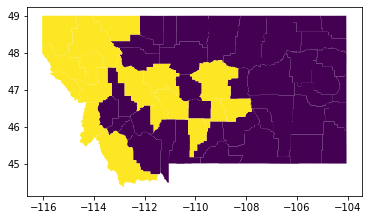

<Figure size 432x288 with 0 Axes>

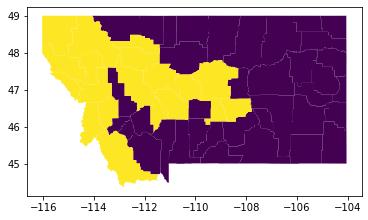

<Figure size 432x288 with 0 Axes>

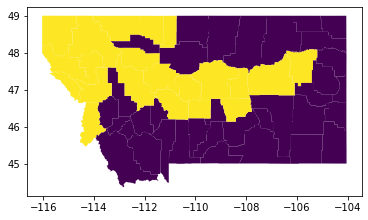

<Figure size 432x288 with 0 Axes>

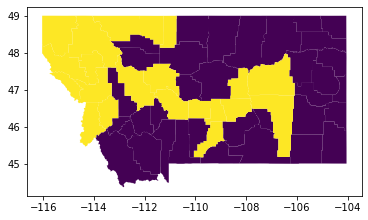

<Figure size 432x288 with 0 Axes>

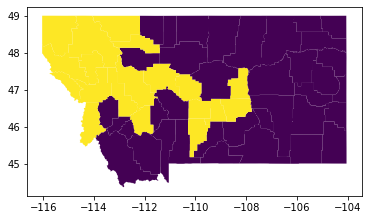

<Figure size 432x288 with 0 Axes>

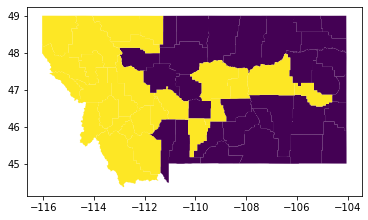

<Figure size 432x288 with 0 Axes>

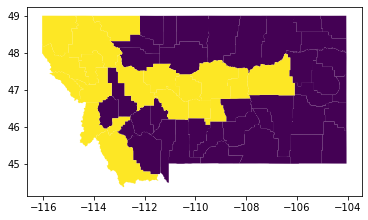

<Figure size 432x288 with 0 Axes>

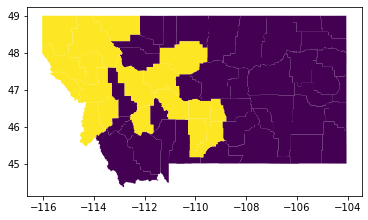

<Figure size 432x288 with 0 Axes>

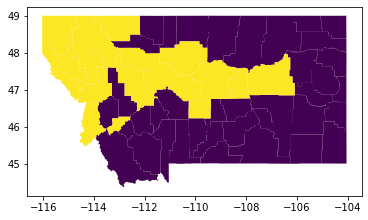

<Figure size 432x288 with 0 Axes>

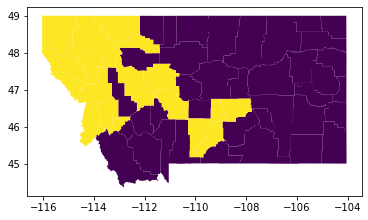

<Figure size 432x288 with 0 Axes>

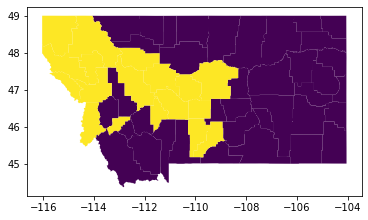

<Figure size 432x288 with 0 Axes>

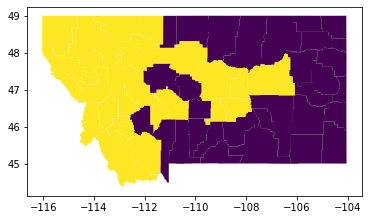

<Figure size 432x288 with 0 Axes>

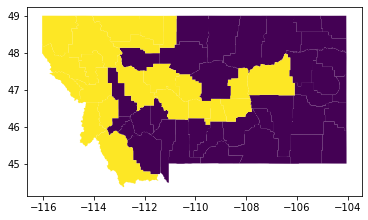

<Figure size 432x288 with 0 Axes>

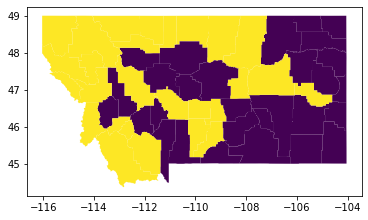

<Figure size 432x288 with 0 Axes>

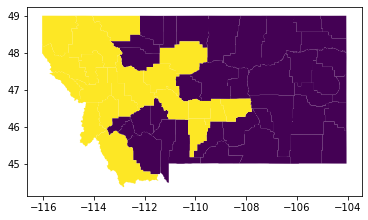

<Figure size 432x288 with 0 Axes>

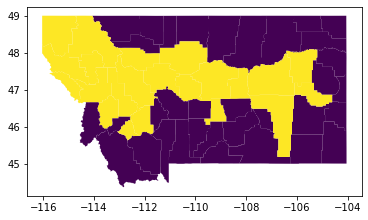

<Figure size 432x288 with 0 Axes>

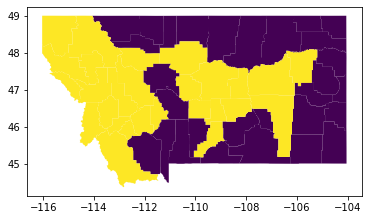

<Figure size 432x288 with 0 Axes>

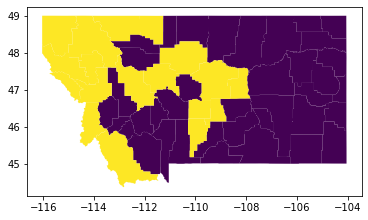

<Figure size 432x288 with 0 Axes>

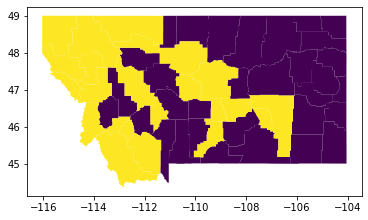

<Figure size 432x288 with 0 Axes>

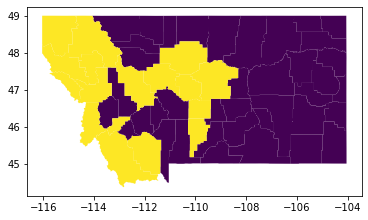

<Figure size 432x288 with 0 Axes>

In [14]:
# Draw the districting plans.
# Limit of 20 images, due to large file size.

draw_limit = min( 20, m._number_of_plans )
filename = 'MT_county.shp'

for p in range( draw_limit ):
    district = m._plans[p][0]
    draw_single_district( filepath, filename, G, district, zoom=False )
    plt.figure()